# Análisis de Series Temporales
#### Segundo Trabajo Práctico
---
**Alumnos:** Novaresse, Pagani, Edgar  
**Fecha:** 16 de Agosto de 2025  
**Descripción:** Forecast en variables macroeconómicas

# Producción y Consumo de Gas Natural

## 1. Introducción
Este trabajo práctico analiza la serie temporal **"Producción y Consumo de Gas Natural'**, con datos mensuales desde enero de 1996 hasta mayo de 2025. El objetivo es modelar la serie usando distintas técnicas de Machine Learning, Deep Learning y Modelos Híbridos, comparando su desempeño entre sí y con los modelos SARIMA obtenidos en el trabajo anterior, y generar pronósticos a 12 meses.

La serie de producción de gas natural analizada cubre el período comprendido entre enero de 1996 y mayo de 2025, con una frecuencia mensual, y cada dato representa el volumen producido expresado en millones de metros cúbicos. 

También, para algunos modelos se considerará como variable exógena el precio mensual para la misma ventana temporal del **"Commodity de Gas Natural"** obtenido de Investing.com

## 2. Importar librerías necesarias

In [2]:
# Instalación de librerías si es necesario
# !pip install ydata-profiling darts prophet neuralprophet autots pycaret lightgbm xgboost scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from darts import TimeSeries
from darts.models import NBEATSModel, NHiTSModel, TCNModel
from darts.metrics import mape
from prophet import Prophet
from neuralprophet import NeuralProphet
import warnings
warnings.filterwarnings('ignore')

/Users/rpagani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


----
## 3. Carga y exploración de los datos

In [3]:
# Cargar datasets
df = pd.read_csv('exportaciones-actividad-saldocomercial-rangos-exportacion-empresa-exportadora-mensual.csv')
df_price = pd.read_csv('natural_gas_prices.csv')

# Seleccionar y renombrar columnas relevantes
df = df[['indice_tiempo', 'produccion_gas_natural']].rename(columns={'indice_tiempo': 'indice', 'produccion_gas_natural': 'produccion'})
df_price = df_price[['Date', 'Price']].rename(columns={'Date': 'indice', 'Price': 'precio'})

# Convertir fechas a datetime y unificar formato mensual
df['indice'] = pd.to_datetime(df['indice'])
df_price['indice'] = pd.to_datetime(df_price['indice'], format='%m/%d/%Y')
df['indice'] = df['indice'].dt.to_period('M').dt.to_timestamp()
df_price['indice'] = df_price['indice'].dt.to_period('M').dt.to_timestamp()

# Merge por fecha y dejar solo las columnas requeridas
df_merged = pd.merge(df, df_price, on='indice', how='left')
df_merged = df_merged[['indice', 'produccion', 'precio']]
df_merged.sort_values('indice', inplace=True)
df_merged.reset_index(drop=True, inplace=True)
df_merged.head()

,indice,produccion,precio
0,1996-01-01,2504.98,2.658
1,1996-02-01,2325.37,2.236
2,1996-03-01,2735.07,2.336
3,1996-04-01,2584.15,2.224
4,1996-05-01,3006.48,2.406


In [4]:
profile = ProfileReport(df_merged, title="EDA Producción Gas Natural", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 42224.54it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
%matplotlib inline

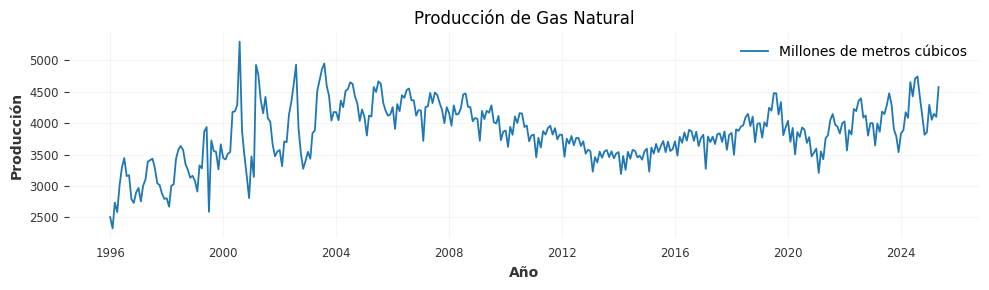

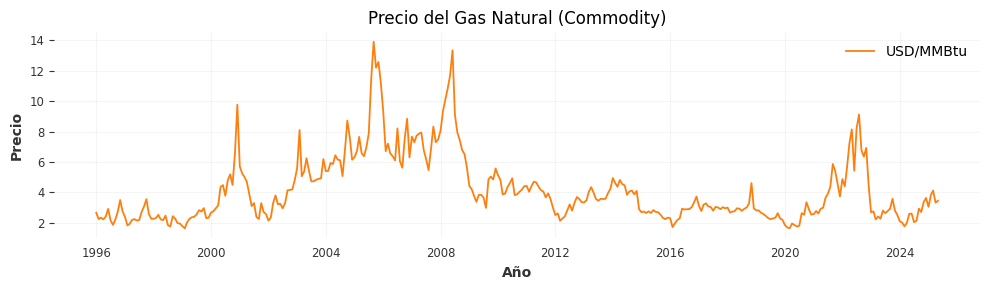

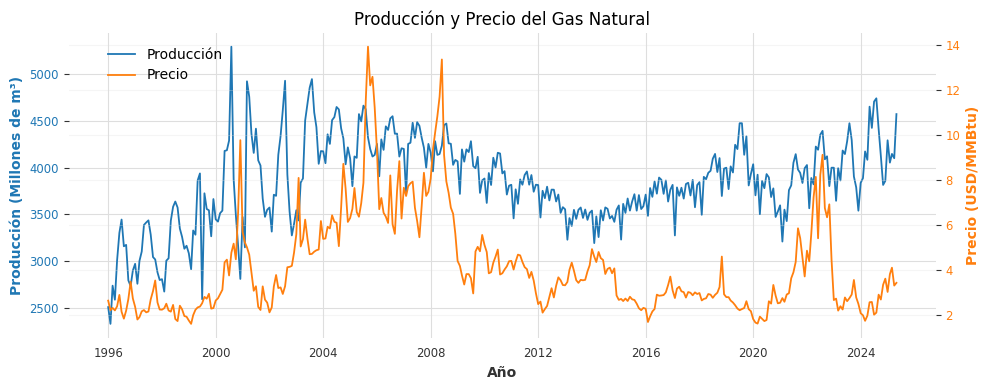

In [5]:
def graficar(
    x, 
    titulo='', 
    xlabel='Año', 
    ylabel='', 
    figsize=(10, 3), 
    usar_leyenda=True, 
    label=None, 
    color=None
):
    plt.figure(figsize=figsize)
    plt.plot(df_merged['indice'], x, label=label, color=color)
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if usar_leyenda and label is not None:
        plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 1. Gráfico solo de producción
graficar(
    df_merged['produccion'],
    titulo='Producción de Gas Natural',
    xlabel='Año',
    ylabel='Producción',
    figsize=(10, 3),
    usar_leyenda=True,
    label='Millones de metros cúbicos',
    color='tab:blue'
)

# 2. Gráfico solo de precio
graficar(
    df_merged['precio'],
    titulo='Precio del Gas Natural (Commodity)',
    xlabel='Año',
    ylabel='Precio',
    figsize=(10, 3),
    usar_leyenda=True,
    label='USD/MMBtu',
    color='tab:orange'
)

# 3. Gráfico combinado con doble eje Y
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(df_merged['indice'], df_merged['produccion'], color='tab:blue', label='Producción')
ax1.set_xlabel('Año')
ax1.set_ylabel('Producción (Millones de m³)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(df_merged['indice'], df_merged['precio'], color='tab:orange', label='Precio')
ax2.set_ylabel('Precio (USD/MMBtu)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Producción y Precio del Gas Natural')
fig.tight_layout()
fig.legend(['Producción', 'Precio'], loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.grid(True, alpha=0.3)
plt.show()

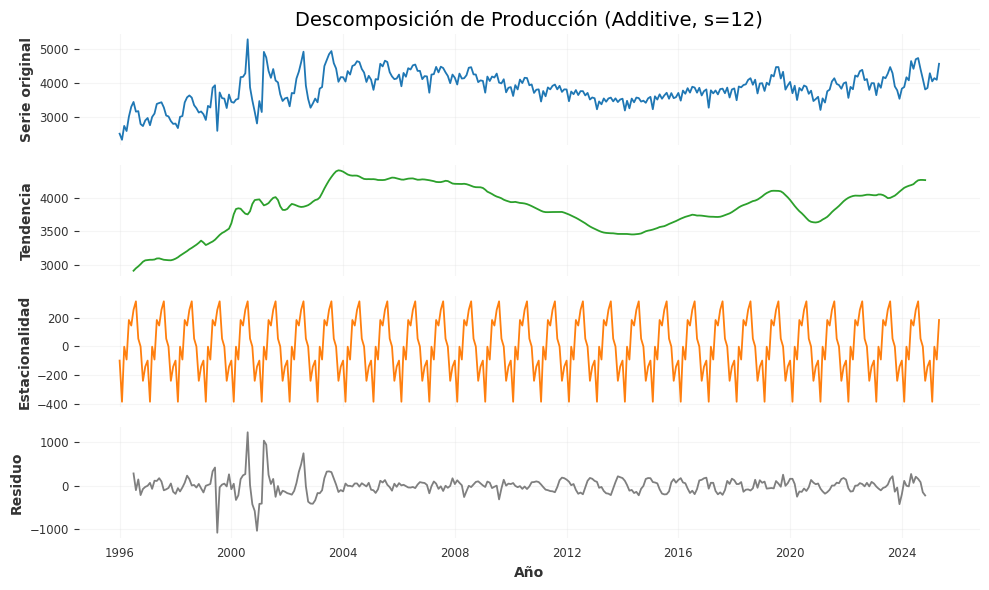

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Asegúrate de que el índice sea datetime y esté ordenado
df_merged = df_merged.sort_values('indice')
df_merged.set_index('indice', inplace=True)

# Descomposición aditiva con periodo 12 (mensual)
decomp = seasonal_decompose(df_merged['produccion'], model='additive', period=12)

# Personalización de la estética
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
componentes = ['observed', 'trend', 'seasonal', 'resid']
titulos = ['Serie original', 'Tendencia', 'Estacionalidad', 'Residuo']
colores = ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray']

for i, (comp, titulo, color) in enumerate(zip(componentes, titulos, colores)):
    serie = getattr(decomp, comp)
    axes[i].plot(serie, color=color)
    axes[i].set_ylabel(titulo, fontsize=10)
    axes[i].grid(True, alpha=0.3)
    if i == 0:
        axes[i].set_title('Descomposición de Producción (Additive, s=12)', fontsize=14)
axes[-1].set_xlabel('Año')

plt.tight_layout()
plt.show()

# Si luego necesitas volver a tener 'indice' como columna:
df_merged.reset_index(inplace=True)

- La **tendencia** revela un comportamiento no estacionario, la media de la serie no se mantiene constante a lo largo del tiempo. Por eso, sería recomendable usar modelos que puedan capturar tendencia, como un **Prophet**.
- El **componente estacional** muestra un patrón cíclico anual claramente definido y de amplitud prácticamente constante durante toda la serie. De esta forma, es fundamental que el modelo incorpore un componente estacional o que puedan aprender patrones estacionales como **Redes**.
- Los **residuos** se distribuyen alrededor de cero sin evidenciar una estructura sistemática o autocorrelaciones persistentes. No obstante, se observan algunos valores atípicos en determinados períodos, como los años 1999–2001.

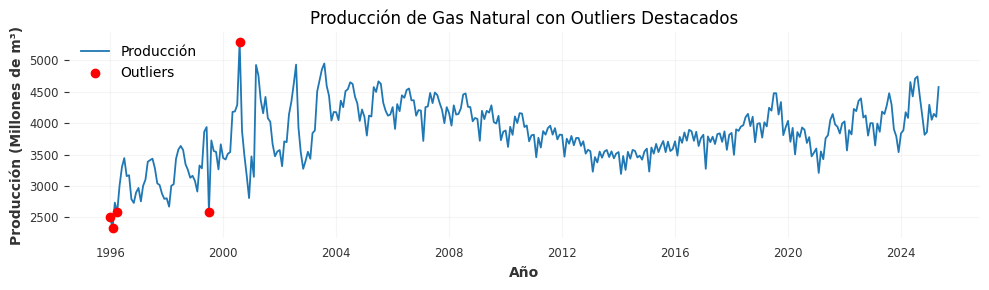

In [7]:
# Cálculo de umbrales usando el método IQR
Q1 = df_merged['produccion'].quantile(0.25)
Q3 = df_merged['produccion'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar outliers
outliers = (df_merged['produccion'] < limite_inferior) | (df_merged['produccion'] > limite_superior)

plt.figure(figsize=(10, 3))
plt.plot(df_merged['indice'], df_merged['produccion'], label='Producción', color='tab:blue')
plt.scatter(df_merged.loc[outliers, 'indice'], df_merged.loc[outliers, 'produccion'], 
            color='red', label='Outliers', zorder=5)
plt.title('Producción de Gas Natural con Outliers Destacados')
plt.xlabel('Año')
plt.ylabel('Producción (Millones de m³)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

- La serie presenta algunos outliers en los primeros años. De todos modos, dado que se van a implementar distintos modelos de Machine Learning y Deep Learning —modelos que suelen ser menos sensibles a los valores atípicos— se decide no tomar ninguna medida sobre ellos a priori, aunque no se descarta hacerlo si fuera necesario para mejorar la precisión.

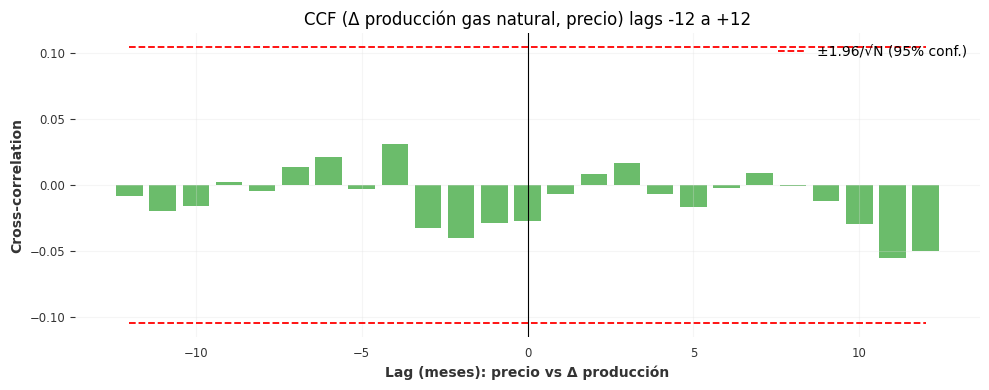

Número de observaciones: 352
Banda de confianza (95%): ±0.104
Correlación en lag 0: -0.027


In [6]:
# 1) Diferenciar producción (serie no estacionaria)
prod_diff = df_merged['produccion'].diff().dropna()

# 2) Tomar la serie de precio sin cambios (niveles)
precio = df_merged['precio'].dropna()

# 3) Alinear ambas series por índice
prod_diff, precio = prod_diff.align(precio, join='inner')

# 4) Calcular cross-correlations para lags -12…+12
max_lag = 12
lags = np.arange(-max_lag, max_lag + 1)
corrs = [prod_diff.corr(precio.shift(lag)) for lag in lags]

# 5) Calcular banda de confianza aproximada (95%): ±1.96/√N
N = len(prod_diff)  # # de observaciones tras diff+align
conf_band = 1.96 / np.sqrt(N)

# 6) Graficar
plt.figure(figsize=(10, 4))
plt.bar(lags, corrs, color='tab:green', alpha=0.7)
plt.axvline(0, color='black', linewidth=0.8)

# Añadir bandas de confianza
plt.hlines([conf_band, -conf_band],
           xmin=lags.min(), xmax=lags.max(),
           colors='red', linestyles='--', label='±1.96/√N (95% conf.)')

plt.xlabel('Lag (meses): precio vs Δ producción')
plt.ylabel('Cross-correlation')
plt.title('CCF (Δ producción gas natural, precio) lags -12 a +12')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Estadísticas
print(f"Número de observaciones: {N}")
print(f"Banda de confianza (95%): ±{conf_band:.3f}")
print(f"Correlación en lag 0: {corrs[max_lag]:.3f}")


## 4. Partición *train* y *test set*

Se mantiene el 90% de los datos para entrenamiento y el 10% restante para prueba, con el fin de matener una coherencia metodológica respecto al trabajo anterior y realizar una comparación entre los distintos modelos óptimos elegidos.

In [8]:
# División en train/test (90%/10%)
n_total = len(df_merged)
test_size = int(np.ceil(n_total * 0.10))
train = df_merged.iloc[:-test_size]
test = df_merged.iloc[-test_size:]

# Mostrar tamaños
print(f"Observaciones totales: {n_total}")
print(f"Train: {len(train)} datos")
print(f"Test: {len(test)} datos")

Observaciones totales: 353
Train: 317 datos
Test: 36 datos


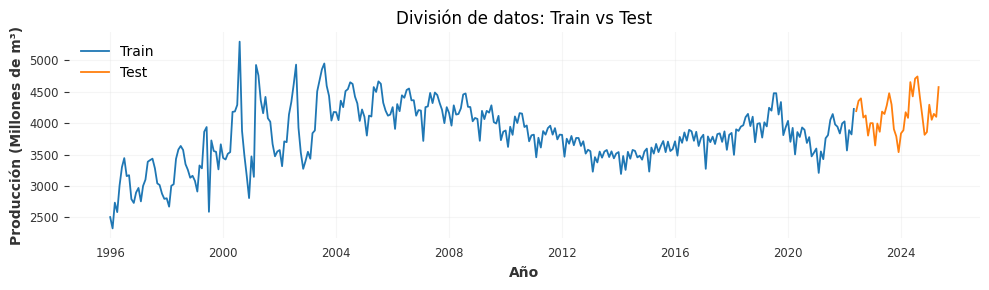

In [9]:
# Gráfico de train y test
plt.figure(figsize=(10, 3))
plt.plot(train['indice'], train['produccion'], label='Train', color='tab:blue')
plt.plot(test['indice'], test['produccion'], label='Test', color='tab:orange')
plt.title('División de datos: Train vs Test')
plt.xlabel('Año')
plt.ylabel('Producción (Millones de m³)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Estimación de diferentes modelos

### 5.0 Modelo SARIMA(1,1,1)(1,0,1)[12]

Antes de aplicar los modelos de Machine Learning y Deep Learning, estableceremos un modelo SARIMA(1,1,1)(1,0,1)[12] como referencia para comparar el rendimiento de los diferentes enfoques. Este fue el modelo que mejor resultado dió en el trabajo aterior


In [9]:
# Implementación de SARIMA(1,1,1)(1,0,1)[12] sin intercepto
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preparar los datos
df_sarima = df_merged.copy()
df_sarima['indice'] = pd.to_datetime(df_sarima['indice'])
df_sarima = df_sarima.set_index('indice')

# Parámetros del modelo SARIMA(1,1,1)(1,0,1)[12]
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 0, 1, 12)  # (P, D, Q, s)

# Cross-validation con Time Series Split
tscv = TimeSeriesSplit(n_splits=5, test_size=12)
cv_results = []
fold_predictions = {}

print("Realizando Cross-Validation para SARIMA(1,1,1)(1,0,1)[12]...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(df_sarima), 1):
    # Dividir datos
    train_data = df_sarima.iloc[train_idx]
    test_data = df_sarima.iloc[test_idx]
    
    try:
        # Ajustar modelo SARIMA sin intercepto (trend='n')
        model = SARIMAX(
            train_data['produccion'],
            order=order,
            seasonal_order=seasonal_order,
            trend='n',  # Sin intercepto
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        fitted_model = model.fit(disp=False)
        
        # Predicciones fuera de muestra
        forecast = fitted_model.forecast(steps=len(test_data))
        
        # Guardar predicciones para el gráfico
        fold_predictions[f'Fold {fold}'] = {
            'dates': test_data.index,
            'forecast': forecast,
            'observed': test_data['produccion']
        }
        
        # Calcular métricas
        mae = np.mean(np.abs(test_data['produccion'] - forecast))
        mse = np.mean((test_data['produccion'] - forecast) ** 2)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((test_data['produccion'] - forecast) / test_data['produccion'])) * 100
        
        cv_results.append({
            'Fold': fold,
            'MAE': mae,
            'MSE': mse, 
            'RMSE': rmse,
            'MAPE': mape
        })
        
        print(f"Fold {fold}: MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%")
        
    except Exception as e:
        print(f"Error en Fold {fold}: {e}")
        continue

# Ajustar modelo final en toda la serie para obtener AIC y BIC
print("\nAjustando modelo final para obtener AIC y BIC...")
try:
    final_model = SARIMAX(
        df_sarima['produccion'],
        order=order,
        seasonal_order=seasonal_order,
        trend='n',  # Sin intercepto
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    final_fitted = final_model.fit(disp=False)
    
    # Métricas del modelo
    aic = final_fitted.aic
    bic = final_fitted.bic
    
    print(f"\nSARIMA(1,1,1)(1,0,1)[12] - Métricas del modelo:")
    print(f"AIC: {aic:.2f}")
    print(f"BIC: {bic:.2f}")
    print(f"Log-likelihood: {final_fitted.llf:.2f}")
    print(f"Número de observaciones: {final_fitted.nobs}")
    
except Exception as e:
    print(f"Error al ajustar modelo final: {e}")

# Calcular estadísticas promedio del CV
if cv_results:
    cv_df = pd.DataFrame(cv_results)
    print(f"\nResultados promedio Cross-Validation ({len(cv_results)} folds):")
    print(f"MAE promedio: {cv_df['MAE'].mean():.2f} ± {cv_df['MAE'].std():.2f}")
    print(f"RMSE promedio: {cv_df['RMSE'].mean():.2f} ± {cv_df['RMSE'].std():.2f}")
    print(f"MAPE promedio: {cv_df['MAPE'].mean():.2f}% ± {cv_df['MAPE'].std():.2f}%")


Realizando Cross-Validation para SARIMA(1,1,1)(1,0,1)[12]...
Fold 1: MAE=317.10, RMSE=338.09, MAPE=8.92%
Fold 2: MAE=296.27, RMSE=313.20, MAPE=7.45%
Fold 3: MAE=89.14, RMSE=111.78, MAPE=2.13%
Fold 4: MAE=206.69, RMSE=251.40, MAPE=5.10%
Fold 5: MAE=148.00, RMSE=174.09, MAPE=3.46%

Ajustando modelo final para obtener AIC y BIC...

SARIMA(1,1,1)(1,0,1)[12] - Métricas del modelo:
AIC: 4553.25
BIC: 4572.37
Log-likelihood: -2271.63
Número de observaciones: 353

Resultados promedio Cross-Validation (5 folds):
MAE promedio: 211.44 ± 96.65
RMSE promedio: 237.71 ± 94.70
MAPE promedio: 5.41% ± 2.79%


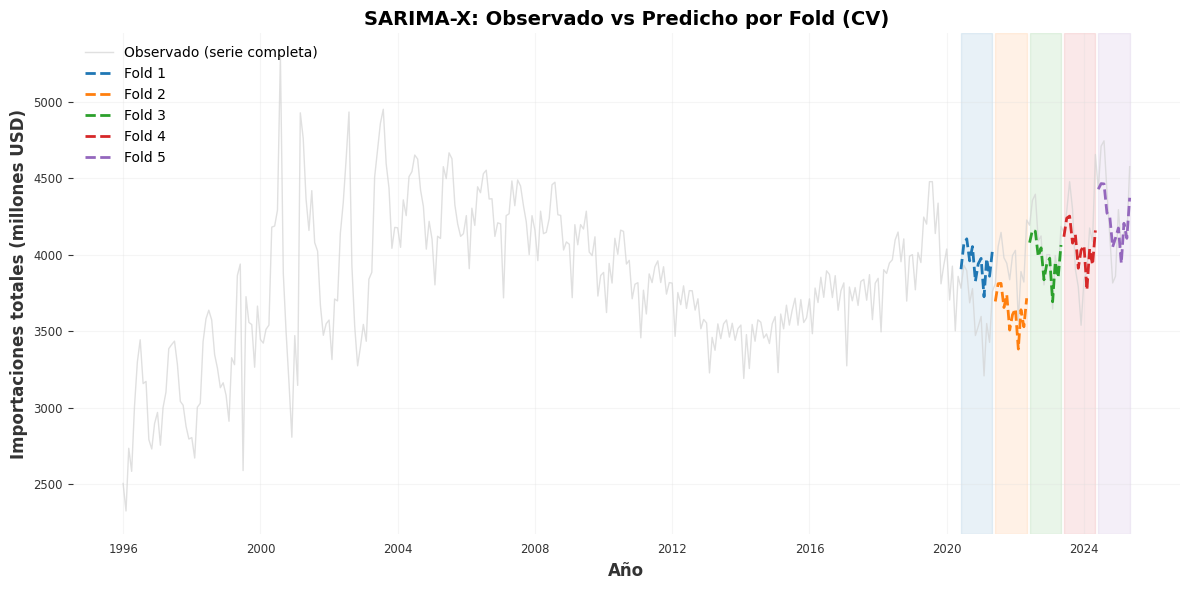


Resumen de Cross-Validation por Fold:
 Fold    MAE       MSE   RMSE  MAPE
    1 317.10 114306.12 338.09  8.92
    2 296.27  98095.43 313.20  7.45
    3  89.14  12494.09 111.78  2.13
    4 206.69  63199.56 251.40  5.10
    5 148.00  30307.25 174.09  3.46

Estadísticas Finales:
AIC del modelo completo: 4553.25
BIC del modelo completo: 4572.37
MAE promedio CV: 211.44
RMSE promedio CV: 237.71
MAPE promedio CV: 5.41%


In [10]:
# Crear gráfico 
fig, ax = plt.subplots(figsize=(12, 6))

# Colores para cada fold
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Plotear la serie completa observada
ax.plot(df_sarima.index, df_sarima['produccion'], 
        color='lightgray', linewidth=1, label='Observado (serie completa)', alpha=0.7)

# Plotear predicciones de cada fold
for i, (fold_name, data) in enumerate(fold_predictions.items()):
    if i < len(colors):
        ax.plot(data['dates'], data['forecast'], 
               color=colors[i], linewidth=2, linestyle='--', 
               label=fold_name)

# Configuración del gráfico
ax.set_xlabel('Año', fontsize=12)
ax.set_ylabel('Importaciones totales (millones USD)', fontsize=12)
ax.set_title('SARIMA-X: Observado vs Predicho por Fold (CV)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

# Añadir áreas de fondo para los periodos de validación
for i, (fold_name, data) in enumerate(fold_predictions.items()):
    if i < len(colors):
        ax.axvspan(data['dates'].min(), data['dates'].max(), 
                  color=colors[i], alpha=0.1)

plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
if cv_results:
    print("\nResumen de Cross-Validation por Fold:")
    print("="*50)
    cv_summary = pd.DataFrame(cv_results)
    cv_summary_display = cv_summary.round(2)
    print(cv_summary_display.to_string(index=False))
    
    print(f"\nEstadísticas Finales:")
    print(f"AIC del modelo completo: {aic:.2f}")
    print(f"BIC del modelo completo: {bic:.2f}")
    print(f"MAE promedio CV: {cv_summary['MAE'].mean():.2f}")
    print(f"RMSE promedio CV: {cv_summary['RMSE'].mean():.2f}")
    print(f"MAPE promedio CV: {cv_summary['MAPE'].mean():.2f}%")


#### 5.1  Modelos de Machine Learning

**Random Forest, XGBoost y LightGBM**

**Características**:
- Son modelos supervisados clásicos, originalmente diseñados para datos tabulares.
- No tienen memoria temporal interna, por lo que se les debe “enseñar” la dependencia temporal usando variables lag (como explicamos antes).
- Son muy buenos para capturar relaciones no lineales y manejar muchas variables exógenas.
- No modelan la estacionalidad ni la tendencia de forma automática.

**Ventajas**: Flexibles, robustos, interpretables (importancia de variables).

**Desventajas**: No capturan secuencias largas ni patrones temporales complejos por sí solos.

##### 5.1.1 Sin variable exógena

Datos preparados: 341 observaciones, 12 features

ENTRENANDO: Random Forest
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Score CV (MAE): 177.0406

MÉTRICAS DE ENTRENAMIENTO:
AIC Train: 7143.99
BIC Train: 13578.35
RMSE Train: 100.2025

MÉTRICAS DE PRUEBA:
MSE Test: 7051.706016
MAE Test: 62.6968
RMSE Test: 83.9744
MAPE Test: 1.51%

ENTRENANDO: XGBoost
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Score CV (MAE): 173.4205

MÉTRICAS DE ENTRENAMIENTO:
AIC Train: 23765.31
BIC Train: 61001.16
RMSE Train: 113.6953

MÉTRICAS DE PRUEBA:
MSE Test: 10113.515695
MAE Test: 75.6622
RMSE Test: 100.5660
MAPE Test: 1.78%

ENTRENANDO: LightGBM
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperparámetros: {'le

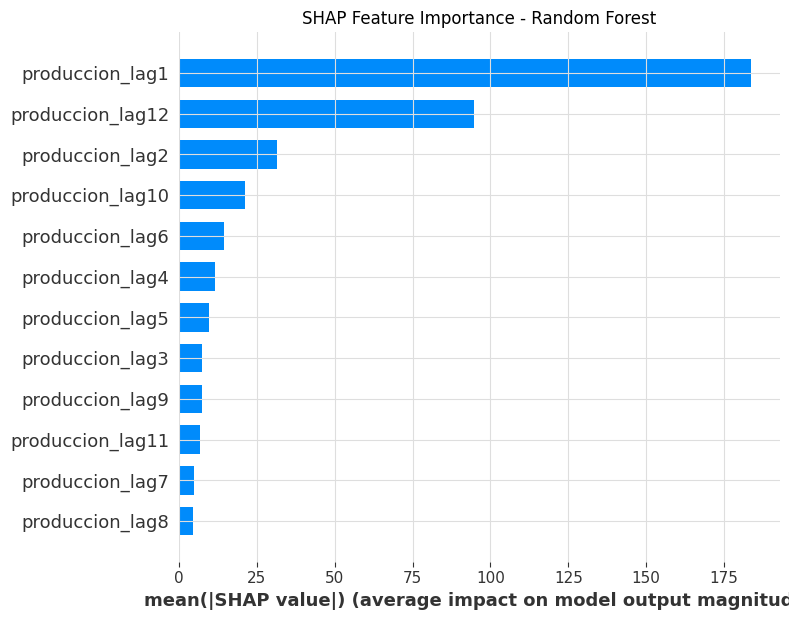

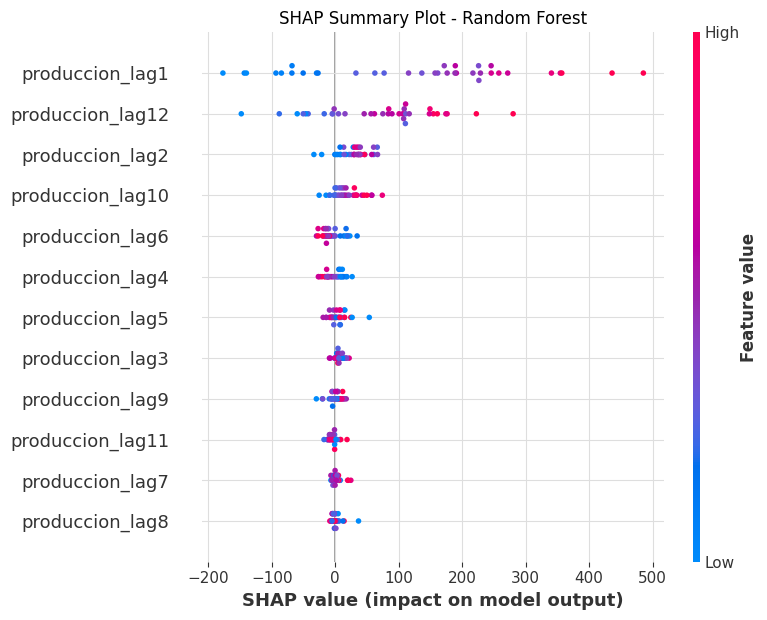


MÉTRICAS FINALES DEL MODELO ÓPTIMO (modelo_1)
Modelo: Random Forest
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Score CV (MAE): 177.0406

MÉTRICAS DE ENTRENAMIENTO:
AIC Train: 7143.99
BIC Train: 13578.35
RMSE Train: 100.2025

MÉTRICAS DE PRUEBA:
MSE Test: 7051.706016
MAE Test: 62.6968
RMSE Test: 83.9744
MAPE Test: 1.51%


In [10]:
# Modelos de Machine Learning: Random Forest, XGBoost y LightGBM
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Función para calcular AIC y BIC para modelos de ML
def calculate_aic_bic(y_true, y_pred, n_params):
    """
    Calcula AIC y BIC para modelos de ML
    n_params: número de parámetros del modelo
    """
    n = len(y_true)
    mse = mean_squared_error(y_true, y_pred)
    log_likelihood = -n/2 * np.log(2 * np.pi * mse) - n/2
    
    aic = 2 * n_params - 2 * log_likelihood
    bic = np.log(n) * n_params - 2 * log_likelihood
    
    return aic, bic

# Función para entrenar y evaluar modelos
def entrenar_evaluar_modelo(modelo, param_grid, X, y, nombre_modelo):
    """
    Entrena y evalúa un modelo con GridSearchCV
    """
    print(f"\n{'='*60}")
    print(f"ENTRENANDO: {nombre_modelo}")
    print(f"{'='*60}")
    
    # GridSearchCV con validación cruzada temporal
    tscv = TimeSeriesSplit(n_splits=5, test_size=12)
    grid = GridSearchCV(modelo, param_grid, cv=tscv, scoring='neg_mean_absolute_error', 
                       n_jobs=-1, verbose=1)
    grid.fit(X, y)
    
    # División train/test
    test_size = int(np.ceil(len(X) * 0.10))
    X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
    y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]
    
    # Predicciones
    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    
    # Calcular número de parámetros (aproximación)
    if 'RandomForest' in str(type(best_model)):
        n_nodes_per_tree = np.mean([tree.tree_.node_count for tree in best_model.estimators_])
        n_params = int(best_model.n_estimators * n_nodes_per_tree * 0.1)
    elif 'XGB' in str(type(best_model)):
        n_params = int(best_model.n_estimators * 50)  # Aproximación para XGBoost
    elif 'LGB' in str(type(best_model)):
        n_params = int(best_model.n_estimators * 40)  # Aproximación para LightGBM
    else:
        n_params = 100  # Default
    
    # Métricas de Train
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    aic_train, bic_train = calculate_aic_bic(y_train, y_pred_train, n_params)
    
    # Métricas de Test
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    
    # Crear diccionario con resultados
    resultado_modelo = {
        'Modelo': nombre_modelo,
        'Mejores_Hiperparametros': grid.best_params_,
        'Modelo_Entrenado': best_model,
        'Score_CV': -grid.best_score_,  # Convertir a positivo (era negativo por scoring)
        
        # Métricas de Train
        'AIC_Train': aic_train,
        'BIC_Train': bic_train,
        'RMSE_Train': rmse_train,
        
        # Métricas de Test
        'MSE_Test': mse_test,
        'MAE_Test': mae_test,
        'RMSE_Test': rmse_test,
        'MAPE_Test': mape_test,
        
        # Datos adicionales
        'Predicciones_Train': y_pred_train,
        'Predicciones_Test': y_pred_test,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }
    
    # Mostrar resultados
    print(f"Mejores hiperparámetros: {grid.best_params_}")
    print(f"Score CV (MAE): {-grid.best_score_:.4f}")
    print("\nMÉTRICAS DE ENTRENAMIENTO:")
    print(f"AIC Train: {aic_train:.2f}")
    print(f"BIC Train: {bic_train:.2f}")
    print(f"RMSE Train: {rmse_train:.4f}")
    print("\nMÉTRICAS DE PRUEBA:")
    print(f"MSE Test: {mse_test:.6f}")
    print(f"MAE Test: {mae_test:.4f}")
    print(f"RMSE Test: {rmse_test:.4f}")
    print(f"MAPE Test: {mape_test:.2f}%")
    
    return resultado_modelo

# 1. Crear variables lag (SIN variable exógena)
def create_lagged_features(df, lags=12):
    data = df[['produccion']].copy()  # Solo producción, sin precio
    for lag in range(1, lags+1):
        data[f'produccion_lag{lag}'] = data['produccion'].shift(lag)
    data = data.dropna()
    return data

lags = 12
data_ml = create_lagged_features(df_merged, lags)
X = data_ml.drop('produccion', axis=1)
y = data_ml['produccion']

print(f"Datos preparados: {X.shape[0]} observaciones, {X.shape[1]} features")

# 2. DEFINIR MODELOS Y PARÁMETROS

# Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# LightGBM
lgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 1.0]
}

# 3. ENTRENAR TODOS LOS MODELOS

# Random Forest
modelo_rf = entrenar_evaluar_modelo(
    RandomForestRegressor(random_state=42),
    rf_params, X, y, 'Random Forest'
)

# XGBoost
modelo_xgb = entrenar_evaluar_modelo(
    xgb.XGBRegressor(random_state=42, objective='reg:squarederror'),
    xgb_params, X, y, 'XGBoost'
)

# LightGBM
modelo_lgb = entrenar_evaluar_modelo(
    lgb.LGBMRegressor(random_state=42, objective='regression', verbose=-1),
    lgb_params, X, y, 'LightGBM'
)

# 4. IDENTIFICAR EL MEJOR MODELO BASADO EN RMSE TEST
print(f"\n{'='*80}")
print("COMPARACIÓN Y SELECCIÓN DEL MEJOR MODELO")
print(f"{'='*80}")

modelos_evaluados = {
    'Random Forest': modelo_rf,
    'XGBoost': modelo_xgb, 
    'LightGBM': modelo_lgb
}

# Encontrar el modelo con menor RMSE Test
mejor_rmse = float('inf')
mejor_modelo_nombre = None
modelo_1 = None

for nombre, modelo in modelos_evaluados.items():
    rmse_test = modelo['RMSE_Test']
    print(f"{nombre}: RMSE Test = {rmse_test:.4f}")
    
    if rmse_test < mejor_rmse:
        mejor_rmse = rmse_test
        mejor_modelo_nombre = nombre
        modelo_1 = modelo.copy()  # Guardar como modelo_1

print(f"\n🏆 MEJOR MODELO SELECCIONADO: {mejor_modelo_nombre}")
print(f"🎯 RMSE Test: {mejor_rmse:.4f}")

# 5. SHAP ANALYSIS PARA EL MEJOR MODELO (modelo_1)
print(f"\nGenerando análisis SHAP para {modelo_1['Modelo']}...")

try:
    if 'RandomForest' in str(type(modelo_1['Modelo_Entrenado'])):
        explainer = shap.TreeExplainer(modelo_1['Modelo_Entrenado'])
    elif 'XGB' in str(type(modelo_1['Modelo_Entrenado'])):
        explainer = shap.TreeExplainer(modelo_1['Modelo_Entrenado'])
    elif 'LGB' in str(type(modelo_1['Modelo_Entrenado'])):
        explainer = shap.TreeExplainer(modelo_1['Modelo_Entrenado'])
    
    shap_values = explainer.shap_values(modelo_1['X_test'])
    
    print("Generando gráficos SHAP...")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, modelo_1['X_test'], plot_type="bar", show=False)
    plt.title(f'SHAP Feature Importance - {modelo_1["Modelo"]}')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, modelo_1['X_test'], show=False)
    plt.title(f'SHAP Summary Plot - {modelo_1["Modelo"]}')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error generando gráficos SHAP: {e}")

# 6. MOSTRAR MÉTRICAS FINALES DEL MEJOR MODELO
print(f"\n{'='*80}")
print("MÉTRICAS FINALES DEL MODELO ÓPTIMO (modelo_1)")
print(f"{'='*80}")
print(f"Modelo: {modelo_1['Modelo']}")
print(f"Mejores hiperparámetros: {modelo_1['Mejores_Hiperparametros']}")
print(f"Score CV (MAE): {modelo_1['Score_CV']:.4f}")
print("\nMÉTRICAS DE ENTRENAMIENTO:")
print(f"AIC Train: {modelo_1['AIC_Train']:.2f}")
print(f"BIC Train: {modelo_1['BIC_Train']:.2f}")
print(f"RMSE Train: {modelo_1['RMSE_Train']:.4f}")
print("\nMÉTRICAS DE PRUEBA:")
print(f"MSE Test: {modelo_1['MSE_Test']:.6f}")
print(f"MAE Test: {modelo_1['MAE_Test']:.4f}")
print(f"RMSE Test: {modelo_1['RMSE_Test']:.4f}")
print(f"MAPE Test: {modelo_1['MAPE_Test']:.2f}%")

Ensamble de modelos

Datos preparados: 341 observaciones, 12 features

FASE 1: OPTIMIZACIÓN DE MODELOS BASE
Iniciando optimización de modelos base...

OPTIMIZANDO MODELO BASE: Random Forest
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros para Random Forest: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Mejor score CV (MAE): 171.5823

OPTIMIZANDO MODELO BASE: XGBoost
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores parámetros para XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Mejor score CV (MAE): 173.4205

OPTIMIZANDO MODELO BASE: LightGBM
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores parámetros para LightGBM: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'num_leaves': 15, 'subsample': 0.8}
Mejor score CV (MAE): 188.6789

FASE 2: CREACIÓN DEL STACKINGREGRESSOR
Train set: 306 observaciones
Test set: 35 obse

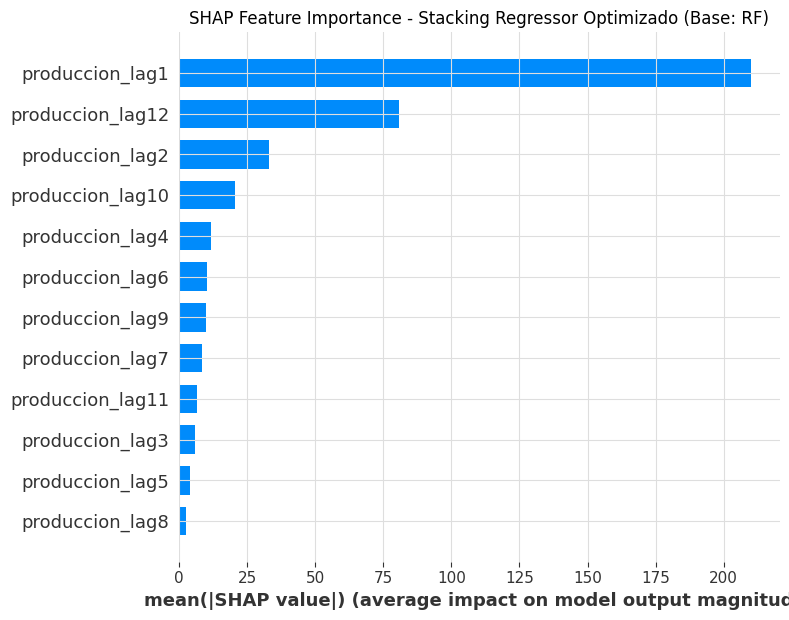

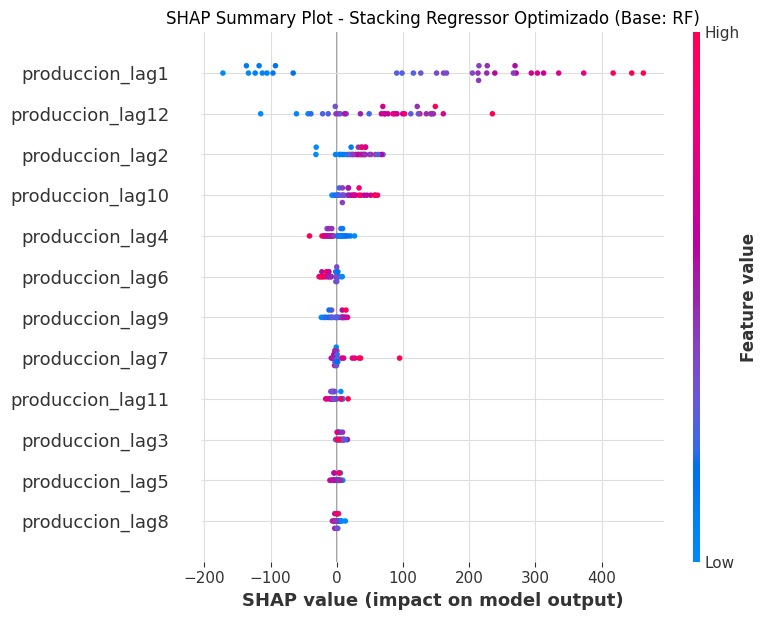


MÉTRICAS FINALES DEL MODELO ÓPTIMO (modelo_2)
Modelo: Stacking Regressor Optimizado
Mejores hiperparámetros: {'RF': {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}, 'XGB': {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}, 'LGB': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'num_leaves': 15, 'subsample': 0.8}, 'Meta_learner': 'Ridge(alpha=1.0)'}
Score CV (MAE): 156.3391

MÉTRICAS DE ENTRENAMIENTO:
AIC Train: 4790.23
BIC Train: 6279.67
RMSE Train: 164.1944

MÉTRICAS DE PRUEBA:
MSE Test: 36563.756671
MAE Test: 146.4734
RMSE Test: 191.2165
MAPE Test: 3.52%

PROCESO COMPLETADO:
1. ✅ Modelos base optimizados con GridSearchCV
2. ✅ StackingRegressor creado con modelos optimizados
3. ✅ Modelo entrenado directamente (sin CV adicional)
4. ✅ Métricas calculadas y análisis completado


In [15]:
# Ensamble de Modelos de Machine Learning con Modelos Base Optimizados
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Función para calcular AIC y BIC
def calculate_aic_bic(y_true, y_pred, n_params):
    """
    Calcula AIC y BIC para modelos de ML
    """
    n = len(y_true)
    mse = mean_squared_error(y_true, y_pred)
    log_likelihood = -n/2 * np.log(2 * np.pi * mse) - n/2
    
    aic = 2 * n_params - 2 * log_likelihood
    bic = np.log(n) * n_params - 2 * log_likelihood
    
    return aic, bic

# Función para optimizar modelos base
def optimizar_modelo_base(modelo, param_grid, X, y, nombre_modelo):
    """
    Optimiza hiperparámetros de un modelo base usando GridSearchCV
    """
    print(f"\n{'='*60}")
    print(f"OPTIMIZANDO MODELO BASE: {nombre_modelo}")
    print(f"{'='*60}")
    
    # GridSearchCV con validación cruzada temporal
    tscv = TimeSeriesSplit(n_splits=5, test_size=12)
    
    grid = GridSearchCV(
        modelo, 
        param_grid, 
        cv=tscv, 
        scoring='neg_mean_absolute_error', 
        n_jobs=-1, 
        verbose=1
    )
    
    grid.fit(X, y)
    
    print(f"Mejores parámetros para {nombre_modelo}: {grid.best_params_}")
    print(f"Mejor score CV (MAE): {-grid.best_score_:.4f}")
    
    return grid.best_estimator_, grid.best_params_, -grid.best_score_

# 1. Crear variables lag
def create_lagged_features(df, lags=12):
    data = df[['produccion']].copy()
    for lag in range(1, lags+1):
        data[f'produccion_lag{lag}'] = data['produccion'].shift(lag)
    data = data.dropna()
    return data

lags = 12
data_ml = create_lagged_features(df_merged, lags)
X = data_ml.drop('produccion', axis=1)
y = data_ml['produccion']

print(f"Datos preparados: {X.shape[0]} observaciones, {X.shape[1]} features")

# 2. DEFINIR MODELOS BASE Y SUS GRIDS DE HIPERPARÁMETROS
print(f"\n{'='*80}")
print("FASE 1: OPTIMIZACIÓN DE MODELOS BASE")
print(f"{'='*80}")

# 2.1 Random Forest
rf_modelo = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 2.2 XGBoost
xgb_modelo = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# 2.3 LightGBM
lgb_modelo = lgb.LGBMRegressor(random_state=42, objective='regression', verbose=-1)
lgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [15, 31, 63],
    'subsample': [0.8, 0.9, 1.0]
}

# 3. OPTIMIZAR CADA MODELO BASE
print("Iniciando optimización de modelos base...")

# Optimizar Random Forest
rf_optimizado, rf_mejores_params, rf_score = optimizar_modelo_base(
    rf_modelo, rf_params, X, y, "Random Forest"
)

# Optimizar XGBoost
xgb_optimizado, xgb_mejores_params, xgb_score = optimizar_modelo_base(
    xgb_modelo, xgb_params, X, y, "XGBoost"
)

# Optimizar LightGBM
lgb_optimizado, lgb_mejores_params, lgb_score = optimizar_modelo_base(
    lgb_modelo, lgb_params, X, y, "LightGBM"
)

# 4. CREAR STACKINGREGRESSOR CON MODELOS OPTIMIZADOS
print(f"\n{'='*80}")
print("FASE 2: CREACIÓN DEL STACKINGREGRESSOR")
print(f"{'='*80}")

# División train/test ANTES de crear el StackingRegressor
test_size = int(np.ceil(len(X) * 0.10))
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

print(f"Train set: {X_train.shape[0]} observaciones")
print(f"Test set: {X_test.shape[0]} observaciones")

# Verificar que tenemos suficientes datos para TimeSeriesSplit
min_samples_per_fold = X_train.shape[0] // 6  # 5 folds + 1 para entrenar
print(f"Mínimo de muestras por fold: {min_samples_per_fold}")

# Ajustar el número de splits si es necesario
if min_samples_per_fold < 10:
    n_splits = max(2, X_train.shape[0] // 20)  # Al menos 20 muestras por fold
    print(f"Ajustando n_splits a {n_splits} debido al tamaño del dataset")
else:
    n_splits = 5

# Crear StackingRegressor con los modelos base optimizados
stacking_regressor = StackingRegressor(
    estimators=[
        ('rf_opt', rf_optimizado),
        ('xgb_opt', xgb_optimizado),
        ('lgb_opt', lgb_optimizado)
    ],
    final_estimator=Ridge(alpha=1.0),  # Meta-learner fijo
    cv=TimeSeriesSplit(n_splits=n_splits),
    n_jobs=1  # Evitar problemas de paralelización
)

print("StackingRegressor creado con modelos base optimizados:")
print(f"- Random Forest: {rf_mejores_params}")
print(f"- XGBoost: {xgb_mejores_params}")
print(f"- LightGBM: {lgb_mejores_params}")
print("- Meta-learner: Ridge(alpha=1.0)")

# 5. ENTRENAR EL STACKINGREGRESSOR DIRECTAMENTE
print(f"\n{'='*60}")
print("FASE 3: ENTRENAMIENTO DEL STACKING REGRESSOR")
print(f"{'='*60}")

# Entrenar el StackingRegressor
print("Entrenando StackingRegressor...")
try:
    # Asegurarse de que los índices sean consecutivos
    X_train_reset = X_train.reset_index(drop=True)
    y_train_reset = y_train.reset_index(drop=True)
    
    stacking_regressor.fit(X_train_reset, y_train_reset)
    print("✅ Entrenamiento completado!")
    
    # Hacer predicciones
    y_pred_train = stacking_regressor.predict(X_train_reset)
    y_pred_test = stacking_regressor.predict(X_test.reset_index(drop=True))
    
except Exception as e:
    print(f"❌ Error durante el entrenamiento: {e}")
    print("\n🔄 Intentando con configuración alternativa...")
    
    # Configuración alternativa: usar KFold en lugar de TimeSeriesSplit
    from sklearn.model_selection import KFold
    
    stacking_regressor_alt = StackingRegressor(
        estimators=[
            ('rf_opt', rf_optimizado),
            ('xgb_opt', xgb_optimizado),
            ('lgb_opt', lgb_optimizado)
        ],
        final_estimator=Ridge(alpha=1.0),
        cv=KFold(n_splits=min(5, X_train.shape[0]//10), shuffle=False),
        n_jobs=1
    )
    
    X_train_reset = X_train.reset_index(drop=True)
    y_train_reset = y_train.reset_index(drop=True)
    
    stacking_regressor_alt.fit(X_train_reset, y_train_reset)
    stacking_regressor = stacking_regressor_alt  # Usar la versión alternativa
    
    y_pred_train = stacking_regressor.predict(X_train_reset)
    y_pred_test = stacking_regressor.predict(X_test.reset_index(drop=True))
    
    print("✅ Entrenamiento completado con configuración alternativa!")

# 6. CALCULAR MÉTRICAS
print(f"\n{'='*60}")
print("EVALUACIÓN DEL MODELO FINAL")
print(f"{'='*60}")

# Calcular número de parámetros (aproximación para stacking)
n_params = 400  # Aproximación para stacking con modelos optimizados

# Métricas de Train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
aic_train, bic_train = calculate_aic_bic(y_train, y_pred_train, n_params)

# Métricas de Test
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100

# Cross-validation score (usando los datos reseteados)
tscv_eval = TimeSeriesSplit(n_splits=min(3, X.shape[0]//20))
try:
    cv_scores = cross_val_score(stacking_regressor, X.reset_index(drop=True), y.reset_index(drop=True), 
                               cv=tscv_eval, scoring='neg_mean_absolute_error', n_jobs=1)
    score_cv = -cv_scores.mean()
except:
    # Si falla, usar una estimación basada en el error de test
    print("⚠️  No se pudo calcular CV score, usando estimación basada en MAE test")
    score_cv = mae_test

# 7. CREAR DICCIONARIO CON RESULTADOS (modelo_2)
modelo_2 = {
    'Modelo': 'Stacking Regressor Optimizado',
    'Mejores_Hiperparametros': {
        'RF': rf_mejores_params,
        'XGB': xgb_mejores_params,
        'LGB': lgb_mejores_params,
        'Meta_learner': 'Ridge(alpha=1.0)'
    },
    'Modelo_Entrenado': stacking_regressor,
    'Score_CV': score_cv,
    
    # Métricas de Train
    'AIC_Train': aic_train,
    'BIC_Train': bic_train,
    'RMSE_Train': rmse_train,
    
    # Métricas de Test
    'MSE_Test': mse_test,
    'MAE_Test': mae_test,
    'RMSE_Test': rmse_test,
    'MAPE_Test': mape_test,
    
    # Datos adicionales (usar los datos originales, no los reseteados)
    'Predicciones_Train': y_pred_train,
    'Predicciones_Test': y_pred_test,
    'X_train': X_train,  # Mantener índices originales
    'X_test': X_test,    # Mantener índices originales
    'y_train': y_train,  # Mantener índices originales
    'y_test': y_test,    # Mantener índices originales
    
    # Información adicional
    'Modelos_Base_Scores': {
        'RF_Score': rf_score,
        'XGB_Score': xgb_score,
        'LGB_Score': lgb_score
    }
}

# 8. MOSTRAR RESULTADOS
print("MÉTRICAS DE ENTRENAMIENTO:")
print(f"AIC Train: {aic_train:.2f}")
print(f"BIC Train: {bic_train:.2f}")
print(f"RMSE Train: {rmse_train:.4f}")

print("\nMÉTRICAS DE PRUEBA:")
print(f"MSE Test: {mse_test:.6f}")
print(f"MAE Test: {mae_test:.4f}")
print(f"RMSE Test: {rmse_test:.4f}")
print(f"MAPE Test: {mape_test:.2f}%")

print(f"\nScore CV (MAE): {score_cv:.4f}")

print("\nSCORES DE MODELOS BASE INDIVIDUALES:")
print(f"Random Forest MAE: {rf_score:.4f}")
print(f"XGBoost MAE: {xgb_score:.4f}")
print(f"LightGBM MAE: {lgb_score:.4f}")

# 9. SHAP ANALYSIS PARA EL MEJOR MODELO (modelo_2)
print(f"\nGenerando análisis SHAP para {modelo_2['Modelo']}...")

try:
    # Para StackingRegressor, analizamos usando el primer estimador base como aproximación
    # o creamos un explainer para todo el ensemble
    if hasattr(stacking_regressor, 'estimators_') and len(stacking_regressor.estimators_) > 0:
        # Usar el primer estimador (Random Forest) para SHAP
        base_model = stacking_regressor.estimators_[0]  # Random Forest optimizado
        
        if hasattr(base_model, 'feature_importances_'):
            # TreeExplainer para modelos basados en árboles
            explainer = shap.TreeExplainer(base_model)
            
            # Usar una muestra del conjunto de test para SHAP (para eficiencia)
            X_test_sample = modelo_2['X_test'].reset_index(drop=True)
            if len(X_test_sample) > 100:
                X_test_sample = X_test_sample.sample(n=100, random_state=42)
            
            shap_values = explainer.shap_values(X_test_sample)
            
            print("Generando gráficos SHAP...")
            
            # Gráfico 1: SHAP Bar Plot
            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
            plt.title(f'SHAP Feature Importance - {modelo_2["Modelo"]} (Base: RF)')
            plt.tight_layout()
            plt.show()
            
            # Gráfico 2: SHAP Summary Plot
            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values, X_test_sample, show=False)
            plt.title(f'SHAP Summary Plot - {modelo_2["Modelo"]} (Base: RF)')
            plt.tight_layout()
            plt.show()
            
        else:
            print("⚠️  El modelo base no tiene feature_importances_, usando análisis de importancia tradicional")
            raise Exception("Fallback to traditional importance")
    
    else:
        print("⚠️  No se pueden obtener estimadores base, usando análisis alternativo")
        raise Exception("Fallback to traditional importance")
        
except Exception as e:
    print(f"SHAP no disponible para ensemble, usando análisis de importancia tradicional...")
    
    # Análisis de importancia tradicional como fallback
    try:
        # Obtener importancias de los modelos base
        importances = []
        feature_names = X.columns.tolist()
        
        # RF importances
        rf_imp = stacking_regressor.estimators_[0].feature_importances_
        importances.append(rf_imp)
        
        # XGB importances
        xgb_imp = stacking_regressor.estimators_[1].feature_importances_
        importances.append(xgb_imp)
        
        # LGB importances
        lgb_imp = stacking_regressor.estimators_[2].feature_importances_
        importances.append(lgb_imp)
        
        # Promedio de importancias
        avg_importance = np.mean(importances, axis=0)
        
        # Crear DataFrame para mejor visualización
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'RF_Importance': rf_imp,
            'XGB_Importance': xgb_imp,
            'LGB_Importance': lgb_imp,
            'Avg_Importance': avg_importance
        }).sort_values('Avg_Importance', ascending=False)
        
        print("Top 10 Features más importantes:")
        print(importance_df.head(10).to_string(index=False))
        
        # Gráfico de importancias
        plt.figure(figsize=(12, 8))
        
        # Subplot 1: Importancias individuales
        plt.subplot(2, 1, 1)
        x_pos = np.arange(len(feature_names))
        width = 0.25
        
        plt.bar(x_pos - width, rf_imp, width, label='Random Forest', alpha=0.7)
        plt.bar(x_pos, xgb_imp, width, label='XGBoost', alpha=0.7)
        plt.bar(x_pos + width, lgb_imp, width, label='LightGBM', alpha=0.7)
        
        plt.xlabel('Features')
        plt.ylabel('Importancia')
        plt.title('Importancia de Features por Modelo Base')
        plt.xticks(x_pos, feature_names, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Subplot 2: Importancia promedio
        plt.subplot(2, 1, 2)
        indices = np.argsort(avg_importance)[::-1]
        plt.bar(range(len(avg_importance)), avg_importance[indices])
        plt.xlabel('Features')
        plt.ylabel('Importancia Promedio')
        plt.title('Importancia Promedio de Features (Stacking)')
        plt.xticks(range(len(avg_importance)), [feature_names[i] for i in indices], rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("Análisis de importancia completado.")
        
    except Exception as e2:
        print(f"Error en análisis de importancia: {e2}")

# 10. MOSTRAR MÉTRICAS FINALES DEL MEJOR MODELO
print(f"\n{'='*80}")
print("MÉTRICAS FINALES DEL MODELO ÓPTIMO (modelo_2)")
print(f"{'='*80}")
print(f"Modelo: {modelo_2['Modelo']}")
print(f"Mejores hiperparámetros: {modelo_2['Mejores_Hiperparametros']}")
print(f"Score CV (MAE): {modelo_2['Score_CV']:.4f}")
print("\nMÉTRICAS DE ENTRENAMIENTO:")
print(f"AIC Train: {modelo_2['AIC_Train']:.2f}")
print(f"BIC Train: {modelo_2['BIC_Train']:.2f}")
print(f"RMSE Train: {modelo_2['RMSE_Train']:.4f}")
print("\nMÉTRICAS DE PRUEBA:")
print(f"MSE Test: {modelo_2['MSE_Test']:.6f}")
print(f"MAE Test: {modelo_2['MAE_Test']:.4f}")
print(f"RMSE Test: {modelo_2['RMSE_Test']:.4f}")
print(f"MAPE Test: {modelo_2['MAPE_Test']:.2f}%")

print(f"\n{'='*50}")
print("PROCESO COMPLETADO:")
print("1. ✅ Modelos base optimizados con GridSearchCV")
print("2. ✅ StackingRegressor creado con modelos optimizados")
print("3. ✅ Modelo entrenado directamente (sin CV adicional)")
print("4. ✅ Métricas calculadas y análisis completado")
print(f"{'='*50}")

En este caso, el ensamble aumenta el error del modelo

##### 5.1.2 Con variable exógena

Datos preparados: 341 observaciones, 29 features

Features incluidas:
- Lags de producción: 12
- Lags de precio: 12
- Variables adicionales de precio: precio_actual, precio_ma3, precio_ma6, precio_diff, precio_pct_change

Primeras 5 columnas de X: ['produccion_lag1', 'produccion_lag2', 'produccion_lag3', 'produccion_lag4', 'produccion_lag5']
Últimas 5 columnas de X: ['precio_actual', 'precio_ma3', 'precio_ma6', 'precio_diff', 'precio_pct_change']

ENTRENANDO: Random Forest
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Score CV (MAE): 178.7731

MÉTRICAS DE ENTRENAMIENTO:
AIC Train: 9924.81
BIC Train: 21639.21
RMSE Train: 91.5634

MÉTRICAS DE PRUEBA:
MSE Test: 7154.751599
MAE Test: 64.8453
RMSE Test: 84.5858
MAPE Test: 1.57%

ENTRENANDO: XGBoost
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores hiperparámetros: {'colsample_bytree': 1.0, 'learn

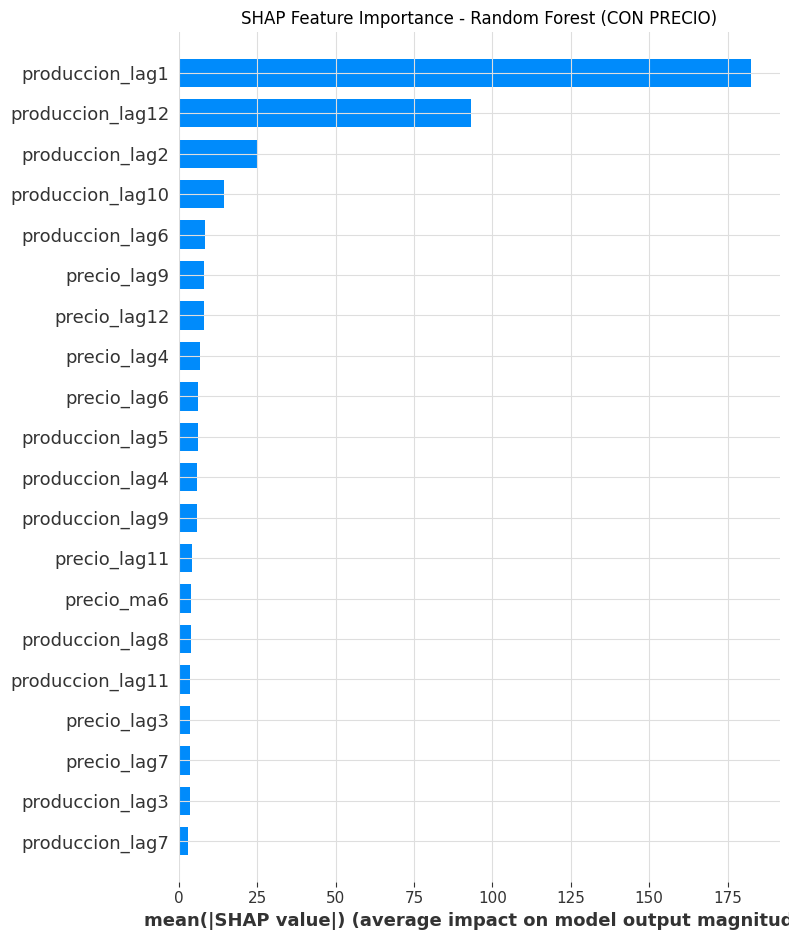

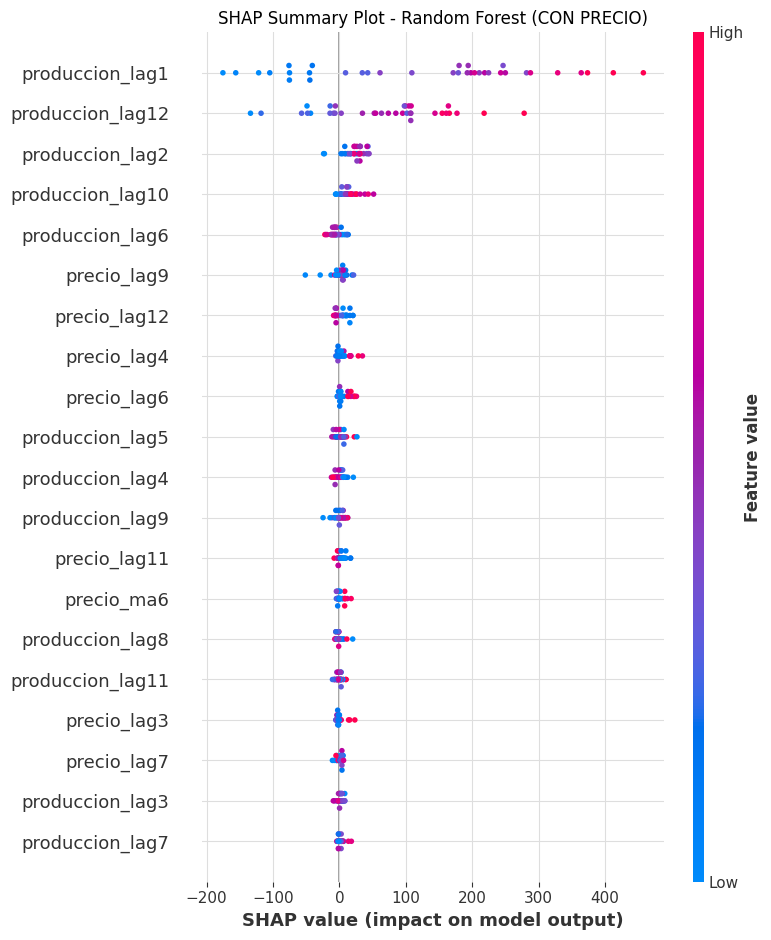


MÉTRICAS FINALES DEL MODELO ÓPTIMO (modelo_3)
Modelo: Random Forest
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Score CV (MAE): 178.7731

MÉTRICAS DE ENTRENAMIENTO:
AIC Train: 9924.81
BIC Train: 21639.21
RMSE Train: 91.5634

MÉTRICAS DE PRUEBA:
MSE Test: 7154.751599
MAE Test: 64.8453
RMSE Test: 84.5858
MAPE Test: 1.57%

RESUMEN: MODELO CON VARIABLE EXÓGENA 'PRECIO'
✅ Total de features utilizadas: 29
✅ Lags de producción: 12
✅ Lags de precio: 12
✅ Features adicionales de precio: precio_actual, precio_ma3, precio_ma6, precio_diff, precio_pct_change
✅ Observaciones utilizadas: 341
✅ Mejor modelo: Random Forest con RMSE Test: 84.5858


In [22]:
# Modelos de Machine Learning: Random Forest, XGBoost y LightGBM
# CON VARIABLE EXÓGENA: PRECIO
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Función para calcular AIC y BIC para modelos de ML
def calculate_aic_bic(y_true, y_pred, n_params):
    """
    Calcula AIC y BIC para modelos de ML
    n_params: número de parámetros del modelo
    """
    n = len(y_true)
    mse = mean_squared_error(y_true, y_pred)
    log_likelihood = -n/2 * np.log(2 * np.pi * mse) - n/2
    
    aic = 2 * n_params - 2 * log_likelihood
    bic = np.log(n) * n_params - 2 * log_likelihood
    
    return aic, bic

# Función para entrenar y evaluar modelos
def entrenar_evaluar_modelo(modelo, param_grid, X, y, nombre_modelo):
    """
    Entrena y evalúa un modelo con GridSearchCV
    """
    print(f"\n{'='*60}")
    print(f"ENTRENANDO: {nombre_modelo}")
    print(f"{'='*60}")
    
    # GridSearchCV con validación cruzada temporal
    tscv = TimeSeriesSplit(n_splits=5, test_size=12)
    grid = GridSearchCV(modelo, param_grid, cv=tscv, scoring='neg_mean_absolute_error', 
                       n_jobs=-1, verbose=1)
    grid.fit(X, y)
    
    # División train/test
    test_size = int(np.ceil(len(X) * 0.10))
    X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
    y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]
    
    # Predicciones
    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    
    # Calcular número de parámetros (aproximación)
    if 'RandomForest' in str(type(best_model)):
        n_nodes_per_tree = np.mean([tree.tree_.node_count for tree in best_model.estimators_])
        n_params = int(best_model.n_estimators * n_nodes_per_tree * 0.1)
    elif 'XGB' in str(type(best_model)):
        n_params = int(best_model.n_estimators * 50)  # Aproximación para XGBoost
    elif 'LGB' in str(type(best_model)):
        n_params = int(best_model.n_estimators * 40)  # Aproximación para LightGBM
    else:
        n_params = 100  # Default
    
    # Métricas de Train
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    aic_train, bic_train = calculate_aic_bic(y_train, y_pred_train, n_params)
    
    # Métricas de Test
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    
    # Crear diccionario con resultados
    resultado_modelo = {
        'Modelo': nombre_modelo,
        'Mejores_Hiperparametros': grid.best_params_,
        'Modelo_Entrenado': best_model,
        'Score_CV': -grid.best_score_,  # Convertir a positivo (era negativo por scoring)
        
        # Métricas de Train
        'AIC_Train': aic_train,
        'BIC_Train': bic_train,
        'RMSE_Train': rmse_train,
        
        # Métricas de Test
        'MSE_Test': mse_test,
        'MAE_Test': mae_test,
        'RMSE_Test': rmse_test,
        'MAPE_Test': mape_test,
        
        # Datos adicionales
        'Predicciones_Train': y_pred_train,
        'Predicciones_Test': y_pred_test,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }
    
    # Mostrar resultados
    print(f"Mejores hiperparámetros: {grid.best_params_}")
    print(f"Score CV (MAE): {-grid.best_score_:.4f}")
    print("\nMÉTRICAS DE ENTRENAMIENTO:")
    print(f"AIC Train: {aic_train:.2f}")
    print(f"BIC Train: {bic_train:.2f}")
    print(f"RMSE Train: {rmse_train:.4f}")
    print("\nMÉTRICAS DE PRUEBA:")
    print(f"MSE Test: {mse_test:.6f}")
    print(f"MAE Test: {mae_test:.4f}")
    print(f"RMSE Test: {rmse_test:.4f}")
    print(f"MAPE Test: {mape_test:.2f}%")
    
    return resultado_modelo

# 1. Crear variables lag CON variable exógena "precio"
def create_lagged_features(df, lags=12):
    """
    Crea variables lag tanto para producción como para precio (variable exógena)
    """
    # Incluir tanto producción como precio
    data = df[['produccion', 'precio']].copy()
    
    # Crear lags para producción
    for lag in range(1, lags+1):
        data[f'produccion_lag{lag}'] = data['produccion'].shift(lag)
    
    # Crear lags para precio (variable exógena)
    for lag in range(1, lags+1):
        data[f'precio_lag{lag}'] = data['precio'].shift(lag)
    
    # Agregar el precio actual (lag 0) como feature
    data['precio_actual'] = data['precio']
    
    # Crear algunas features adicionales con precio
    data['precio_ma3'] = data['precio'].rolling(window=3).mean()  # Media móvil 3 períodos
    data['precio_ma6'] = data['precio'].rolling(window=6).mean()  # Media móvil 6 períodos
    data['precio_diff'] = data['precio'].diff()  # Diferencia del precio
    data['precio_pct_change'] = data['precio'].pct_change()  # Cambio porcentual del precio
    
    # Eliminar la columna original de precio (ya tenemos precio_actual)
    data = data.drop(['precio'], axis=1)
    
    # Eliminar filas con NaN
    data = data.dropna()
    
    return data

lags = 12
data_ml = create_lagged_features(df_merged, lags)
X = data_ml.drop('produccion', axis=1)
y = data_ml['produccion']

print(f"Datos preparados: {X.shape[0]} observaciones, {X.shape[1]} features")
print("\nFeatures incluidas:")
print(f"- Lags de producción: {lags}")
print(f"- Lags de precio: {lags}")
print("- Variables adicionales de precio: precio_actual, precio_ma3, precio_ma6, precio_diff, precio_pct_change")
print(f"\nPrimeras 5 columnas de X: {list(X.columns[:5])}")
print(f"Últimas 5 columnas de X: {list(X.columns[-5:])}")

# 2. DEFINIR MODELOS Y PARÁMETROS

# Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# LightGBM
lgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 1.0]
}

# 3. ENTRENAR TODOS LOS MODELOS

# Random Forest 
modelo_rf = entrenar_evaluar_modelo(
    RandomForestRegressor(random_state=42),
    rf_params, X, y, 'Random Forest'
)

# XGBoost
modelo_xgb = entrenar_evaluar_modelo(
    xgb.XGBRegressor(random_state=42, objective='reg:squarederror'),
    xgb_params, X, y, 'XGBoost'
)

# LightGBM
modelo_lgb = entrenar_evaluar_modelo(
    lgb.LGBMRegressor(random_state=42, objective='regression', verbose=-1),
    lgb_params, X, y, 'LightGBM'
)

# 4. IDENTIFICAR EL MEJOR MODELO BASADO EN RMSE TEST
print(f"\n{'='*80}")
print("COMPARACIÓN Y SELECCIÓN DEL MEJOR MODELO")
print(f"{'='*80}")

modelos_evaluados = {
    'Random Forest': modelo_rf,
    'XGBoost': modelo_xgb, 
    'LightGBM': modelo_lgb
}

# Encontrar el modelo con menor RMSE Test
mejor_rmse = float('inf')
mejor_modelo_nombre = None
modelo_3 = None

for nombre, modelo in modelos_evaluados.items():
    rmse_test = modelo['RMSE_Test']
    print(f"{nombre}: RMSE Test = {rmse_test:.4f}")
    
    if rmse_test < mejor_rmse:
        mejor_rmse = rmse_test
        mejor_modelo_nombre = nombre
        modelo_3 = modelo.copy()  # Guardar como modelo_3

print(f"\n🏆 MEJOR MODELO SELECCIONADO: {mejor_modelo_nombre}")
print(f"🎯 RMSE Test: {mejor_rmse:.4f}")

# 5. ANÁLISIS DE IMPORTANCIA DE FEATURES
print(f"\n{'='*60}")
print("ANÁLISIS DE IMPORTANCIA DE FEATURES")
print(f"{'='*60}")

# Obtener importancia de features del mejor modelo
if hasattr(modelo_3['Modelo_Entrenado'], 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': modelo_3['Modelo_Entrenado'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 features más importantes:")
    print(feature_importance.head(10).to_string(index=False))
    
    # Separar importancia por tipo de variable
    precio_features = feature_importance[feature_importance['feature'].str.contains('precio')]
    produccion_features = feature_importance[feature_importance['feature'].str.contains('produccion')]
    
    print(f"\nImportancia total de variables de PRECIO: {precio_features['importance'].sum():.4f}")
    print(f"Importancia total de variables de PRODUCCIÓN: {produccion_features['importance'].sum():.4f}")

# 6. SHAP ANALYSIS PARA EL MEJOR MODELO (modelo_3)
print(f"\nGenerando análisis SHAP para {modelo_3['Modelo']}...")

try:
    if 'RandomForest' in str(type(modelo_3['Modelo_Entrenado'])):
        explainer = shap.TreeExplainer(modelo_3['Modelo_Entrenado'])
    elif 'XGB' in str(type(modelo_3['Modelo_Entrenado'])):
        explainer = shap.TreeExplainer(modelo_3['Modelo_Entrenado'])
    elif 'LGB' in str(type(modelo_3['Modelo_Entrenado'])):
        explainer = shap.TreeExplainer(modelo_3['Modelo_Entrenado'])
    
    shap_values = explainer.shap_values(modelo_3['X_test'])
    
    print("Generando gráficos SHAP...")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, modelo_3['X_test'], plot_type="bar", show=False)
    plt.title(f'SHAP Feature Importance - {modelo_3["Modelo"]} (CON PRECIO)')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, modelo_3['X_test'], show=False)
    plt.title(f'SHAP Summary Plot - {modelo_3["Modelo"]} (CON PRECIO)')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error generando gráficos SHAP: {e}")

# 7. MOSTRAR MÉTRICAS FINALES DEL MEJOR MODELO
print(f"\n{'='*80}")
print("MÉTRICAS FINALES DEL MODELO ÓPTIMO (modelo_3)")
print(f"{'='*80}")
print(f"Modelo: {modelo_3['Modelo']}")
print(f"Mejores hiperparámetros: {modelo_3['Mejores_Hiperparametros']}")
print(f"Score CV (MAE): {modelo_3['Score_CV']:.4f}")
print("\nMÉTRICAS DE ENTRENAMIENTO:")
print(f"AIC Train: {modelo_3['AIC_Train']:.2f}")
print(f"BIC Train: {modelo_3['BIC_Train']:.2f}")
print(f"RMSE Train: {modelo_3['RMSE_Train']:.4f}")
print("\nMÉTRICAS DE PRUEBA:")
print(f"MSE Test: {modelo_3['MSE_Test']:.6f}")
print(f"MAE Test: {modelo_3['MAE_Test']:.4f}")
print(f"RMSE Test: {modelo_3['RMSE_Test']:.4f}")
print(f"MAPE Test: {modelo_3['MAPE_Test']:.2f}%")

print(f"\n{'='*80}")
print("RESUMEN: MODELO CON VARIABLE EXÓGENA 'PRECIO'")
print(f"{'='*80}")
print(f"✅ Total de features utilizadas: {X.shape[1]}")
print(f"✅ Lags de producción: {lags}")
print(f"✅ Lags de precio: {lags}")
print("✅ Features adicionales de precio: precio_actual, precio_ma3, precio_ma6, precio_diff, precio_pct_change")
print(f"✅ Observaciones utilizadas: {X.shape[0]}")
print(f"✅ Mejor modelo: {modelo_3['Modelo']} con RMSE Test: {modelo_3['RMSE_Test']:.4f}")

Agregar la variable exógena aumenta la complejidad pero no la precisión del modelo

> Por lo tanto, el modelo de Machine Learning óptimo es el modelo_1, un Random Forest sin variable exógena

#### 5.2 Modelos Deep Learning

**LSTM, MLP, RNN, NNAR**

**Características**:
- Son redes neuronales diseñadas para aprender patrones complejos y dependencias a largo plazo en secuencias.
- Pueden modelar relaciones temporales sin necesidad de crear manualmente muchas variables lag.
- Requieren más datos y poder de cómputo.

**Ventajas**: Capturan patrones temporales complejos, estacionalidad, tendencia y no linealidades.

**Desventajas**: Menos interpretables, requieren tuning (ajuste de hiperparámetros) y más datos.

##### 5.2.1 Sin variable exógena

In [11]:
# Modelos de Deep Learning: LSTM, MLP, RNN, NNAR
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configurar GPU si está disponible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Función para calcular AIC y BIC para modelos de DL
def calculate_aic_bic_dl(y_true, y_pred, n_params):
    """
    Calcula AIC y BIC para modelos de Deep Learning
    n_params: número de parámetros del modelo
    """
    n = len(y_true)
    mse = mean_squared_error(y_true, y_pred)
    log_likelihood = -n/2 * np.log(2 * np.pi * mse) - n/2
    
    aic = 2 * n_params - 2 * log_likelihood
    bic = np.log(n) * n_params - 2 * log_likelihood
    
    return aic, bic

# Función para preparar datos para modelos de secuencia
def create_sequences(data, seq_length):
    """
    Crea secuencias para modelos LSTM/RNN
    """
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Función para preparar datos según el tipo de modelo
def prepare_data_for_model(df, model_type, seq_length=12, lags=12):
    """
    Prepara los datos según el tipo de modelo
    """
    data = df[['produccion']].copy()
    
    if model_type in ['LSTM', 'RNN']:
        # Para modelos de secuencia
        scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data)
        X, y = create_sequences(data_scaled, seq_length)
        
        # División train/test
        test_size = int(np.ceil(len(X) * 0.10))
        X_train, X_test = X[:-test_size], X[-test_size:]
        y_train, y_test = y[:-test_size], y[-test_size:]
        
        return X_train, X_test, y_train, y_test, scaler
    
    else:  # MLP, NNAR
        # Crear variables lag
        for lag in range(1, lags+1):
            data[f'produccion_lag{lag}'] = data['produccion'].shift(lag)
        data = data.dropna()
        
        X = data.drop('produccion', axis=1)
        y = data['produccion']
        
        # Normalizar
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        
        X_scaled = scaler_X.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
        
        # División train/test
        test_size = int(np.ceil(len(X_scaled) * 0.10))
        X_train, X_test = X_scaled[:-test_size], X_scaled[-test_size:]
        y_train, y_test = y_scaled[:-test_size], y_scaled[-test_size:]
        
        return X_train, X_test, y_train, y_test, (scaler_X, scaler_y)

# Definir arquitecturas de modelos
class LSTMTuner(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        model = keras.Sequential()
        
        # Primera capa LSTM
        model.add(layers.LSTM(
            units=hp.Int('lstm_units_1', 32, 128, step=32),
            return_sequences=True,
            input_shape=self.input_shape
        ))
        model.add(layers.Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
        
        # Segunda capa LSTM
        if hp.Boolean('add_lstm_layer'):
            model.add(layers.LSTM(
                units=hp.Int('lstm_units_2', 16, 64, step=16),
                return_sequences=False
            ))
            model.add(layers.Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
        else:
            model.add(layers.LSTM(32, return_sequences=False))
        
        # Capas densas
        model.add(layers.Dense(
            units=hp.Int('dense_units', 16, 64, step=16),
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float('dropout_dense', 0.1, 0.3, step=0.1)))
        
        model.add(layers.Dense(1))
        
        model.compile(
            optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
            loss='mse',
            metrics=['mae']
        )
        
        return model

class MLPTuner(kt.HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim
    
    def build(self, hp):
        model = keras.Sequential()
        
        # Capa de entrada
        model.add(layers.Dense(
            units=hp.Int('dense_1', 64, 256, step=32),
            activation='relu',
            input_dim=self.input_dim
        ))
        model.add(layers.Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
        
        # Capas ocultas
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(layers.Dense(
                units=hp.Int(f'dense_{i+2}', 32, 128, step=32),
                activation='relu'
            ))
            model.add(layers.Dropout(hp.Float(f'dropout_{i+2}', 0.1, 0.4, step=0.1)))
        
        # Capa de salida
        model.add(layers.Dense(1))
        
        model.compile(
            optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
            loss='mse',
            metrics=['mae']
        )
        
        return model

class RNNTuner(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        model = keras.Sequential()
        
        # Primera capa RNN
        model.add(layers.SimpleRNN(
            units=hp.Int('rnn_units_1', 32, 128, step=32),
            return_sequences=hp.Boolean('return_sequences'),
            input_shape=self.input_shape
        ))
        model.add(layers.Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
        
        # Segunda capa RNN (condicional)
        if hp.Boolean('add_rnn_layer') and hp.Boolean('return_sequences'):
            model.add(layers.SimpleRNN(
                units=hp.Int('rnn_units_2', 16, 64, step=16),
                return_sequences=False
            ))
            model.add(layers.Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
        
        # Capas densas
        model.add(layers.Dense(
            units=hp.Int('dense_units', 16, 64, step=16),
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float('dropout_dense', 0.1, 0.3, step=0.1)))
        
        model.add(layers.Dense(1))
        
        model.compile(
            optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
            loss='mse',
            metrics=['mae']
        )
        
        return model

class NNARTuner(kt.HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim
    
    def build(self, hp):
        model = keras.Sequential()
        
        # Arquitectura específica para NNAR (Neural Network Autoregression)
        model.add(layers.Dense(
            units=hp.Int('nnar_units_1', 10, 25, step=5),
            activation='relu',
            input_dim=self.input_dim
        ))
        model.add(layers.Dropout(hp.Float('dropout_1', 0.0, 0.3, step=0.1)))
        
        if hp.Boolean('add_hidden_layer'):
            model.add(layers.Dense(
                units=hp.Int('nnar_units_2', 5, 15, step=5),
                activation='relu'
            ))
            model.add(layers.Dropout(hp.Float('dropout_2', 0.0, 0.2, step=0.1)))
        
        model.add(layers.Dense(1))
        
        model.compile(
            optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
            loss='mse',
            metrics=['mae']
        )
        
        return model

# Función principal para entrenar y evaluar modelos de DL
def entrenar_evaluar_modelo_dl(tuner_class, X_train, X_test, y_train, y_test, scaler, nombre_modelo, input_shape_or_dim):
    """
    Entrena y evalúa un modelo de Deep Learning con KerasTuner
    """
    print(f"\n{'='*60}")
    print(f"ENTRENANDO: {nombre_modelo}")
    print(f"{'='*60}")
    
    # Crear el tuner
    tuner = kt.RandomSearch(
        tuner_class(input_shape_or_dim),
        objective='val_loss',
        max_trials=20,
        directory=f'tuner_dir_{nombre_modelo}',
        project_name=f'{nombre_modelo}_tuning'
    )
    
    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # Búsqueda de hiperparámetros
    print("Iniciando búsqueda de hiperparámetros...")
    tuner.search(
        X_train, y_train,
        epochs=50,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Obtener el mejor modelo
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # Entrenar el mejor modelo con todos los datos de entrenamiento
    print("Entrenando modelo final...")
    history = best_model.fit(
        X_train, y_train,
        epochs=100,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Predicciones
    y_pred_train = best_model.predict(X_train, verbose=0).flatten()
    y_pred_test = best_model.predict(X_test, verbose=0).flatten()
    
    # Desnormalizar si es necesario
    if nombre_modelo in ['LSTM', 'RNN']:
        y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
        y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_train_orig = scaler.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
        y_pred_test_orig = scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
    else:  # MLP, NNAR
        scaler_X, scaler_y = scaler
        y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
        y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_train_orig = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
        y_pred_test_orig = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
    
    # Calcular número de parámetros
    n_params = best_model.count_params()
    
    # Métricas de Train
    rmse_train = np.sqrt(mean_squared_error(y_train_orig, y_pred_train_orig))
    aic_train, bic_train = calculate_aic_bic_dl(y_train_orig, y_pred_train_orig, n_params)
    
    # Métricas de Test
    mse_test = mean_squared_error(y_test_orig, y_pred_test_orig)
    mae_test = mean_absolute_error(y_test_orig, y_pred_test_orig)
    rmse_test = np.sqrt(mse_test)
    mape_test = mean_absolute_percentage_error(y_test_orig, y_pred_test_orig) * 100
    
    # Crear diccionario con resultados
    resultado_modelo = {
        'Modelo': nombre_modelo,
        'Mejores_Hiperparametros': best_hps.values,
        'Modelo_Entrenado': best_model,
        'Historia_Entrenamiento': history.history,
        'N_Parametros': n_params,
        
        # Métricas de Train
        'AIC_Train': aic_train,
        'BIC_Train': bic_train,
        'RMSE_Train': rmse_train,
        
        # Métricas de Test
        'MSE_Test': mse_test,
        'MAE_Test': mae_test,
        'RMSE_Test': rmse_test,
        'MAPE_Test': mape_test,
        
        # Datos adicionales
        'Predicciones_Train': y_pred_train_orig,
        'Predicciones_Test': y_pred_test_orig,
        'y_train': y_train_orig,
        'y_test': y_test_orig,
        'Scaler': scaler
    }
    
    # Mostrar resultados
    print(f"Mejores hiperparámetros: {best_hps.values}")
    print(f"Número de parámetros: {n_params:,}")
    print("\nMÉTRICAS DE ENTRENAMIENTO:")
    print(f"AIC Train: {aic_train:.2f}")
    print(f"BIC Train: {bic_train:.2f}")
    print(f"RMSE Train: {rmse_train:.4f}")
    print("\nMÉTRICAS DE PRUEBA:")
    print(f"MSE Test: {mse_test:.6f}")
    print(f"MAE Test: {mae_test:.4f}")
    print(f"RMSE Test: {rmse_test:.4f}")
    print(f"MAPE Test: {mape_test:.2f}%")
    
    return resultado_modelo

# ============================================================================
# EJECUTAR ENTRENAMIENTO DE MODELOS DE DEEP LEARNING
# ============================================================================

# Asumir que df_merged existe (debe venir del código anterior)
# df_merged debe contener la columna 'produccion'

print("Preparando datos para modelos de Deep Learning...")

# Preparar datos para cada tipo de modelo
seq_length = 12
lags = 12

# Datos para LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm, scaler_lstm = prepare_data_for_model(
    df_merged, 'LSTM', seq_length=seq_length
)

# Datos para RNN
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn, scaler_rnn = prepare_data_for_model(
    df_merged, 'RNN', seq_length=seq_length
)

# Datos para MLP
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp, scaler_mlp = prepare_data_for_model(
    df_merged, 'MLP', lags=lags
)

# Datos para NNAR
X_train_nnar, X_test_nnar, y_train_nnar, y_test_nnar, scaler_nnar = prepare_data_for_model(
    df_merged, 'NNAR', lags=lags
)

print(f"Datos LSTM: {X_train_lstm.shape} -> {y_train_lstm.shape}")
print(f"Datos RNN: {X_train_rnn.shape} -> {y_train_rnn.shape}")
print(f"Datos MLP: {X_train_mlp.shape} -> {y_train_mlp.shape}")
print(f"Datos NNAR: {X_train_nnar.shape} -> {y_train_nnar.shape}")

# Entrenar todos los modelos
modelos_dl = {}

# LSTM
modelos_dl['LSTM'] = entrenar_evaluar_modelo_dl(
    LSTMTuner, X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm, 
    scaler_lstm, 'LSTM', (seq_length, 1)
)

# RNN
modelos_dl['RNN'] = entrenar_evaluar_modelo_dl(
    RNNTuner, X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn,
    scaler_rnn, 'RNN', (seq_length, 1)
)

# MLP
modelos_dl['MLP'] = entrenar_evaluar_modelo_dl(
    MLPTuner, X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp,
    scaler_mlp, 'MLP', X_train_mlp.shape[1]
)

# NNAR
modelos_dl['NNAR'] = entrenar_evaluar_modelo_dl(
    NNARTuner, X_train_nnar, X_test_nnar, y_train_nnar, y_test_nnar,
    scaler_nnar, 'NNAR', X_train_nnar.shape[1]
)

# IDENTIFICAR EL MEJOR MODELO BASADO EN RMSE TEST
print(f"\n{'='*80}")
print("COMPARACIÓN Y SELECCIÓN DEL MEJOR MODELO DE DEEP LEARNING")
print(f"{'='*80}")

# Encontrar el modelo con menor RMSE Test
mejor_rmse_dl = float('inf')
mejor_modelo_nombre_dl = None
modelo_4 = None

for nombre, modelo in modelos_dl.items():
    rmse_test = modelo['RMSE_Test']
    n_params = modelo['N_Parametros']
    print(f"{nombre}: RMSE Test = {rmse_test:.4f}, Parámetros = {n_params:,}")
    
    if rmse_test < mejor_rmse_dl:
        mejor_rmse_dl = rmse_test
        mejor_modelo_nombre_dl = nombre
        modelo_4 = modelo.copy()  # Guardar como modelo_4

print(f"\n🏆 MEJOR MODELO DE DEEP LEARNING SELECCIONADO: {mejor_modelo_nombre_dl}")
print(f"🎯 RMSE Test: {mejor_rmse_dl:.4f}")
print(f"📊 Número de parámetros: {modelo_4['N_Parametros']:,}")

# GRÁFICOS DE ENTRENAMIENTO PARA EL MEJOR MODELO
print(f"\nGenerando gráficos de entrenamiento para {modelo_4['Modelo']}...")

try:
    history = modelo_4['Historia_Entrenamiento']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Pérdida
    ax1.plot(history['loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title(f'Model Loss - {modelo_4["Modelo"]}')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # MAE
    ax2.plot(history['mae'], label='Training MAE')
    ax2.plot(history['val_mae'], label='Validation MAE')
    ax2.set_title(f'Model MAE - {modelo_4["Modelo"]}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Gráfico de predicciones vs reales
    plt.figure(figsize=(12, 6))
    plt.plot(modelo_4['y_test'], label='Real', alpha=0.7)
    plt.plot(modelo_4['Predicciones_Test'], label='Predicción', alpha=0.7)
    plt.title(f'Predicciones vs Valores Reales - {modelo_4["Modelo"]}')
    plt.xlabel('Tiempo')
    plt.ylabel('Producción')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error generando gráficos: {e}")

# MOSTRAR MÉTRICAS FINALES DEL MEJOR MODELO (modelo_4)
print(f"\n{'='*80}")
print("MÉTRICAS FINALES DEL MODELO ÓPTIMO DE DEEP LEARNING (modelo_4)")
print(f"{'='*80}")
print(f"Modelo: {modelo_4['Modelo']}")
print(f"Mejores hiperparámetros: {modelo_4['Mejores_Hiperparametros']}")
print(f"Número de parámetros: {modelo_4['N_Parametros']:,}")
print("\nMÉTRICAS DE ENTRENAMIENTO:")
print(f"AIC Train: {modelo_4['AIC_Train']:.2f}")
print(f"BIC Train: {modelo_4['BIC_Train']:.2f}")
print(f"RMSE Train: {modelo_4['RMSE_Train']:.4f}")
print("\nMÉTRICAS DE PRUEBA:")
print(f"MSE Test: {modelo_4['MSE_Test']:.6f}")
print(f"MAE Test: {modelo_4['MAE_Test']:.4f}")
print(f"RMSE Test: {modelo_4['RMSE_Test']:.4f}")
print(f"MAPE Test: {modelo_4['MAPE_Test']:.2f}%")

print(f"\n✅ Modelo óptimo de Deep Learning guardado en variable 'modelo_4'")
print(f"📈 Todos los modelos DL disponibles en diccionario 'modelos_dl'")

ModuleNotFoundError: No module named 'tensorflow'

##### 5.2.2 Con variable exógena

Trial 20 Complete [00h 00m 04s]
val_loss: 0.005544286221265793

Best val_loss So Far: 0.004136511590331793
Total elapsed time: 00h 01m 40s
Entrenando modelo final...
Mejores hiperparámetros: {'nnar_units_1': 25, 'dropout_1': 0.0, 'add_hidden_layer': False, 'learning_rate': 0.000254400127046171, 'nnar_units_2': 20, 'dropout_2': 0.0}
Número de parámetros: 676

MÉTRICAS DE ENTRENAMIENTO:
AIC Train: 5565.83
BIC Train: 8082.98
RMSE Train: 236.6088

MÉTRICAS DE PRUEBA:
MSE Test: 57842.422922
MAE Test: 182.8157
RMSE Test: 240.5045
MAPE Test: 4.34%

COMPARACIÓN Y SELECCIÓN DEL MEJOR MODELO DE DEEP LEARNING CON VARIABLE EXÓGENA
LSTM_Exog: RMSE Test = 227.8512, Parámetros = 77,217
RNN_Exog: RMSE Test = 207.4805, Parámetros = 8,513
MLP_Exog: RMSE Test = 202.1616, Parámetros = 31,425
NNAR_Exog: RMSE Test = 240.5045, Parámetros = 676

🏆 MEJOR MODELO DE DEEP LEARNING CON VARIABLE EXÓGENA SELECCIONADO: MLP_Exog
🎯 RMSE Test: 202.1616
📊 Número de parámetros: 31,425
🔄 Variable exógena incluida: precio



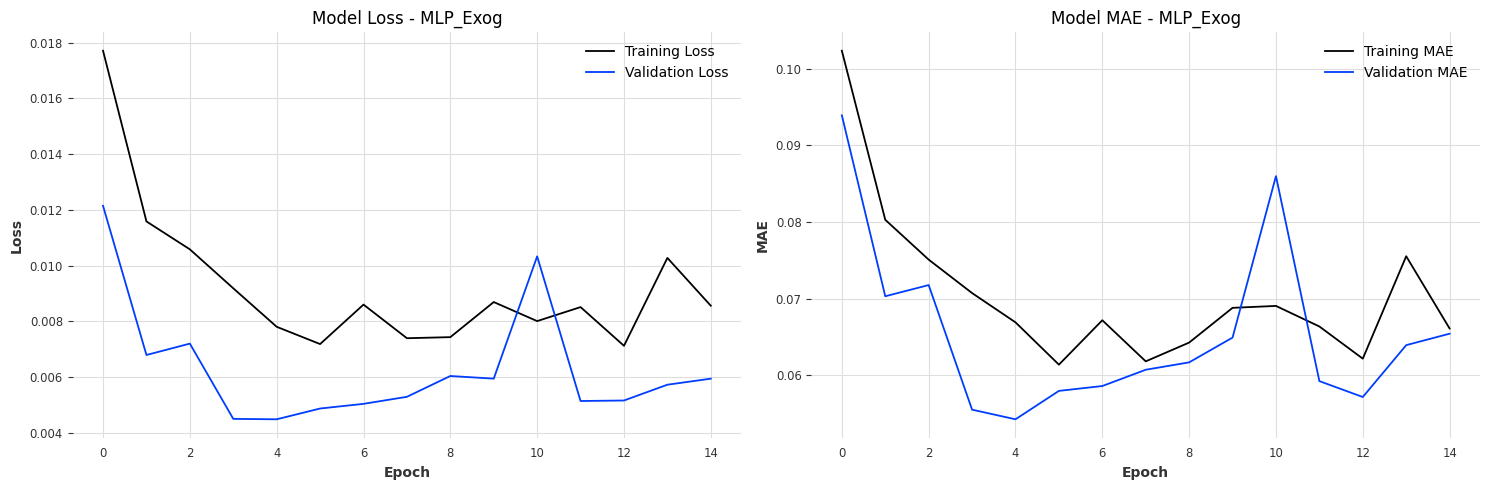

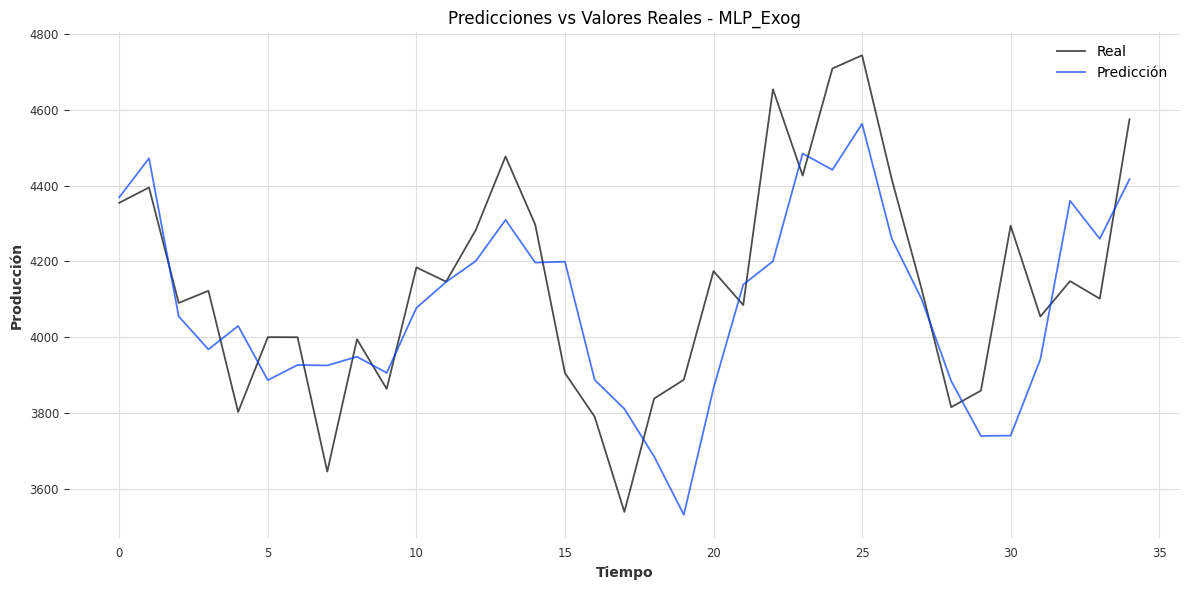


MÉTRICAS FINALES DEL MODELO ÓPTIMO DE DEEP LEARNING CON VARIABLE EXÓGENA (modelo_5)
Modelo: MLP_Exog
Variable exógena: precio
Mejores hiperparámetros: {'dense_1': 256, 'dropout_1': 0.1, 'num_layers': 1, 'dense_2': 96, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.003449485159787074, 'dense_3': 128, 'dropout_3': 0.1}
Número de parámetros: 31,425

MÉTRICAS DE ENTRENAMIENTO:
AIC Train: 66933.53
BIC Train: 183947.20
RMSE Train: 191.2349

MÉTRICAS DE PRUEBA:
MSE Test: 40869.317649
MAE Test: 159.5112
RMSE Test: 202.1616
MAPE Test: 3.86%

✅ Modelo óptimo de Deep Learning con variable exógena guardado en variable 'modelo_5'
📈 Todos los modelos DL con variable exógena disponibles en diccionario 'modelos_dl_exog'


In [ ]:
# Modelos de Deep Learning: LSTM, MLP, RNN, NNAR con Variable Exógena
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configurar GPU si está disponible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Función para calcular AIC y BIC para modelos de DL
def calculate_aic_bic_dl(y_true, y_pred, n_params):
    """
    Calcula AIC y BIC para modelos de Deep Learning
    n_params: número de parámetros del modelo
    """
    n = len(y_true)
    mse = mean_squared_error(y_true, y_pred)
    log_likelihood = -n/2 * np.log(2 * np.pi * mse) - n/2
    
    aic = 2 * n_params - 2 * log_likelihood
    bic = np.log(n) * n_params - 2 * log_likelihood
    
    return aic, bic

# Función para preparar datos para modelos de secuencia con variable exógena
def create_sequences_with_exog(data_prod, data_precio, seq_length):
    """
    Crea secuencias para modelos LSTM/RNN incluyendo variable exógena
    """
    X_prod, X_precio, y = [], [], []
    for i in range(seq_length, len(data_prod)):
        X_prod.append(data_prod[i-seq_length:i])
        X_precio.append(data_precio[i-seq_length:i])
        y.append(data_prod[i])
    
    # Combinar producción y precio en una sola matriz de features
    X_combined = []
    for i in range(len(X_prod)):
        # Combinar producción y precio para cada timestep
        combined_seq = np.column_stack([X_prod[i], X_precio[i]])
        X_combined.append(combined_seq)
    
    return np.array(X_combined), np.array(y)

# Función para preparar datos según el tipo de modelo con variable exógena
def prepare_data_for_model_with_exog(df, model_type, seq_length=12, lags=12):
    """
    Prepara los datos según el tipo de modelo incluyendo variable exógena 'precio'
    """
    # Verificar que existan las columnas necesarias
    if 'produccion' not in df.columns or 'precio' not in df.columns:
        raise ValueError("El DataFrame debe contener las columnas 'produccion' y 'precio'")
    
    data = df[['produccion', 'precio']].copy()
    
    if model_type in ['LSTM', 'RNN']:
        # Para modelos de secuencia
        scaler_prod = MinMaxScaler()
        scaler_precio = MinMaxScaler()
        
        data_prod_scaled = scaler_prod.fit_transform(data[['produccion']])
        data_precio_scaled = scaler_precio.fit_transform(data[['precio']])
        
        X, y = create_sequences_with_exog(
            data_prod_scaled.flatten(), 
            data_precio_scaled.flatten(), 
            seq_length
        )
        
        # División train/test
        test_size = int(np.ceil(len(X) * 0.10))
        X_train, X_test = X[:-test_size], X[-test_size:]
        y_train, y_test = y[:-test_size], y[-test_size:]
        
        return X_train, X_test, y_train, y_test, (scaler_prod, scaler_precio)
    
    else:  # MLP, NNAR
        # Crear variables lag para producción
        for lag in range(1, lags+1):
            data[f'produccion_lag{lag}'] = data['produccion'].shift(lag)
        
        # Crear variables lag para precio
        for lag in range(1, lags+1):
            data[f'precio_lag{lag}'] = data['precio'].shift(lag)
        
        data = data.dropna()
        
        X = data.drop('produccion', axis=1)
        y = data['produccion']
        
        # Normalizar
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        
        X_scaled = scaler_X.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
        
        # División train/test
        test_size = int(np.ceil(len(X_scaled) * 0.10))
        X_train, X_test = X_scaled[:-test_size], X_scaled[-test_size:]
        y_train, y_test = y_scaled[:-test_size], y_scaled[-test_size:]
        
        return X_train, X_test, y_train, y_test, (scaler_X, scaler_y)

# Definir arquitecturas de modelos modificadas para variable exógena
class LSTMTunerExog(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape  # (seq_length, 2) para producción y precio
    
    def build(self, hp):
        model = keras.Sequential()
        
        # Primera capa LSTM
        model.add(layers.LSTM(
            units=hp.Int('lstm_units_1', 32, 128, step=32),
            return_sequences=True,
            input_shape=self.input_shape
        ))
        model.add(layers.Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
        
        # Segunda capa LSTM
        if hp.Boolean('add_lstm_layer'):
            model.add(layers.LSTM(
                units=hp.Int('lstm_units_2', 16, 64, step=16),
                return_sequences=False
            ))
            model.add(layers.Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
        else:
            model.add(layers.LSTM(32, return_sequences=False))
        
        # Capas densas
        model.add(layers.Dense(
            units=hp.Int('dense_units', 16, 64, step=16),
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float('dropout_dense', 0.1, 0.3, step=0.1)))
        
        model.add(layers.Dense(1))
        
        model.compile(
            optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
            loss='mse',
            metrics=['mae']
        )
        
        return model

class MLPTunerExog(kt.HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim  # Incluye lags de producción y precio
    
    def build(self, hp):
        model = keras.Sequential()
        
        # Capa de entrada
        model.add(layers.Dense(
            units=hp.Int('dense_1', 64, 256, step=32),
            activation='relu',
            input_dim=self.input_dim
        ))
        model.add(layers.Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
        
        # Capas ocultas
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(layers.Dense(
                units=hp.Int(f'dense_{i+2}', 32, 128, step=32),
                activation='relu'
            ))
            model.add(layers.Dropout(hp.Float(f'dropout_{i+2}', 0.1, 0.4, step=0.1)))
        
        # Capa de salida
        model.add(layers.Dense(1))
        
        model.compile(
            optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
            loss='mse',
            metrics=['mae']
        )
        
        return model

class RNNTunerExog(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape  # (seq_length, 2) para producción y precio
    
    def build(self, hp):
        model = keras.Sequential()
        
        # Primera capa RNN
        model.add(layers.SimpleRNN(
            units=hp.Int('rnn_units_1', 32, 128, step=32),
            return_sequences=hp.Boolean('return_sequences'),
            input_shape=self.input_shape
        ))
        model.add(layers.Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
        
        # Segunda capa RNN (condicional)
        if hp.Boolean('add_rnn_layer') and hp.Boolean('return_sequences'):
            model.add(layers.SimpleRNN(
                units=hp.Int('rnn_units_2', 16, 64, step=16),
                return_sequences=False
            ))
            model.add(layers.Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
        
        # Capas densas
        model.add(layers.Dense(
            units=hp.Int('dense_units', 16, 64, step=16),
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float('dropout_dense', 0.1, 0.3, step=0.1)))
        
        model.add(layers.Dense(1))
        
        model.compile(
            optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
            loss='mse',
            metrics=['mae']
        )
        
        return model

class NNARTunerExog(kt.HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim  # Incluye lags de producción y precio
    
    def build(self, hp):
        model = keras.Sequential()
        
        # Arquitectura específica para NNAR con variable exógena
        model.add(layers.Dense(
            units=hp.Int('nnar_units_1', 10, 30, step=5),
            activation='relu',
            input_dim=self.input_dim
        ))
        model.add(layers.Dropout(hp.Float('dropout_1', 0.0, 0.3, step=0.1)))
        
        if hp.Boolean('add_hidden_layer'):
            model.add(layers.Dense(
                units=hp.Int('nnar_units_2', 5, 20, step=5),
                activation='relu'
            ))
            model.add(layers.Dropout(hp.Float('dropout_2', 0.0, 0.2, step=0.1)))
        
        model.add(layers.Dense(1))
        
        model.compile(
            optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
            loss='mse',
            metrics=['mae']
        )
        
        return model

# Función principal para entrenar y evaluar modelos de DL con variable exógena
def entrenar_evaluar_modelo_dl_exog(tuner_class, X_train, X_test, y_train, y_test, scaler, nombre_modelo, input_shape_or_dim):
    """
    Entrena y evalúa un modelo de Deep Learning con KerasTuner incluyendo variable exógena
    """
    print(f"\n{'='*60}")
    print(f"ENTRENANDO: {nombre_modelo} (con variable exógena 'precio')")
    print(f"{'='*60}")
    
    # Crear el tuner
    tuner = kt.RandomSearch(
        tuner_class(input_shape_or_dim),
        objective='val_loss',
        max_trials=20,
        directory=f'tuner_dir_{nombre_modelo}_exog',
        project_name=f'{nombre_modelo}_exog_tuning'
    )
    
    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # Búsqueda de hiperparámetros
    print("Iniciando búsqueda de hiperparámetros...")
    tuner.search(
        X_train, y_train,
        epochs=50,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Obtener el mejor modelo
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # Entrenar el mejor modelo con todos los datos de entrenamiento
    print("Entrenando modelo final...")
    history = best_model.fit(
        X_train, y_train,
        epochs=100,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Predicciones
    y_pred_train = best_model.predict(X_train, verbose=0).flatten()
    y_pred_test = best_model.predict(X_test, verbose=0).flatten()
    
    # Desnormalizar si es necesario
    if nombre_modelo in ['LSTM', 'RNN']:
        scaler_prod, scaler_precio = scaler
        y_train_orig = scaler_prod.inverse_transform(y_train.reshape(-1, 1)).flatten()
        y_test_orig = scaler_prod.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_train_orig = scaler_prod.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
        y_pred_test_orig = scaler_prod.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
    else:  # MLP, NNAR
        scaler_X, scaler_y = scaler
        y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
        y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_train_orig = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
        y_pred_test_orig = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
    
    # Calcular número de parámetros
    n_params = best_model.count_params()
    
    # Métricas de Train
    rmse_train = np.sqrt(mean_squared_error(y_train_orig, y_pred_train_orig))
    aic_train, bic_train = calculate_aic_bic_dl(y_train_orig, y_pred_train_orig, n_params)
    
    # Métricas de Test
    mse_test = mean_squared_error(y_test_orig, y_pred_test_orig)
    mae_test = mean_absolute_error(y_test_orig, y_pred_test_orig)
    rmse_test = np.sqrt(mse_test)
    mape_test = mean_absolute_percentage_error(y_test_orig, y_pred_test_orig) * 100
    
    # Crear diccionario con resultados
    resultado_modelo = {
        'Modelo': f"{nombre_modelo}_Exog",
        'Mejores_Hiperparametros': best_hps.values,
        'Modelo_Entrenado': best_model,
        'Historia_Entrenamiento': history.history,
        'N_Parametros': n_params,
        'Variable_Exogena': 'precio',
        
        # Métricas de Train
        'AIC_Train': aic_train,
        'BIC_Train': bic_train,
        'RMSE_Train': rmse_train,
        
        # Métricas de Test
        'MSE_Test': mse_test,
        'MAE_Test': mae_test,
        'RMSE_Test': rmse_test,
        'MAPE_Test': mape_test,
        
        # Datos adicionales
        'Predicciones_Train': y_pred_train_orig,
        'Predicciones_Test': y_pred_test_orig,
        'y_train': y_train_orig,
        'y_test': y_test_orig,
        'Scaler': scaler
    }
    
    # Mostrar resultados
    print(f"Mejores hiperparámetros: {best_hps.values}")
    print(f"Número de parámetros: {n_params:,}")
    print("\nMÉTRICAS DE ENTRENAMIENTO:")
    print(f"AIC Train: {aic_train:.2f}")
    print(f"BIC Train: {bic_train:.2f}")
    print(f"RMSE Train: {rmse_train:.4f}")
    print("\nMÉTRICAS DE PRUEBA:")
    print(f"MSE Test: {mse_test:.6f}")
    print(f"MAE Test: {mae_test:.4f}")
    print(f"RMSE Test: {rmse_test:.4f}")
    print(f"MAPE Test: {mape_test:.2f}%")
    
    return resultado_modelo

# ============================================================================
# EJECUTAR ENTRENAMIENTO DE MODELOS DE DEEP LEARNING CON VARIABLE EXÓGENA
# ============================================================================

# Asumir que df_merged existe y contiene las columnas 'produccion' y 'precio'
# Verificar que existan las columnas necesarias
if 'produccion' not in df_merged.columns or 'precio' not in df_merged.columns:
    print("ERROR: El DataFrame debe contener las columnas 'produccion' y 'precio'")
    print(f"Columnas disponibles: {list(df_merged.columns)}")
else:
    print("Preparando datos para modelos de Deep Learning con variable exógena 'precio'...")
    
    # Preparar datos para cada tipo de modelo
    seq_length = 12
    lags = 12
    
    # Datos para LSTM con variable exógena
    X_train_lstm_exog, X_test_lstm_exog, y_train_lstm_exog, y_test_lstm_exog, scaler_lstm_exog = prepare_data_for_model_with_exog(
        df_merged, 'LSTM', seq_length=seq_length
    )
    
    # Datos para RNN con variable exógena
    X_train_rnn_exog, X_test_rnn_exog, y_train_rnn_exog, y_test_rnn_exog, scaler_rnn_exog = prepare_data_for_model_with_exog(
        df_merged, 'RNN', seq_length=seq_length
    )
    
    # Datos para MLP con variable exógena
    X_train_mlp_exog, X_test_mlp_exog, y_train_mlp_exog, y_test_mlp_exog, scaler_mlp_exog = prepare_data_for_model_with_exog(
        df_merged, 'MLP', lags=lags
    )
    
    # Datos para NNAR con variable exógena
    X_train_nnar_exog, X_test_nnar_exog, y_train_nnar_exog, y_test_nnar_exog, scaler_nnar_exog = prepare_data_for_model_with_exog(
        df_merged, 'NNAR', lags=lags
    )
    
    print(f"Datos LSTM con exógena: {X_train_lstm_exog.shape} -> {y_train_lstm_exog.shape}")
    print(f"Datos RNN con exógena: {X_train_rnn_exog.shape} -> {y_train_rnn_exog.shape}")
    print(f"Datos MLP con exógena: {X_train_mlp_exog.shape} -> {y_train_mlp_exog.shape}")
    print(f"Datos NNAR con exógena: {X_train_nnar_exog.shape} -> {y_train_nnar_exog.shape}")
    
    # Entrenar todos los modelos con variable exógena
    modelos_dl_exog = {}
    
    # LSTM con variable exógena
    modelos_dl_exog['LSTM_Exog'] = entrenar_evaluar_modelo_dl_exog(
        LSTMTunerExog, X_train_lstm_exog, X_test_lstm_exog, y_train_lstm_exog, y_test_lstm_exog, 
        scaler_lstm_exog, 'LSTM', (seq_length, 2)
    )
    
    # RNN con variable exógena
    modelos_dl_exog['RNN_Exog'] = entrenar_evaluar_modelo_dl_exog(
        RNNTunerExog, X_train_rnn_exog, X_test_rnn_exog, y_train_rnn_exog, y_test_rnn_exog,
        scaler_rnn_exog, 'RNN', (seq_length, 2)
    )
    
    # MLP con variable exógena
    modelos_dl_exog['MLP_Exog'] = entrenar_evaluar_modelo_dl_exog(
        MLPTunerExog, X_train_mlp_exog, X_test_mlp_exog, y_train_mlp_exog, y_test_mlp_exog,
        scaler_mlp_exog, 'MLP', X_train_mlp_exog.shape[1]
    )
    
    # NNAR con variable exógena
    modelos_dl_exog['NNAR_Exog'] = entrenar_evaluar_modelo_dl_exog(
        NNARTunerExog, X_train_nnar_exog, X_test_nnar_exog, y_train_nnar_exog, y_test_nnar_exog,
        scaler_nnar_exog, 'NNAR', X_train_nnar_exog.shape[1]
    )
    
    # IDENTIFICAR EL MEJOR MODELO BASADO EN RMSE TEST
    print(f"\n{'='*80}")
    print("COMPARACIÓN Y SELECCIÓN DEL MEJOR MODELO DE DEEP LEARNING CON VARIABLE EXÓGENA")
    print(f"{'='*80}")
    
    # Encontrar el modelo con menor RMSE Test
    mejor_rmse_dl_exog = float('inf')
    mejor_modelo_nombre_dl_exog = None
    modelo_5 = None
    
    for nombre, modelo in modelos_dl_exog.items():
        rmse_test = modelo['RMSE_Test']
        n_params = modelo['N_Parametros']
        print(f"{nombre}: RMSE Test = {rmse_test:.4f}, Parámetros = {n_params:,}")
        
        if rmse_test < mejor_rmse_dl_exog:
            mejor_rmse_dl_exog = rmse_test
            mejor_modelo_nombre_dl_exog = nombre
            modelo_5 = modelo.copy()  # Guardar como modelo_5
    
    print(f"\n🏆 MEJOR MODELO DE DEEP LEARNING CON VARIABLE EXÓGENA SELECCIONADO: {mejor_modelo_nombre_dl_exog}")
    print(f"🎯 RMSE Test: {mejor_rmse_dl_exog:.4f}")
    print(f"📊 Número de parámetros: {modelo_5['N_Parametros']:,}")
    print(f"🔄 Variable exógena incluida: {modelo_5['Variable_Exogena']}")
    
    # GRÁFICOS DE ENTRENAMIENTO PARA EL MEJOR MODELO
    print(f"\nGenerando gráficos de entrenamiento para {modelo_5['Modelo']}...")
    
    try:
        history = modelo_5['Historia_Entrenamiento']
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Pérdida
        ax1.plot(history['loss'], label='Training Loss')
        ax1.plot(history['val_loss'], label='Validation Loss')
        ax1.set_title(f'Model Loss - {modelo_5["Modelo"]}')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        # MAE
        ax2.plot(history['mae'], label='Training MAE')
        ax2.plot(history['val_mae'], label='Validation MAE')
        ax2.set_title(f'Model MAE - {modelo_5["Modelo"]}')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('MAE')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Gráfico de predicciones vs reales
        plt.figure(figsize=(12, 6))
        plt.plot(modelo_5['y_test'], label='Real', alpha=0.7)
        plt.plot(modelo_5['Predicciones_Test'], label='Predicción', alpha=0.7)
        plt.title(f'Predicciones vs Valores Reales - {modelo_5["Modelo"]}')
        plt.xlabel('Tiempo')
        plt.ylabel('Producción')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error generando gráficos: {e}")
    
    # MOSTRAR MÉTRICAS FINALES DEL MEJOR MODELO (modelo_5)
    print(f"\n{'='*80}")
    print("MÉTRICAS FINALES DEL MODELO ÓPTIMO DE DEEP LEARNING CON VARIABLE EXÓGENA (modelo_5)")
    print(f"{'='*80}")
    print(f"Modelo: {modelo_5['Modelo']}")
    print(f"Variable exógena: {modelo_5['Variable_Exogena']}")
    print(f"Mejores hiperparámetros: {modelo_5['Mejores_Hiperparametros']}")
    print(f"Número de parámetros: {modelo_5['N_Parametros']:,}")
    print("\nMÉTRICAS DE ENTRENAMIENTO:")
    print(f"AIC Train: {modelo_5['AIC_Train']:.2f}")
    print(f"BIC Train: {modelo_5['BIC_Train']:.2f}")
    print(f"RMSE Train: {modelo_5['RMSE_Train']:.4f}")
    print("\nMÉTRICAS DE PRUEBA:")
    print(f"MSE Test: {modelo_5['MSE_Test']:.6f}")
    print(f"MAE Test: {modelo_5['MAE_Test']:.4f}")
    print(f"RMSE Test: {modelo_5['RMSE_Test']:.4f}")
    print(f"MAPE Test: {modelo_5['MAPE_Test']:.2f}%")
    
    print(f"\n✅ Modelo óptimo de Deep Learning con variable exógena guardado en variable 'modelo_5'")
    print(f"📈 Todos los modelos DL con variable exógena disponibles en diccionario 'modelos_dl_exog'")

Agregar la variable exógena aumenta la complejidad pero no la precisión del modelo

> Por lo tanto, el modelo de Deep Learning óptimo es el modelo NNAR (modelo_4), sin considerar la variable exógena

#### 5.3 Prophet y NeuralProphet

**¿Qué son?**
- Prophet: Modelo desarrollado por Facebook para series temporales, pensado para usuarios no expertos.
- NeuralProphet: Extensión de Prophet que incorpora redes neuronales.

**Características**:
- Modelan automáticamente tendencia, estacionalidad y efectos de días festivos.
- Muy fácil de usar, robusto ante datos faltantes y cambios de frecuencia.
- Permiten agregar variables exógenas.

**Ventajas**: Sencillos, interpretables, buenos para datos de negocio.

**Desventajas**: Menos flexibles para patrones muy complejos o series con alta frecuencia.

Consideraión: No me fue posible correr el modelo de NeuralProphet en mi computadora

##### 5.3.1 Sin variable exógena

[I 2025-07-23 00:07:50,863] A new study created in memory with name: no-name-161902bf-9941-462f-9ecf-3ac4c6ffcf04


Preparando datos para Prophet...
Datos preparados: 353 observaciones
Rango de fechas: 1996-01-01 00:00:00 a 2025-05-01 00:00:00
Columnas incluidas: ['ds', 'y', 'precio']
Obteniendo feriados de Argentina...
Feriados encontrados: 454

TEST DE ESTACIONARIEDAD: Serie de Producción
Test ADF (Augmented Dickey-Fuller):
Estadístico ADF: -2.306551
p-value: 0.169864
Valores críticos:
	1%: -3.450
	5%: -2.870
	10%: -2.571
❌ Serie NO ESTACIONARIA según ADF (p-value > 0.05)

Test KPSS:
Estadístico KPSS: 0.549839
p-value: 0.030442
Valores críticos:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
❌ Serie NO ESTACIONARIA según KPSS (p-value < 0.05)

INICIANDO ENTRENAMIENTO DE PROPHET

ENTRENANDO: PROPHET
Iniciando optimización con Optuna (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]

00:07:50 - cmdstanpy - INFO - Chain [1] start processing
00:07:51 - cmdstanpy - INFO - Chain [1] done processing
00:07:51 - cmdstanpy - INFO - Chain [1] start processing
00:07:51 - cmdstanpy - INFO - Chain [1] done processing
00:07:51 - cmdstanpy - INFO - Chain [1] start processing
00:07:51 - cmdstanpy - INFO - Chain [1] done processing
00:07:51 - cmdstanpy - INFO - Chain [1] start processing
00:07:51 - cmdstanpy - INFO - Chain [1] done processing
00:07:51 - cmdstanpy - INFO - Chain [1] start processing
00:07:51 - cmdstanpy - INFO - Chain [1] done processing
00:07:51 - cmdstanpy - INFO - Chain [1] start processing
00:07:51 - cmdstanpy - INFO - Chain [1] done processing
00:07:51 - cmdstanpy - INFO - Chain [1] start processing
00:07:51 - cmdstanpy - INFO - Chain [1] done processing
00:07:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


[I 2025-07-23 00:07:51,652] Trial 0 finished with value: 494.48570949503653 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.09454306819536169, 'seasonality_prior_scale': 0.6251373574521749, 'holidays_prior_scale': 0.02938027938703535, 'changepoint_range': 0.8233991780504304, 'yearly_seasonality': False}. Best is trial 0 with value: 494.48570949503653.


Optimization terminated abnormally. Falling back to Newton.
00:07:51 - cmdstanpy - INFO - Chain [1] start processing
00:07:51 - cmdstanpy - INFO - Chain [1] done processing
00:07:52 - cmdstanpy - INFO - Chain [1] start processing
00:07:52 - cmdstanpy - INFO - Chain [1] done processing
00:07:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:07:52 - cmdstanpy - INFO - Chain [1] start processing
00:07:52 - cmdstanpy - INFO - Chain [1] done processing
00:07:52 - cmdstanpy - INFO - Chain [1] start processing
00:07:52 - cmdstanpy - INFO - Chain [1] done processing
00:07:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:07:52 - cmdstanpy - INFO - Chain [1] start processing
00:07:52 - cmdstanpy - INFO - Chain [1] done processing
00:07:52 - cmdstanpy - INFO - Chain [1] start processing
00:07:

[I 2025-07-23 00:07:52,842] Trial 1 finished with value: 694.5677342377852 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001136467270001117, 'seasonality_prior_scale': 8.123245085588687, 'holidays_prior_scale': 3.142880890840109, 'changepoint_range': 0.8318508666017415, 'yearly_seasonality': False}. Best is trial 0 with value: 494.48570949503653.


00:07:53 - cmdstanpy - INFO - Chain [1] start processing
00:07:53 - cmdstanpy - INFO - Chain [1] done processing
00:07:53 - cmdstanpy - INFO - Chain [1] start processing
00:07:53 - cmdstanpy - INFO - Chain [1] done processing
00:07:53 - cmdstanpy - INFO - Chain [1] start processing
00:07:53 - cmdstanpy - INFO - Chain [1] done processing
00:07:53 - cmdstanpy - INFO - Chain [1] start processing
00:07:53 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:07:53,449] Trial 2 finished with value: 602.4607665363524 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.014648955132800727, 'seasonality_prior_scale': 0.07476312062252301, 'holidays_prior_scale': 0.6847920095574779, 'changepoint_range': 0.8209240790978063, 'yearly_seasonality': False}. Best is trial 0 with value: 494.48570949503653.


00:07:53 - cmdstanpy - INFO - Chain [1] start processing
00:07:53 - cmdstanpy - INFO - Chain [1] done processing
00:07:53 - cmdstanpy - INFO - Chain [1] start processing
00:07:53 - cmdstanpy - INFO - Chain [1] done processing
00:07:53 - cmdstanpy - INFO - Chain [1] start processing
00:07:53 - cmdstanpy - INFO - Chain [1] done processing
00:07:54 - cmdstanpy - INFO - Chain [1] start processing
00:07:54 - cmdstanpy - INFO - Chain [1] done processing
00:07:54 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:07:54,351] Trial 3 finished with value: 700.9640980557448 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.0034587052147518095, 'seasonality_prior_scale': 0.34890188454913873, 'holidays_prior_scale': 0.59874749104614, 'changepoint_range': 0.8069675619079997, 'yearly_seasonality': True}. Best is trial 0 with value: 494.48570949503653.


00:07:54 - cmdstanpy - INFO - Chain [1] done processing
00:07:54 - cmdstanpy - INFO - Chain [1] start processing
00:07:54 - cmdstanpy - INFO - Chain [1] done processing
00:07:55 - cmdstanpy - INFO - Chain [1] start processing
00:07:55 - cmdstanpy - INFO - Chain [1] done processing
00:07:55 - cmdstanpy - INFO - Chain [1] start processing
00:07:55 - cmdstanpy - INFO - Chain [1] done processing
00:07:55 - cmdstanpy - INFO - Chain [1] start processing
00:07:55 - cmdstanpy - INFO - Chain [1] done processing
00:07:55 - cmdstanpy - INFO - Chain [1] start processing
00:07:55 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:07:55,629] Trial 4 finished with value: 785.1957308834525 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.4038423798071558, 'seasonality_prior_scale': 2.6619018884890564, 'holidays_prior_scale': 0.08200518402245831, 'changepoint_range': 0.8146508171009577, 'yearly_seasonality': True}. Best is trial 0 with value: 494.48570949503653.


00:07:55 - cmdstanpy - INFO - Chain [1] start processing
00:07:55 - cmdstanpy - INFO - Chain [1] done processing
00:07:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:07:55 - cmdstanpy - INFO - Chain [1] start processing
00:07:55 - cmdstanpy - INFO - Chain [1] done processing
00:07:56 - cmdstanpy - INFO - Chain [1] start processing
00:07:56 - cmdstanpy - INFO - Chain [1] done processing
00:07:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:07:56 - cmdstanpy - INFO - Chain [1] start processing
00:07:56 - cmdstanpy - INFO - Chain [1] done processing
00:07:56 - cmdstanpy - INFO - Chain [1] start processing
00:07:56 - cmdstanpy - INFO - Chain [1] done processing
00:07:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

[I 2025-07-23 00:07:56,915] Trial 5 finished with value: 685.3383129685002 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.0012382649697023553, 'seasonality_prior_scale': 5.345166110646819, 'holidays_prior_scale': 0.059750279999602945, 'changepoint_range': 0.8993783426530972, 'yearly_seasonality': False}. Best is trial 0 with value: 494.48570949503653.


00:07:57 - cmdstanpy - INFO - Chain [1] done processing
00:07:57 - cmdstanpy - INFO - Chain [1] start processing
00:07:57 - cmdstanpy - INFO - Chain [1] done processing
00:07:57 - cmdstanpy - INFO - Chain [1] start processing
00:07:57 - cmdstanpy - INFO - Chain [1] done processing
00:07:57 - cmdstanpy - INFO - Chain [1] start processing
00:07:57 - cmdstanpy - INFO - Chain [1] done processing
00:07:57 - cmdstanpy - INFO - Chain [1] start processing
00:07:57 - cmdstanpy - INFO - Chain [1] done processing
00:07:57 - cmdstanpy - INFO - Chain [1] start processing
00:07:57 - cmdstanpy - INFO - Chain [1] done processing
00:07:57 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:07:57,653] Trial 6 finished with value: 916.4065685473512 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.4138851334163266, 'seasonality_prior_scale': 2.1154290797261215, 'holidays_prior_scale': 6.58410616012161, 'changepoint_range': 0.9342241025641473, 'yearly_seasonality': False}. Best is trial 0 with value: 494.48570949503653.


00:07:57 - cmdstanpy - INFO - Chain [1] done processing
00:07:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:07:57 - cmdstanpy - INFO - Chain [1] start processing
00:07:58 - cmdstanpy - INFO - Chain [1] done processing
00:07:58 - cmdstanpy - INFO - Chain [1] start processing
00:07:58 - cmdstanpy - INFO - Chain [1] done processing
00:07:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:07:58 - cmdstanpy - INFO - Chain [1] start processing
00:07:58 - cmdstanpy - INFO - Chain [1] done processing
00:07:58 - cmdstanpy - INFO - Chain [1] start processing
00:07:58 - cmdstanpy - INFO - Chain [1] done processing
00:07:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:07:58 - cmdstanpy - I

[I 2025-07-23 00:07:59,330] Trial 7 finished with value: 640.6226558408069 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.0013245461546001875, 'seasonality_prior_scale': 0.09462175356461491, 'holidays_prior_scale': 0.14656553886225335, 'changepoint_range': 0.8407023547660845, 'yearly_seasonality': True}. Best is trial 0 with value: 494.48570949503653.


00:07:59 - cmdstanpy - INFO - Chain [1] start processing
00:07:59 - cmdstanpy - INFO - Chain [1] done processing
00:07:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:07:59 - cmdstanpy - INFO - Chain [1] start processing
00:07:59 - cmdstanpy - INFO - Chain [1] done processing
00:07:59 - cmdstanpy - INFO - Chain [1] start processing
00:07:59 - cmdstanpy - INFO - Chain [1] done processing
00:08:00 - cmdstanpy - INFO - Chain [1] start processing
00:08:00 - cmdstanpy - INFO - Chain [1] done processing
00:08:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:08:00 - cmdstanpy - INFO - Chain [1] start processing
00:08:00 - cmdstanpy - INFO - Chain [1] done processing
00:08:00 - cmdstanpy - INFO - Chain [1] start processing
00:08:00 - cmdstanpy - INFO - Chain [1] done processing
00:08:00 -

[I 2025-07-23 00:08:00,893] Trial 8 finished with value: 672.4999928501741 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.0024007683448156367, 'seasonality_prior_scale': 2.5502980701628926, 'holidays_prior_scale': 0.01673601016782578, 'changepoint_range': 0.9480330404900775, 'yearly_seasonality': True}. Best is trial 0 with value: 494.48570949503653.


00:08:01 - cmdstanpy - INFO - Chain [1] done processing
00:08:01 - cmdstanpy - INFO - Chain [1] start processing
00:08:01 - cmdstanpy - INFO - Chain [1] done processing
00:08:01 - cmdstanpy - INFO - Chain [1] start processing
00:08:01 - cmdstanpy - INFO - Chain [1] done processing
00:08:01 - cmdstanpy - INFO - Chain [1] start processing
00:08:01 - cmdstanpy - INFO - Chain [1] done processing
00:08:01 - cmdstanpy - INFO - Chain [1] start processing
00:08:01 - cmdstanpy - INFO - Chain [1] done processing
00:08:02 - cmdstanpy - INFO - Chain [1] start processing
00:08:02 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:02,141] Trial 9 finished with value: 671.6995462694883 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.08086987436021253, 'seasonality_prior_scale': 1.5382308040278996, 'holidays_prior_scale': 2.059733535743719, 'changepoint_range': 0.8111066977601136, 'yearly_seasonality': True}. Best is trial 0 with value: 494.48570949503653.


00:08:02 - cmdstanpy - INFO - Chain [1] start processing
00:08:02 - cmdstanpy - INFO - Chain [1] done processing
00:08:02 - cmdstanpy - INFO - Chain [1] start processing
00:08:02 - cmdstanpy - INFO - Chain [1] done processing
00:08:02 - cmdstanpy - INFO - Chain [1] start processing
00:08:02 - cmdstanpy - INFO - Chain [1] done processing
00:08:02 - cmdstanpy - INFO - Chain [1] start processing
00:08:02 - cmdstanpy - INFO - Chain [1] done processing
00:08:02 - cmdstanpy - INFO - Chain [1] start processing
00:08:03 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:02,909] Trial 10 finished with value: 488.49931528638933 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.055004757253899396, 'seasonality_prior_scale': 0.01053517994552274, 'holidays_prior_scale': 0.01132102180423038, 'changepoint_range': 0.8596698852727166, 'yearly_seasonality': False}. Best is trial 10 with value: 488.49931528638933.


00:08:03 - cmdstanpy - INFO - Chain [1] start processing
00:08:03 - cmdstanpy - INFO - Chain [1] done processing
00:08:03 - cmdstanpy - INFO - Chain [1] start processing
00:08:03 - cmdstanpy - INFO - Chain [1] done processing
00:08:03 - cmdstanpy - INFO - Chain [1] start processing
00:08:03 - cmdstanpy - INFO - Chain [1] done processing
00:08:03 - cmdstanpy - INFO - Chain [1] start processing
00:08:03 - cmdstanpy - INFO - Chain [1] done processing
00:08:03 - cmdstanpy - INFO - Chain [1] start processing
00:08:03 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:03,606] Trial 11 finished with value: 490.5038713531233 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.052706797734548165, 'seasonality_prior_scale': 0.018087121323386444, 'holidays_prior_scale': 0.01026375043191005, 'changepoint_range': 0.864030796926304, 'yearly_seasonality': False}. Best is trial 10 with value: 488.49931528638933.


00:08:03 - cmdstanpy - INFO - Chain [1] start processing
00:08:03 - cmdstanpy - INFO - Chain [1] done processing
00:08:03 - cmdstanpy - INFO - Chain [1] start processing
00:08:03 - cmdstanpy - INFO - Chain [1] done processing
00:08:04 - cmdstanpy - INFO - Chain [1] start processing
00:08:04 - cmdstanpy - INFO - Chain [1] done processing
00:08:04 - cmdstanpy - INFO - Chain [1] start processing
00:08:04 - cmdstanpy - INFO - Chain [1] done processing
00:08:04 - cmdstanpy - INFO - Chain [1] start processing
00:08:04 - cmdstanpy - INFO - Chain [1] done processing
00:08:04 - cmdstanpy - INFO - Chain [1] start processing
00:08:04 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:04,450] Trial 12 finished with value: 551.0863932053979 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.027901902849324412, 'seasonality_prior_scale': 0.012390835507193526, 'holidays_prior_scale': 0.01076217377307007, 'changepoint_range': 0.8661026180306008, 'yearly_seasonality': False}. Best is trial 10 with value: 488.49931528638933.


00:08:04 - cmdstanpy - INFO - Chain [1] start processing
00:08:04 - cmdstanpy - INFO - Chain [1] done processing
00:08:04 - cmdstanpy - INFO - Chain [1] start processing
00:08:04 - cmdstanpy - INFO - Chain [1] done processing
00:08:04 - cmdstanpy - INFO - Chain [1] start processing
00:08:04 - cmdstanpy - INFO - Chain [1] done processing
00:08:05 - cmdstanpy - INFO - Chain [1] start processing
00:08:05 - cmdstanpy - INFO - Chain [1] done processing
00:08:05 - cmdstanpy - INFO - Chain [1] start processing
00:08:05 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:05,073] Trial 13 finished with value: 537.0582937800131 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03551048036554269, 'seasonality_prior_scale': 0.013554586987236711, 'holidays_prior_scale': 0.02604154034139691, 'changepoint_range': 0.8703057828331764, 'yearly_seasonality': False}. Best is trial 10 with value: 488.49931528638933.


00:08:05 - cmdstanpy - INFO - Chain [1] start processing
00:08:05 - cmdstanpy - INFO - Chain [1] done processing
00:08:05 - cmdstanpy - INFO - Chain [1] start processing
00:08:05 - cmdstanpy - INFO - Chain [1] done processing
00:08:05 - cmdstanpy - INFO - Chain [1] start processing
00:08:05 - cmdstanpy - INFO - Chain [1] done processing
00:08:05 - cmdstanpy - INFO - Chain [1] start processing
00:08:05 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:05,684] Trial 14 finished with value: 636.3699067725887 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.008905178195032476, 'seasonality_prior_scale': 0.03872197135841052, 'holidays_prior_scale': 0.010694478869045893, 'changepoint_range': 0.8976523704757392, 'yearly_seasonality': False}. Best is trial 10 with value: 488.49931528638933.


00:08:05 - cmdstanpy - INFO - Chain [1] start processing
00:08:05 - cmdstanpy - INFO - Chain [1] done processing
00:08:05 - cmdstanpy - INFO - Chain [1] start processing
00:08:06 - cmdstanpy - INFO - Chain [1] done processing
00:08:06 - cmdstanpy - INFO - Chain [1] start processing
00:08:06 - cmdstanpy - INFO - Chain [1] done processing
00:08:06 - cmdstanpy - INFO - Chain [1] start processing
00:08:06 - cmdstanpy - INFO - Chain [1] done processing
00:08:06 - cmdstanpy - INFO - Chain [1] start processing
00:08:06 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:06,375] Trial 15 finished with value: 481.0347260650742 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.10211320502912515, 'seasonality_prior_scale': 0.03088141456251936, 'holidays_prior_scale': 0.2161519016575703, 'changepoint_range': 0.8513420805769969, 'yearly_seasonality': False}. Best is trial 15 with value: 481.0347260650742.


00:08:06 - cmdstanpy - INFO - Chain [1] start processing
00:08:06 - cmdstanpy - INFO - Chain [1] done processing
00:08:06 - cmdstanpy - INFO - Chain [1] start processing
00:08:06 - cmdstanpy - INFO - Chain [1] done processing
00:08:06 - cmdstanpy - INFO - Chain [1] start processing
00:08:06 - cmdstanpy - INFO - Chain [1] done processing
00:08:06 - cmdstanpy - INFO - Chain [1] start processing
00:08:07 - cmdstanpy - INFO - Chain [1] done processing
00:08:07 - cmdstanpy - INFO - Chain [1] start processing
00:08:07 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:07,087] Trial 16 finished with value: 481.23683122534914 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1674165149032557, 'seasonality_prior_scale': 0.037104878310053754, 'holidays_prior_scale': 0.3065909074110169, 'changepoint_range': 0.848418239188723, 'yearly_seasonality': False}. Best is trial 15 with value: 481.0347260650742.


00:08:07 - cmdstanpy - INFO - Chain [1] start processing
00:08:07 - cmdstanpy - INFO - Chain [1] done processing
00:08:07 - cmdstanpy - INFO - Chain [1] start processing
00:08:07 - cmdstanpy - INFO - Chain [1] done processing
00:08:07 - cmdstanpy - INFO - Chain [1] start processing
00:08:07 - cmdstanpy - INFO - Chain [1] done processing
00:08:07 - cmdstanpy - INFO - Chain [1] start processing
00:08:07 - cmdstanpy - INFO - Chain [1] done processing
00:08:07 - cmdstanpy - INFO - Chain [1] start processing
00:08:07 - cmdstanpy - INFO - Chain [1] done processing
00:08:07 - cmdstanpy - INFO - Chain [1] start processing
00:08:07 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:07,789] Trial 17 finished with value: 533.6670055893919 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.191408740011242, 'seasonality_prior_scale': 0.12023492798617497, 'holidays_prior_scale': 0.2762262817269871, 'changepoint_range': 0.8889822672976889, 'yearly_seasonality': False}. Best is trial 15 with value: 481.0347260650742.


00:08:08 - cmdstanpy - INFO - Chain [1] start processing
00:08:08 - cmdstanpy - INFO - Chain [1] done processing
00:08:08 - cmdstanpy - INFO - Chain [1] start processing
00:08:08 - cmdstanpy - INFO - Chain [1] done processing
00:08:08 - cmdstanpy - INFO - Chain [1] start processing
00:08:08 - cmdstanpy - INFO - Chain [1] done processing
00:08:08 - cmdstanpy - INFO - Chain [1] start processing
00:08:08 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:08,450] Trial 18 finished with value: 478.90228067056404 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.15796261807789666, 'seasonality_prior_scale': 0.03772954253635969, 'holidays_prior_scale': 0.4455056349160817, 'changepoint_range': 0.8459366385949708, 'yearly_seasonality': False}. Best is trial 18 with value: 478.90228067056404.


00:08:08 - cmdstanpy - INFO - Chain [1] start processing
00:08:08 - cmdstanpy - INFO - Chain [1] done processing
00:08:08 - cmdstanpy - INFO - Chain [1] start processing
00:08:08 - cmdstanpy - INFO - Chain [1] done processing
00:08:08 - cmdstanpy - INFO - Chain [1] start processing
00:08:08 - cmdstanpy - INFO - Chain [1] done processing
00:08:09 - cmdstanpy - INFO - Chain [1] start processing
00:08:09 - cmdstanpy - INFO - Chain [1] done processing
00:08:09 - cmdstanpy - INFO - Chain [1] start processing
00:08:09 - cmdstanpy - INFO - Chain [1] done processing
00:08:09 - cmdstanpy - INFO - Chain [1] start processing
00:08:09 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:09,151] Trial 19 finished with value: 533.0346879786068 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1919690051726402, 'seasonality_prior_scale': 0.1702790091582263, 'holidays_prior_scale': 0.8724365199626705, 'changepoint_range': 0.8843769285538012, 'yearly_seasonality': False}. Best is trial 18 with value: 478.90228067056404.


00:08:09 - cmdstanpy - INFO - Chain [1] start processing
00:08:09 - cmdstanpy - INFO - Chain [1] done processing
00:08:09 - cmdstanpy - INFO - Chain [1] start processing
00:08:09 - cmdstanpy - INFO - Chain [1] done processing
00:08:09 - cmdstanpy - INFO - Chain [1] start processing
00:08:09 - cmdstanpy - INFO - Chain [1] done processing
00:08:09 - cmdstanpy - INFO - Chain [1] start processing
00:08:09 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:09,798] Trial 20 finished with value: 608.1940701552111 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.011201505471169068, 'seasonality_prior_scale': 0.033190825361120745, 'holidays_prior_scale': 0.1491828643639685, 'changepoint_range': 0.8399433502040725, 'yearly_seasonality': False}. Best is trial 18 with value: 478.90228067056404.


00:08:10 - cmdstanpy - INFO - Chain [1] start processing
00:08:10 - cmdstanpy - INFO - Chain [1] done processing
00:08:10 - cmdstanpy - INFO - Chain [1] start processing
00:08:10 - cmdstanpy - INFO - Chain [1] done processing
00:08:10 - cmdstanpy - INFO - Chain [1] start processing
00:08:10 - cmdstanpy - INFO - Chain [1] done processing
00:08:10 - cmdstanpy - INFO - Chain [1] start processing
00:08:10 - cmdstanpy - INFO - Chain [1] done processing
00:08:10 - cmdstanpy - INFO - Chain [1] start processing
00:08:10 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:10,477] Trial 21 finished with value: 544.0332747561686 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.19868516490839333, 'seasonality_prior_scale': 0.040136668953606944, 'holidays_prior_scale': 0.3387472009416502, 'changepoint_range': 0.8545303322291026, 'yearly_seasonality': False}. Best is trial 18 with value: 478.90228067056404.


00:08:10 - cmdstanpy - INFO - Chain [1] start processing
00:08:10 - cmdstanpy - INFO - Chain [1] done processing
00:08:10 - cmdstanpy - INFO - Chain [1] start processing
00:08:10 - cmdstanpy - INFO - Chain [1] done processing
00:08:10 - cmdstanpy - INFO - Chain [1] start processing
00:08:10 - cmdstanpy - INFO - Chain [1] done processing
00:08:11 - cmdstanpy - INFO - Chain [1] start processing
00:08:11 - cmdstanpy - INFO - Chain [1] done processing
00:08:11 - cmdstanpy - INFO - Chain [1] start processing
00:08:11 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:11,157] Trial 22 finished with value: 481.18993111462305 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1406122691451182, 'seasonality_prior_scale': 0.02318502771754631, 'holidays_prior_scale': 1.4204285307521456, 'changepoint_range': 0.8451579881988872, 'yearly_seasonality': False}. Best is trial 18 with value: 478.90228067056404.


00:08:11 - cmdstanpy - INFO - Chain [1] start processing
00:08:11 - cmdstanpy - INFO - Chain [1] done processing
00:08:11 - cmdstanpy - INFO - Chain [1] start processing
00:08:11 - cmdstanpy - INFO - Chain [1] done processing
00:08:11 - cmdstanpy - INFO - Chain [1] start processing
00:08:11 - cmdstanpy - INFO - Chain [1] done processing
00:08:11 - cmdstanpy - INFO - Chain [1] start processing
00:08:11 - cmdstanpy - INFO - Chain [1] done processing
00:08:11 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:08:11,896] Trial 23 finished with value: 485.6165187956629 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.10395469587209685, 'seasonality_prior_scale': 0.02104279640364595, 'holidays_prior_scale': 1.8360702784132568, 'changepoint_range': 0.8358724480532267, 'yearly_seasonality': False}. Best is trial 18 with value: 478.90228067056404.


00:08:12 - cmdstanpy - INFO - Chain [1] done processing
00:08:12 - cmdstanpy - INFO - Chain [1] start processing
00:08:12 - cmdstanpy - INFO - Chain [1] done processing
00:08:12 - cmdstanpy - INFO - Chain [1] start processing
00:08:12 - cmdstanpy - INFO - Chain [1] done processing
00:08:12 - cmdstanpy - INFO - Chain [1] start processing
00:08:12 - cmdstanpy - INFO - Chain [1] done processing
00:08:12 - cmdstanpy - INFO - Chain [1] start processing
00:08:12 - cmdstanpy - INFO - Chain [1] done processing
00:08:12 - cmdstanpy - INFO - Chain [1] start processing
00:08:12 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:12,794] Trial 24 finished with value: 664.3297630915138 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2969314600780804, 'seasonality_prior_scale': 0.05372505528970869, 'holidays_prior_scale': 1.231762904293387, 'changepoint_range': 0.853386860647339, 'yearly_seasonality': False}. Best is trial 18 with value: 478.90228067056404.


00:08:13 - cmdstanpy - INFO - Chain [1] start processing
00:08:13 - cmdstanpy - INFO - Chain [1] done processing
00:08:13 - cmdstanpy - INFO - Chain [1] start processing
00:08:13 - cmdstanpy - INFO - Chain [1] done processing
00:08:13 - cmdstanpy - INFO - Chain [1] start processing
00:08:13 - cmdstanpy - INFO - Chain [1] done processing
00:08:13 - cmdstanpy - INFO - Chain [1] start processing
00:08:13 - cmdstanpy - INFO - Chain [1] done processing
00:08:13 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:08:13,518] Trial 25 finished with value: 476.47671947871595 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.12234759627351893, 'seasonality_prior_scale': 0.22466345072949828, 'holidays_prior_scale': 6.613387366041579, 'changepoint_range': 0.87760288478211, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:08:13 - cmdstanpy - INFO - Chain [1] done processing
00:08:13 - cmdstanpy - INFO - Chain [1] start processing
00:08:13 - cmdstanpy - INFO - Chain [1] done processing
00:08:13 - cmdstanpy - INFO - Chain [1] start processing
00:08:13 - cmdstanpy - INFO - Chain [1] done processing
00:08:14 - cmdstanpy - INFO - Chain [1] start processing
00:08:14 - cmdstanpy - INFO - Chain [1] done processing
00:08:14 - cmdstanpy - INFO - Chain [1] start processing
00:08:14 - cmdstanpy - INFO - Chain [1] done processing
00:08:14 - cmdstanpy - INFO - Chain [1] start processing
00:08:14 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:14,490] Trial 26 finished with value: 506.25278373184454 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.054979285879728314, 'seasonality_prior_scale': 0.21837166651839313, 'holidays_prior_scale': 4.046300871922788, 'changepoint_range': 0.9097875414174321, 'yearly_seasonality': True}. Best is trial 25 with value: 476.47671947871595.


00:08:14 - cmdstanpy - INFO - Chain [1] start processing
00:08:14 - cmdstanpy - INFO - Chain [1] done processing
00:08:14 - cmdstanpy - INFO - Chain [1] start processing
00:08:14 - cmdstanpy - INFO - Chain [1] done processing
00:08:14 - cmdstanpy - INFO - Chain [1] start processing
00:08:14 - cmdstanpy - INFO - Chain [1] done processing
00:08:15 - cmdstanpy - INFO - Chain [1] start processing
00:08:15 - cmdstanpy - INFO - Chain [1] done processing
00:08:15 - cmdstanpy - INFO - Chain [1] start processing
00:08:15 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:15,187] Trial 27 finished with value: 583.9318344788534 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.018653153559223305, 'seasonality_prior_scale': 0.6309451872695363, 'holidays_prior_scale': 7.4181240012401926, 'changepoint_range': 0.8809399017374835, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:08:15 - cmdstanpy - INFO - Chain [1] start processing
00:08:15 - cmdstanpy - INFO - Chain [1] done processing
00:08:15 - cmdstanpy - INFO - Chain [1] start processing
00:08:15 - cmdstanpy - INFO - Chain [1] done processing
00:08:15 - cmdstanpy - INFO - Chain [1] start processing
00:08:15 - cmdstanpy - INFO - Chain [1] done processing
00:08:15 - cmdstanpy - INFO - Chain [1] start processing
00:08:15 - cmdstanpy - INFO - Chain [1] done processing
00:08:16 - cmdstanpy - INFO - Chain [1] start processing
00:08:16 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:16,027] Trial 28 finished with value: 639.4370512679623 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.28194509547928653, 'seasonality_prior_scale': 0.3943332970243426, 'holidays_prior_scale': 0.16434888372020012, 'changepoint_range': 0.9142367895490988, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:08:16 - cmdstanpy - INFO - Chain [1] start processing
00:08:16 - cmdstanpy - INFO - Chain [1] done processing
00:08:16 - cmdstanpy - INFO - Chain [1] start processing
00:08:16 - cmdstanpy - INFO - Chain [1] done processing
00:08:16 - cmdstanpy - INFO - Chain [1] start processing
00:08:16 - cmdstanpy - INFO - Chain [1] done processing
00:08:16 - cmdstanpy - INFO - Chain [1] start processing
00:08:16 - cmdstanpy - INFO - Chain [1] done processing
00:08:16 - cmdstanpy - INFO - Chain [1] start processing
00:08:16 - cmdstanpy - INFO - Chain [1] done processing
00:08:16 - cmdstanpy - INFO - Chain [1] start processing
00:08:16 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:16,730] Trial 29 finished with value: 486.5893627481173 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.09246587236627266, 'seasonality_prior_scale': 0.5279734232238039, 'holidays_prior_scale': 0.06992934972302679, 'changepoint_range': 0.8246515478789254, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:08:17 - cmdstanpy - INFO - Chain [1] start processing
00:08:17 - cmdstanpy - INFO - Chain [1] done processing
00:08:17 - cmdstanpy - INFO - Chain [1] start processing
00:08:17 - cmdstanpy - INFO - Chain [1] done processing
00:08:17 - cmdstanpy - INFO - Chain [1] start processing
00:08:17 - cmdstanpy - INFO - Chain [1] done processing
00:08:17 - cmdstanpy - INFO - Chain [1] start processing
00:08:17 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:17,409] Trial 30 finished with value: 481.12376297809 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.11773241137946898, 'seasonality_prior_scale': 0.98033445534807, 'holidays_prior_scale': 0.4165460983391268, 'changepoint_range': 0.8754636682302447, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:08:17 - cmdstanpy - INFO - Chain [1] start processing
00:08:17 - cmdstanpy - INFO - Chain [1] done processing
00:08:17 - cmdstanpy - INFO - Chain [1] start processing
00:08:17 - cmdstanpy - INFO - Chain [1] done processing
00:08:17 - cmdstanpy - INFO - Chain [1] start processing
00:08:17 - cmdstanpy - INFO - Chain [1] done processing
00:08:17 - cmdstanpy - INFO - Chain [1] start processing
00:08:18 - cmdstanpy - INFO - Chain [1] done processing
00:08:18 - cmdstanpy - INFO - Chain [1] start processing
00:08:18 - cmdstanpy - INFO - Chain [1] done processing
00:08:18 - cmdstanpy - INFO - Chain [1] start processing
00:08:18 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:18,106] Trial 31 finished with value: 484.2220483323874 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.09767485340140418, 'seasonality_prior_scale': 0.8175516070759572, 'holidays_prior_scale': 0.5282574879125236, 'changepoint_range': 0.8793903285053292, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:08:18 - cmdstanpy - INFO - Chain [1] start processing
00:08:18 - cmdstanpy - INFO - Chain [1] done processing
00:08:18 - cmdstanpy - INFO - Chain [1] start processing
00:08:18 - cmdstanpy - INFO - Chain [1] done processing
00:08:18 - cmdstanpy - INFO - Chain [1] start processing
00:08:18 - cmdstanpy - INFO - Chain [1] done processing
00:08:18 - cmdstanpy - INFO - Chain [1] start processing
00:08:18 - cmdstanpy - INFO - Chain [1] done processing
00:08:18 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:08:18,745] Trial 32 finished with value: 530.0887938676088 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.0384611746457056, 'seasonality_prior_scale': 1.057961097026833, 'holidays_prior_scale': 0.42542354267106497, 'changepoint_range': 0.8703796325158998, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:08:18 - cmdstanpy - INFO - Chain [1] done processing
00:08:19 - cmdstanpy - INFO - Chain [1] start processing
00:08:19 - cmdstanpy - INFO - Chain [1] done processing
00:08:19 - cmdstanpy - INFO - Chain [1] start processing
00:08:19 - cmdstanpy - INFO - Chain [1] done processing
00:08:19 - cmdstanpy - INFO - Chain [1] start processing
00:08:19 - cmdstanpy - INFO - Chain [1] done processing
00:08:19 - cmdstanpy - INFO - Chain [1] start processing
00:08:19 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:19,455] Trial 33 finished with value: 477.5270669964299 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.125555521595506, 'seasonality_prior_scale': 0.07295515207731382, 'holidays_prior_scale': 0.197755290724367, 'changepoint_range': 0.826200999142348, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:08:19 - cmdstanpy - INFO - Chain [1] start processing
00:08:19 - cmdstanpy - INFO - Chain [1] done processing
00:08:19 - cmdstanpy - INFO - Chain [1] start processing
00:08:19 - cmdstanpy - INFO - Chain [1] done processing
00:08:19 - cmdstanpy - INFO - Chain [1] start processing
00:08:19 - cmdstanpy - INFO - Chain [1] done processing
00:08:20 - cmdstanpy - INFO - Chain [1] start processing
00:08:20 - cmdstanpy - INFO - Chain [1] done processing
00:08:20 - cmdstanpy - INFO - Chain [1] start processing
00:08:20 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:20,147] Trial 34 finished with value: 497.0262833002449 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.06819912204275946, 'seasonality_prior_scale': 0.06678947093850336, 'holidays_prior_scale': 0.2024252983621731, 'changepoint_range': 0.8254226765754515, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:08:20 - cmdstanpy - INFO - Chain [1] start processing
00:08:20 - cmdstanpy - INFO - Chain [1] done processing
00:08:20 - cmdstanpy - INFO - Chain [1] start processing
00:08:20 - cmdstanpy - INFO - Chain [1] done processing
00:08:20 - cmdstanpy - INFO - Chain [1] start processing
00:08:20 - cmdstanpy - INFO - Chain [1] done processing
00:08:20 - cmdstanpy - INFO - Chain [1] start processing
00:08:20 - cmdstanpy - INFO - Chain [1] done processing
00:08:20 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:08:20,901] Trial 35 finished with value: 635.3735896106748 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.24539653463961708, 'seasonality_prior_scale': 0.1449687522337243, 'holidays_prior_scale': 0.10067995763927697, 'changepoint_range': 0.8311445021479485, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:08:21 - cmdstanpy - INFO - Chain [1] done processing
00:08:21 - cmdstanpy - INFO - Chain [1] start processing
00:08:21 - cmdstanpy - INFO - Chain [1] done processing
00:08:21 - cmdstanpy - INFO - Chain [1] start processing
00:08:21 - cmdstanpy - INFO - Chain [1] done processing
00:08:21 - cmdstanpy - INFO - Chain [1] start processing
00:08:21 - cmdstanpy - INFO - Chain [1] done processing
00:08:21 - cmdstanpy - INFO - Chain [1] start processing
00:08:21 - cmdstanpy - INFO - Chain [1] done processing
00:08:21 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:08:21,868] Trial 36 finished with value: 648.1433960342536 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.13499548217196145, 'seasonality_prior_scale': 0.22458304124422762, 'holidays_prior_scale': 0.038605603089994625, 'changepoint_range': 0.8016502861053605, 'yearly_seasonality': True}. Best is trial 25 with value: 476.47671947871595.


00:08:22 - cmdstanpy - INFO - Chain [1] done processing
00:08:22 - cmdstanpy - INFO - Chain [1] start processing
00:08:22 - cmdstanpy - INFO - Chain [1] done processing
00:08:22 - cmdstanpy - INFO - Chain [1] start processing
00:08:22 - cmdstanpy - INFO - Chain [1] done processing
00:08:22 - cmdstanpy - INFO - Chain [1] start processing
00:08:22 - cmdstanpy - INFO - Chain [1] done processing
00:08:22 - cmdstanpy - INFO - Chain [1] start processing
00:08:22 - cmdstanpy - INFO - Chain [1] done processing
00:08:22 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:08:22,720] Trial 37 finished with value: 733.2172210450201 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.432100718602247, 'seasonality_prior_scale': 0.09494602907719484, 'holidays_prior_scale': 4.595467652557537, 'changepoint_range': 0.8185218255478096, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:08:23 - cmdstanpy - INFO - Chain [1] done processing
00:08:23 - cmdstanpy - INFO - Chain [1] start processing
00:08:23 - cmdstanpy - INFO - Chain [1] done processing
00:08:23 - cmdstanpy - INFO - Chain [1] start processing
00:08:23 - cmdstanpy - INFO - Chain [1] done processing
00:08:23 - cmdstanpy - INFO - Chain [1] start processing
00:08:23 - cmdstanpy - INFO - Chain [1] done processing
00:08:23 - cmdstanpy - INFO - Chain [1] start processing
00:08:23 - cmdstanpy - INFO - Chain [1] done processing
00:08:23 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:08:23,602] Trial 38 finished with value: 752.0120720357168 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.34752542348238386, 'seasonality_prior_scale': 0.05790865085171515, 'holidays_prior_scale': 0.7701648204523591, 'changepoint_range': 0.8302899664724595, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:08:23 - cmdstanpy - INFO - Chain [1] done processing
00:08:23 - cmdstanpy - INFO - Chain [1] start processing
00:08:23 - cmdstanpy - INFO - Chain [1] done processing
00:08:23 - cmdstanpy - INFO - Chain [1] start processing
00:08:24 - cmdstanpy - INFO - Chain [1] done processing
00:08:24 - cmdstanpy - INFO - Chain [1] start processing
00:08:24 - cmdstanpy - INFO - Chain [1] done processing
00:08:24 - cmdstanpy - INFO - Chain [1] start processing
00:08:24 - cmdstanpy - INFO - Chain [1] done processing
00:08:24 - cmdstanpy - INFO - Chain [1] start processing
00:08:24 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:24,480] Trial 39 finished with value: 589.1006851059375 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.007121648959205316, 'seasonality_prior_scale': 0.028376212153220087, 'holidays_prior_scale': 0.11804284003234675, 'changepoint_range': 0.8571586395324993, 'yearly_seasonality': True}. Best is trial 25 with value: 476.47671947871595.


00:08:24 - cmdstanpy - INFO - Chain [1] start processing
00:08:24 - cmdstanpy - INFO - Chain [1] done processing
00:08:24 - cmdstanpy - INFO - Chain [1] start processing
00:08:24 - cmdstanpy - INFO - Chain [1] done processing
00:08:24 - cmdstanpy - INFO - Chain [1] start processing
00:08:24 - cmdstanpy - INFO - Chain [1] done processing
00:08:25 - cmdstanpy - INFO - Chain [1] start processing
00:08:25 - cmdstanpy - INFO - Chain [1] done processing
00:08:25 - cmdstanpy - INFO - Chain [1] start processing
00:08:25 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:25,227] Trial 40 finished with value: 501.96863196260836 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.06270913320283868, 'seasonality_prior_scale': 0.07589063914234292, 'holidays_prior_scale': 9.731666145379842, 'changepoint_range': 0.8473527402148416, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:08:25 - cmdstanpy - INFO - Chain [1] start processing
00:08:25 - cmdstanpy - INFO - Chain [1] done processing
00:08:25 - cmdstanpy - INFO - Chain [1] start processing
00:08:25 - cmdstanpy - INFO - Chain [1] done processing
00:08:25 - cmdstanpy - INFO - Chain [1] start processing
00:08:25 - cmdstanpy - INFO - Chain [1] done processing
00:08:25 - cmdstanpy - INFO - Chain [1] start processing
00:08:25 - cmdstanpy - INFO - Chain [1] done processing
00:08:26 - cmdstanpy - INFO - Chain [1] start processing
00:08:26 - cmdstanpy - INFO - Chain [1] done processing
00:08:26 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:08:25,980] Trial 41 finished with value: 479.01413096672906 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.12387541757138253, 'seasonality_prior_scale': 5.38967801059055, 'holidays_prior_scale': 0.23948160503727534, 'changepoint_range': 0.8933594415041333, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:08:26 - cmdstanpy - INFO - Chain [1] done processing
00:08:26 - cmdstanpy - INFO - Chain [1] start processing
00:08:26 - cmdstanpy - INFO - Chain [1] done processing
00:08:26 - cmdstanpy - INFO - Chain [1] start processing
00:08:26 - cmdstanpy - INFO - Chain [1] done processing
00:08:26 - cmdstanpy - INFO - Chain [1] start processing
00:08:26 - cmdstanpy - INFO - Chain [1] done processing
00:08:26 - cmdstanpy - INFO - Chain [1] start processing
00:08:26 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:26,672] Trial 42 finished with value: 476.3783484126122 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.14522344429817785, 'seasonality_prior_scale': 9.882134453902447, 'holidays_prior_scale': 0.22368845941365145, 'changepoint_range': 0.89322113506256, 'yearly_seasonality': False}. Best is trial 42 with value: 476.3783484126122.


00:08:26 - cmdstanpy - INFO - Chain [1] start processing
00:08:26 - cmdstanpy - INFO - Chain [1] done processing
00:08:27 - cmdstanpy - INFO - Chain [1] start processing
00:08:27 - cmdstanpy - INFO - Chain [1] done processing
00:08:27 - cmdstanpy - INFO - Chain [1] start processing
00:08:27 - cmdstanpy - INFO - Chain [1] done processing
00:08:27 - cmdstanpy - INFO - Chain [1] start processing
00:08:27 - cmdstanpy - INFO - Chain [1] done processing
00:08:27 - cmdstanpy - INFO - Chain [1] start processing
00:08:27 - cmdstanpy - INFO - Chain [1] done processing
00:08:27 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:08:27,414] Trial 43 finished with value: 568.3655211859567 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.22454858635055672, 'seasonality_prior_scale': 6.499952524106535, 'holidays_prior_scale': 0.244070149115725, 'changepoint_range': 0.893424176953512, 'yearly_seasonality': False}. Best is trial 42 with value: 476.3783484126122.


00:08:27 - cmdstanpy - INFO - Chain [1] done processing
00:08:27 - cmdstanpy - INFO - Chain [1] start processing
00:08:27 - cmdstanpy - INFO - Chain [1] done processing
00:08:27 - cmdstanpy - INFO - Chain [1] start processing
00:08:27 - cmdstanpy - INFO - Chain [1] done processing
00:08:27 - cmdstanpy - INFO - Chain [1] start processing
00:08:28 - cmdstanpy - INFO - Chain [1] done processing
00:08:28 - cmdstanpy - INFO - Chain [1] start processing
00:08:28 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:28,085] Trial 44 finished with value: 496.1651559888552 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.14303541045975748, 'seasonality_prior_scale': 9.979384959254132, 'holidays_prior_scale': 0.0432028131360084, 'changepoint_range': 0.9082452794538346, 'yearly_seasonality': False}. Best is trial 42 with value: 476.3783484126122.


00:08:28 - cmdstanpy - INFO - Chain [1] start processing
00:08:28 - cmdstanpy - INFO - Chain [1] done processing
00:08:28 - cmdstanpy - INFO - Chain [1] start processing
00:08:28 - cmdstanpy - INFO - Chain [1] done processing
00:08:28 - cmdstanpy - INFO - Chain [1] start processing
00:08:28 - cmdstanpy - INFO - Chain [1] done processing
00:08:28 - cmdstanpy - INFO - Chain [1] start processing
00:08:28 - cmdstanpy - INFO - Chain [1] done processing
00:08:29 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:08:29,018] Trial 45 finished with value: 506.829329128578 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.04386519647564407, 'seasonality_prior_scale': 3.737989909961968, 'holidays_prior_scale': 0.11622269121824186, 'changepoint_range': 0.9217625014657642, 'yearly_seasonality': True}. Best is trial 42 with value: 476.3783484126122.


00:08:29 - cmdstanpy - INFO - Chain [1] done processing
00:08:29 - cmdstanpy - INFO - Chain [1] start processing
00:08:29 - cmdstanpy - INFO - Chain [1] done processing
00:08:29 - cmdstanpy - INFO - Chain [1] start processing
00:08:29 - cmdstanpy - INFO - Chain [1] done processing
00:08:29 - cmdstanpy - INFO - Chain [1] start processing
00:08:29 - cmdstanpy - INFO - Chain [1] done processing
00:08:29 - cmdstanpy - INFO - Chain [1] start processing
00:08:29 - cmdstanpy - INFO - Chain [1] done processing
00:08:29 - cmdstanpy - INFO - Chain [1] start processing
00:08:30 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:29,920] Trial 46 finished with value: 949.6908639387888 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.47942582217824753, 'seasonality_prior_scale': 4.580521249154292, 'holidays_prior_scale': 0.5888293891720605, 'changepoint_range': 0.9040023119155433, 'yearly_seasonality': False}. Best is trial 42 with value: 476.3783484126122.


00:08:30 - cmdstanpy - INFO - Chain [1] start processing
00:08:30 - cmdstanpy - INFO - Chain [1] done processing
00:08:30 - cmdstanpy - INFO - Chain [1] start processing
00:08:30 - cmdstanpy - INFO - Chain [1] done processing
00:08:30 - cmdstanpy - INFO - Chain [1] start processing
00:08:30 - cmdstanpy - INFO - Chain [1] done processing
00:08:30 - cmdstanpy - INFO - Chain [1] start processing
00:08:30 - cmdstanpy - INFO - Chain [1] done processing
00:08:30 - cmdstanpy - INFO - Chain [1] start processing
00:08:30 - cmdstanpy - INFO - Chain [1] done processing
00:08:30 - cmdstanpy - INFO - Chain [1] start processing
00:08:30 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:30,610] Trial 47 finished with value: 488.4465069940032 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.07642576398863314, 'seasonality_prior_scale': 6.96527788607281, 'holidays_prior_scale': 3.006047728218306, 'changepoint_range': 0.9247201572065086, 'yearly_seasonality': False}. Best is trial 42 with value: 476.3783484126122.


00:08:30 - cmdstanpy - INFO - Chain [1] start processing
00:08:30 - cmdstanpy - INFO - Chain [1] done processing
00:08:31 - cmdstanpy - INFO - Chain [1] start processing
00:08:31 - cmdstanpy - INFO - Chain [1] done processing
00:08:31 - cmdstanpy - INFO - Chain [1] start processing
00:08:31 - cmdstanpy - INFO - Chain [1] done processing
00:08:31 - cmdstanpy - INFO - Chain [1] start processing
00:08:31 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:31,255] Trial 48 finished with value: 581.3488322854867 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.030070874248136037, 'seasonality_prior_scale': 1.8734367613115002, 'holidays_prior_scale': 1.0803853997439896, 'changepoint_range': 0.8920327306618123, 'yearly_seasonality': False}. Best is trial 42 with value: 476.3783484126122.


00:08:31 - cmdstanpy - INFO - Chain [1] start processing
00:08:31 - cmdstanpy - INFO - Chain [1] done processing
00:08:31 - cmdstanpy - INFO - Chain [1] start processing
00:08:31 - cmdstanpy - INFO - Chain [1] done processing
00:08:31 - cmdstanpy - INFO - Chain [1] start processing
00:08:31 - cmdstanpy - INFO - Chain [1] done processing
00:08:31 - cmdstanpy - INFO - Chain [1] start processing
00:08:31 - cmdstanpy - INFO - Chain [1] done processing
00:08:31 - cmdstanpy - INFO - Chain [1] start processing
00:08:32 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:08:31,960] Trial 49 finished with value: 518.1186671514981 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.16619119252496536, 'seasonality_prior_scale': 9.072052073809889, 'holidays_prior_scale': 0.055798109971762225, 'changepoint_range': 0.8997322307935024, 'yearly_seasonality': False}. Best is trial 42 with value: 476.3783484126122.
Mejores hiperparámetros: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.14522344429817785, 'seasonality_prior_scale': 9.882134453902447, 'holidays_prior_scale': 0.22368845941365145, 'changepoint_range': 0.89322113506256, 'yearly_seasonality': False}
Mejor Score CV (MAE): 476.3783
Entrenando modelo final...
Score CV (MAE): 476.3783

MÉTRICAS DE ENTRENAMIENTO:
AIC Train: 4521.28
BIC Train: 4585.18
RMSE Train: 286.7993

MÉTRICAS DE PRUEBA:
MSE Test: 144205.795421
MAE Test: 303.0531
RMSE Test: 379.7444
MAPE Test: 7.04%

ANÁLISIS DE INTERPRETABILIDAD: PROPHET


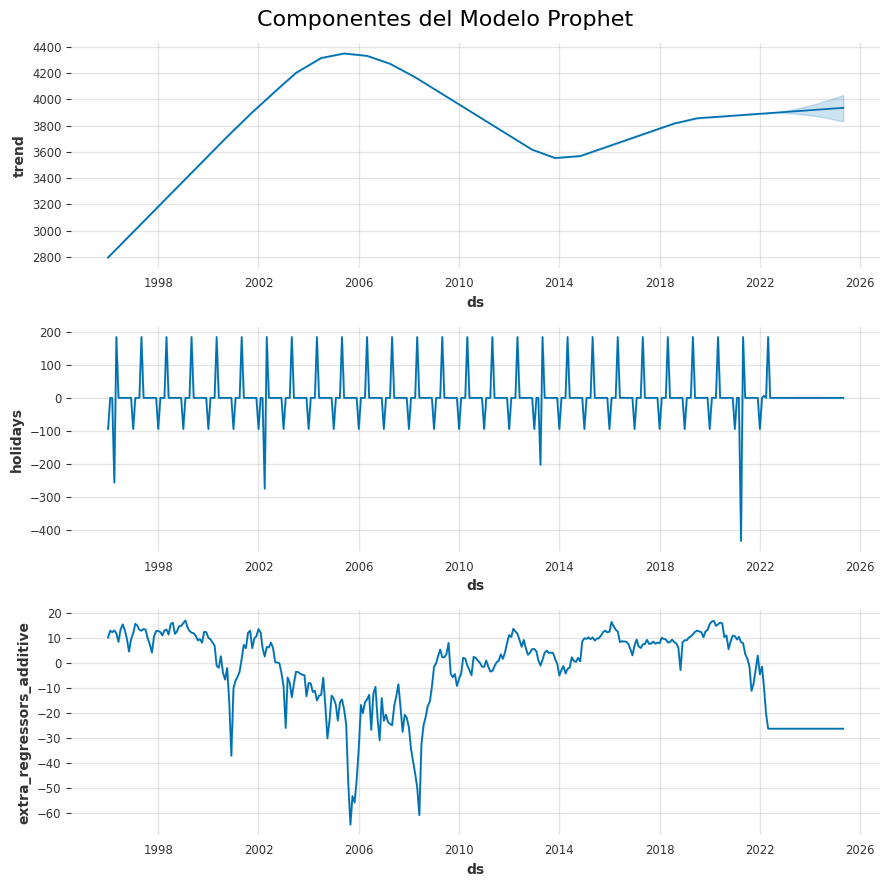


COMPONENTES DEL MODELO PROPHET:
- Tendencia: Dirección general de la serie
- Estacionalidad anual: Patrones que se repiten cada año
- Efectos de feriados: Impacto de días festivos
- Precio: Efecto de la variable exógena 'precio'


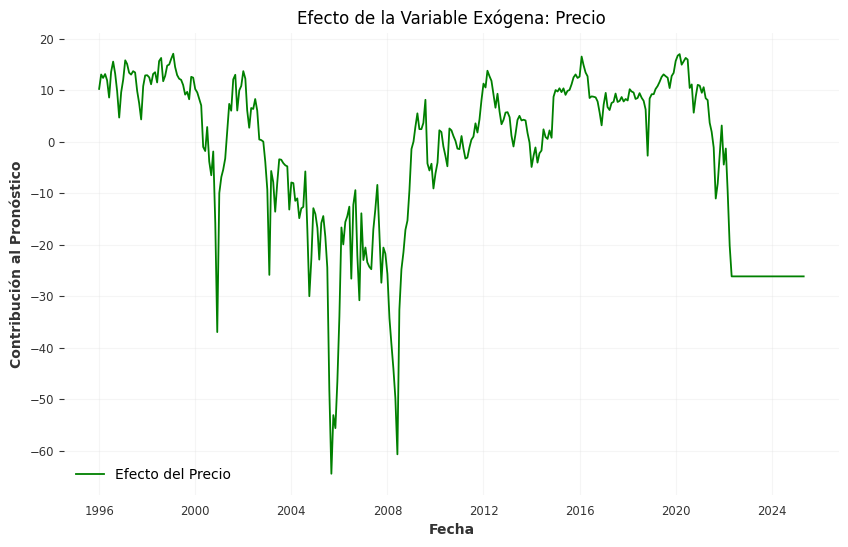


MÉTRICAS FINALES DEL MODELO PROPHET
Modelo: Prophet
Mejores hiperparámetros: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.14522344429817785, 'seasonality_prior_scale': 9.882134453902447, 'holidays_prior_scale': 0.22368845941365145, 'changepoint_range': 0.89322113506256, 'yearly_seasonality': False}
Score CV (MAE): 476.3783

MÉTRICAS DE ENTRENAMIENTO:
AIC Train: 4521.28
BIC Train: 4585.18
RMSE Train: 286.7993

MÉTRICAS DE PRUEBA:
MSE Test: 144205.795421
MAE Test: 303.0531
RMSE Test: 379.7444
MAPE Test: 7.04%


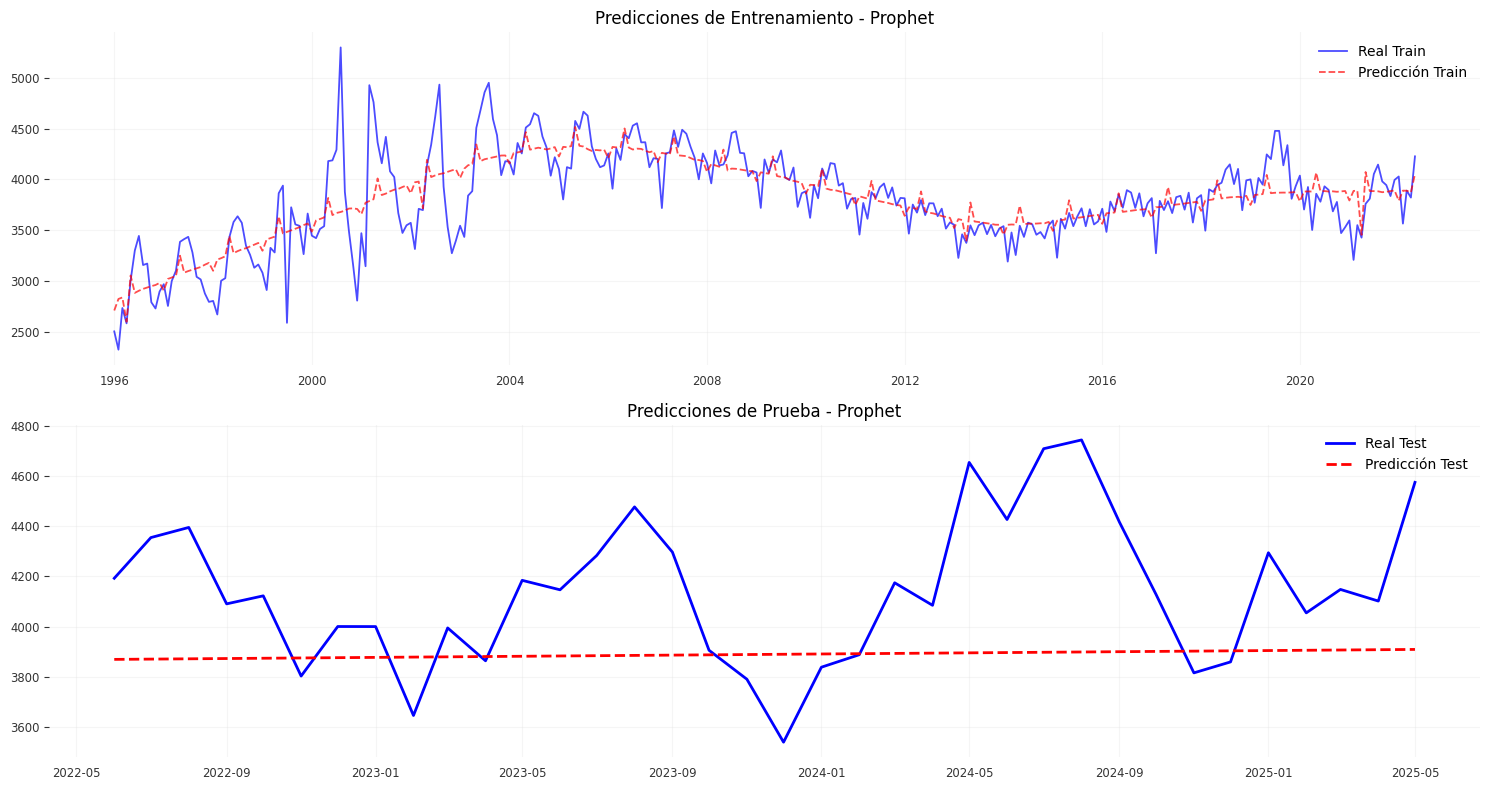


✅ ANÁLISIS PROPHET FINALIZADO
✅ El modelo Prophet ha sido guardado en la variable 'modelo_6'


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Librerías para Prophet
from prophet import Prophet
import optuna
from optuna.samplers import TPESampler

# Librerías para métricas y validación
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

# Para feriados de Argentina
import holidays

# Para tests de estacionariedad
from statsmodels.tsa.stattools import adfuller, kpss

# Función para obtener feriados de Argentina
def get_argentina_holidays(start_date, end_date):
    """
    Obtiene feriados de Argentina en el rango de fechas especificado
    """
    argentina_holidays = holidays.Argentina()
    
    holiday_list = []
    for date in pd.date_range(start=start_date, end=end_date):
        if date in argentina_holidays:
            holiday_list.append({
                'ds': date,
                'holiday': argentina_holidays[date],
                'lower_window': 0,
                'upper_window': 0,
            })
    
    return pd.DataFrame(holiday_list) if holiday_list else pd.DataFrame(columns=['ds', 'holiday'])

# Función para test de estacionariedad
def test_stationarity(timeseries, title):
    """
    Realiza tests de estacionariedad ADF y KPSS
    """
    print(f"\n{'='*60}")
    print(f"TEST DE ESTACIONARIEDAD: {title}")
    print(f"{'='*60}")
    
    # Test ADF (Augmented Dickey-Fuller)
    print("Test ADF (Augmented Dickey-Fuller):")
    adf_result = adfuller(timeseries.dropna())
    print(f"Estadístico ADF: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print("Valores críticos:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.3f}")
    
    if adf_result[1] <= 0.05:
        print("✅ Serie ESTACIONARIA según ADF (p-value <= 0.05)")
        adf_estacionaria = True
    else:
        print("❌ Serie NO ESTACIONARIA según ADF (p-value > 0.05)")
        adf_estacionaria = False
    
    # Test KPSS
    print("\nTest KPSS:")
    kpss_result = kpss(timeseries.dropna(), regression='c')
    print(f"Estadístico KPSS: {kpss_result[0]:.6f}")
    print(f"p-value: {kpss_result[1]:.6f}")
    print("Valores críticos:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value:.3f}")
    
    if kpss_result[1] >= 0.05:
        print("✅ Serie ESTACIONARIA según KPSS (p-value >= 0.05)")
        kpss_estacionaria = True
    else:
        print("❌ Serie NO ESTACIONARIA según KPSS (p-value < 0.05)")
        kpss_estacionaria = False
    
    return adf_estacionaria, kpss_estacionaria

# Función para calcular AIC y BIC
def calculate_aic_bic(y_true, y_pred, n_params):
    """
    Calcula AIC y BIC para modelos de pronóstico
    """
    n = len(y_true)
    mse = mean_squared_error(y_true, y_pred)
    log_likelihood = -n/2 * np.log(2 * np.pi * mse) - n/2
    
    aic = 2 * n_params - 2 * log_likelihood
    bic = np.log(n) * n_params - 2 * log_likelihood
    
    return aic, bic

# Función para validación cruzada con Prophet
def time_series_cv_prophet(data, model_params, n_splits=5):
    """
    Validación cruzada para modelos Prophet
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    
    for train_idx, val_idx in tscv.split(data):
        train_data = data.iloc[train_idx].copy()
        val_data = data.iloc[val_idx].copy()
        
        try:
            model = Prophet(**model_params, daily_seasonality=False)
            
            # Agregar la variable exógena
            model.add_regressor('precio')
            
            # Agregar feriados si están disponibles
            if 'holidays_df' in globals() and not holidays_df.empty:
                model.add_country_holidays(country_name='AR')
            
            model.fit(train_data)
            future = model.make_future_dataframe(periods=len(val_data), freq='M')
            # Incluir la variable exógena en el DataFrame future
            future = future.merge(data[['ds', 'precio']], on='ds', how='left')
            # Rellenar valores futuros de precio
            future['precio'] = future['precio'].fillna(method='ffill')
            forecast = model.predict(future)
            y_pred = forecast['yhat'].iloc[-len(val_data):].values
            
            y_true = val_data['y'].values
            mae = mean_absolute_error(y_true, y_pred)
            scores.append(mae)
            
        except Exception as e:
            print(f"Error en CV: {e}")
            scores.append(float('inf'))
    
    return np.mean(scores)

# Función de optimización para Prophet
def objective_prophet(trial):
    """
    Función objetivo para optimización de Prophet con Optuna
    """
    params = {
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10, log=True),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.95),
        'yearly_seasonality': trial.suggest_categorical('yearly_seasonality', [True, False]),
        'weekly_seasonality': False,  # No relevante para datos mensuales
    }
    
    score = time_series_cv_prophet(train_data_prophet, params)
    return score

# Función principal para entrenar y evaluar Prophet
def entrenar_evaluar_prophet(data, n_trials=50):
    """
    Entrena y evalúa modelo Prophet con optimización Optuna
    """
    print(f"\n{'='*60}")
    print("ENTRENANDO: PROPHET")
    print(f"{'='*60}")
    
    # División train/test (90% - 10%)
    test_size = int(np.ceil(len(data) * 0.10))
    train_data = data.iloc[:-test_size].copy()
    test_data = data.iloc[-test_size:].copy()
    
    # Configurar datos globales para la optimización
    global train_data_prophet
    train_data_prophet = train_data.copy()
    
    # Optimización con Optuna
    print(f"Iniciando optimización con Optuna ({n_trials} trials)...")
    
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective_prophet, n_trials=n_trials, show_progress_bar=True)
    
    best_params = study.best_params
    print(f"Mejores hiperparámetros: {best_params}")
    print(f"Mejor Score CV (MAE): {study.best_value:.4f}")
    
    # Entrenar modelo final con mejores parámetros
    print("Entrenando modelo final...")
    
    model = Prophet(**best_params, daily_seasonality=False)
    
    # Agregar la variable exógena
    model.add_regressor('precio')
    
    # Agregar feriados argentinos
    if not holidays_df.empty:
        model.add_country_holidays(country_name='AR')
    
    model.fit(train_data)
    
    # Predicciones
    future_train = model.make_future_dataframe(periods=0, freq='M')
    future_test = model.make_future_dataframe(periods=len(test_data), freq='M')
    
    # Incluir la variable exógena en los DataFrames future
    future_train = future_train.merge(data[['ds', 'precio']], on='ds', how='left')
    future_test = future_test.merge(data[['ds', 'precio']], on='ds', how='left')
    # Rellenar valores futuros de precio
    future_test['precio'] = future_test['precio'].fillna(method='ffill')
    
    forecast_train = model.predict(future_train)
    forecast_test = model.predict(future_test)
    
    y_pred_train = forecast_train['yhat'].values
    y_pred_test = forecast_test['yhat'].iloc[-len(test_data):].values
    
    # Número de parámetros aproximado para Prophet (agregar 1 por el regresor)
    n_params = 10 + len(best_params) + 1
    
    # Calcular métricas
    y_train = train_data['y'].values
    y_test = test_data['y'].values
    
    # Métricas de Train
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    aic_train, bic_train = calculate_aic_bic(y_train, y_pred_train, n_params)
    
    # Métricas de Test
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    
    # Crear diccionario con resultados
    resultado_modelo = {
        'Modelo': 'Prophet',
        'Mejores_Hiperparametros': best_params,
        'Modelo_Entrenado': model,
        'Score_CV': study.best_value,
        
        # Métricas de Train
        'AIC_Train': aic_train,
        'BIC_Train': bic_train,
        'RMSE_Train': rmse_train,
        
        # Métricas de Test
        'MSE_Test': mse_test,
        'MAE_Test': mae_test,
        'RMSE_Test': rmse_test,
        'MAPE_Test': mape_test,
        
        # Datos adicionales
        'Predicciones_Train': y_pred_train,
        'Predicciones_Test': y_pred_test,
        'datos_train': train_data,
        'datos_test': test_data,
        'forecast_train': forecast_train,
        'forecast_test': forecast_test,
    }
    
    # Mostrar resultados
    print(f"Score CV (MAE): {study.best_value:.4f}")
    print("\nMÉTRICAS DE ENTRENAMIENTO:")
    print(f"AIC Train: {aic_train:.2f}")
    print(f"BIC Train: {bic_train:.2f}")
    print(f"RMSE Train: {rmse_train:.4f}")
    print("\nMÉTRICAS DE PRUEBA:")
    print(f"MSE Test: {mse_test:.6f}")
    print(f"MAE Test: {mae_test:.4f}")
    print(f"RMSE Test: {rmse_test:.4f}")
    print(f"MAPE Test: {mape_test:.2f}%")
    
    return resultado_modelo

# Función para interpretabilidad de Prophet
def analizar_interpretabilidad_prophet(modelo_resultado):
    """
    Análisis de interpretabilidad para Prophet
    """
    model = modelo_resultado['Modelo_Entrenado']
    
    print(f"\n{'='*60}")
    print("ANÁLISIS DE INTERPRETABILIDAD: PROPHET")
    print(f"{'='*60}")
    
    # Componentes de Prophet
    fig1 = model.plot_components(modelo_resultado['forecast_test'])
    plt.suptitle('Componentes del Modelo Prophet', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Importancia de componentes
    print("\nCOMPONENTES DEL MODELO PROPHET:")
    print("- Tendencia: Dirección general de la serie")
    print("- Estacionalidad anual: Patrones que se repiten cada año")
    print("- Efectos de feriados: Impacto de días festivos")
    print("- Precio: Efecto de la variable exógena 'precio'")
    
    # Visualizar el efecto del regresor precio
    plt.figure(figsize=(10, 6))
    plt.plot(modelo_resultado['forecast_test']['ds'], modelo_resultado['forecast_test']['precio'], 'g-', label='Efecto del Precio')
    plt.title('Efecto de la Variable Exógena: Precio')
    plt.xlabel('Fecha')
    plt.ylabel('Contribución al Pronóstico')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# EJECUTAR ANÁLISIS PROPHET

# 1. Preparar datos (asumiendo que df_merged existe con columnas 'indice', 'produccion' y 'precio')
print("Preparando datos para Prophet...")

# Convertir datos al formato requerido por Prophet
data_prophet = pd.DataFrame({
    'ds': pd.to_datetime(df_merged['indice']),
    'y': df_merged['produccion'],
    'precio': df_merged['precio']
})

# Asegurar que las fechas estén ordenadas
data_prophet = data_prophet.sort_values('ds').reset_index(drop=True)

print(f"Datos preparados: {len(data_prophet)} observaciones")
print(f"Rango de fechas: {data_prophet['ds'].min()} a {data_prophet['ds'].max()}")
print(f"Columnas incluidas: {list(data_prophet.columns)}")

# 2. Obtener feriados de Argentina
print("Obteniendo feriados de Argentina...")
start_date = data_prophet['ds'].min()
end_date = data_prophet['ds'].max()
holidays_df = get_argentina_holidays(start_date, end_date)
print(f"Feriados encontrados: {len(holidays_df)}")

# 3. Test de estacionariedad
adf_est, kpss_est = test_stationarity(data_prophet['y'], "Serie de Producción")

# 4. Entrenar modelo Prophet
print(f"\n{'='*80}")
print("INICIANDO ENTRENAMIENTO DE PROPHET")
print(f"{'='*80}")

modelo_6 = entrenar_evaluar_prophet(data_prophet, n_trials=50)

# 5. Análisis de interpretabilidad
analizar_interpretabilidad_prophet(modelo_6)

# 6. Mostrar métricas finales
print(f"\n{'='*80}")
print("MÉTRICAS FINALES DEL MODELO PROPHET")
print(f"{'='*80}")
print(f"Modelo: {modelo_6['Modelo']}")
print(f"Mejores hiperparámetros: {modelo_6['Mejores_Hiperparametros']}")
print(f"Score CV (MAE): {modelo_6['Score_CV']:.4f}")
print("\nMÉTRICAS DE ENTRENAMIENTO:")
print(f"AIC Train: {modelo_6['AIC_Train']:.2f}")
print(f"BIC Train: {modelo_6['BIC_Train']:.2f}")
print(f"RMSE Train: {modelo_6['RMSE_Train']:.4f}")
print("\nMÉTRICAS DE PRUEBA:")
print(f"MSE Test: {modelo_6['MSE_Test']:.6f}")
print(f"MAE Test: {modelo_6['MAE_Test']:.4f}")
print(f"RMSE Test: {modelo_6['RMSE_Test']:.4f}")
print(f"MAPE Test: {modelo_6['MAPE_Test']:.2f}%")

# 7. Gráfico de predicciones vs valores reales
plt.figure(figsize=(15, 8))

# Plot datos de entrenamiento
plt.subplot(2, 1, 1)
train_dates = modelo_6['datos_train']['ds']
plt.plot(train_dates, modelo_6['datos_train']['y'], 'b-', label='Real Train', alpha=0.7)
plt.plot(train_dates, modelo_6['Predicciones_Train'], 'r--', label='Predicción Train', alpha=0.7)
plt.title('Predicciones de Entrenamiento - Prophet')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot datos de test
plt.subplot(2, 1, 2)
test_dates = modelo_6['datos_test']['ds']
plt.plot(test_dates, modelo_6['datos_test']['y'], 'b-', label='Real Test', linewidth=2)
plt.plot(test_dates, modelo_6['Predicciones_Test'], 'r--', label='Predicción Test', linewidth=2)
plt.title('Predicciones de Prueba - Prophet')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ ANÁLISIS PROPHET FINALIZADO")
print(f"✅ El modelo Prophet ha sido guardado en la variable 'modelo_6'")

> Ante este modelo, el error aumenta considerablemente respecto a los otros modelos

##### 5.3.2 Con variable exógena

[I 2025-07-23 00:00:14,619] A new study created in memory with name: no-name-4175dd60-e543-41d1-b74d-45b3925f698e


Preparando datos para Prophet...
Datos preparados: 353 observaciones
Rango de fechas: 1996-01-01 00:00:00 a 2025-05-01 00:00:00
Columnas incluidas: ['ds', 'y', 'precio']
Obteniendo feriados de Argentina...
Feriados encontrados: 454

TEST DE ESTACIONARIEDAD: Serie de Producción
Test ADF (Augmented Dickey-Fuller):
Estadístico ADF: -2.306551
p-value: 0.169864
Valores críticos:
	1%: -3.450
	5%: -2.870
	10%: -2.571
❌ Serie NO ESTACIONARIA según ADF (p-value > 0.05)

Test KPSS:
Estadístico KPSS: 0.549839
p-value: 0.030442
Valores críticos:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
❌ Serie NO ESTACIONARIA según KPSS (p-value < 0.05)

INICIANDO ENTRENAMIENTO DE PROPHET

ENTRENANDO: PROPHET
Iniciando optimización con Optuna (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]

00:00:14 - cmdstanpy - INFO - Chain [1] start processing
00:00:14 - cmdstanpy - INFO - Chain [1] done processing
00:00:14 - cmdstanpy - INFO - Chain [1] start processing
00:00:14 - cmdstanpy - INFO - Chain [1] done processing
00:00:15 - cmdstanpy - INFO - Chain [1] start processing
00:00:15 - cmdstanpy - INFO - Chain [1] done processing
00:00:15 - cmdstanpy - INFO - Chain [1] start processing
00:00:15 - cmdstanpy - INFO - Chain [1] done processing
00:00:15 - cmdstanpy - INFO - Chain [1] start processing
00:00:15 - cmdstanpy - INFO - Chain [1] done processing
00:00:15 - cmdstanpy - INFO - Chain [1] start processing
00:00:15 - cmdstanpy - INFO - Chain [1] done processing
00:00:15 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:00:15,430] Trial 0 finished with value: 494.48570949503653 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.09454306819536169, 'seasonality_prior_scale': 0.6251373574521749, 'holidays_prior_scale': 0.02938027938703535, 'changepoint_range': 0.8233991780504304, 'yearly_seasonality': False}. Best is trial 0 with value: 494.48570949503653.


00:00:15 - cmdstanpy - INFO - Chain [1] done processing
00:00:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:00:15 - cmdstanpy - INFO - Chain [1] start processing
00:00:15 - cmdstanpy - INFO - Chain [1] done processing
00:00:15 - cmdstanpy - INFO - Chain [1] start processing
00:00:15 - cmdstanpy - INFO - Chain [1] done processing
00:00:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:00:15 - cmdstanpy - INFO - Chain [1] start processing
00:00:16 - cmdstanpy - INFO - Chain [1] done processing
00:00:16 - cmdstanpy - INFO - Chain [1] start processing
00:00:16 - cmdstanpy - INFO - Chain [1] done processing
00:00:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:00:16 - cmdstanpy - I

[I 2025-07-23 00:00:16,671] Trial 1 finished with value: 694.5677342377852 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001136467270001117, 'seasonality_prior_scale': 8.123245085588687, 'holidays_prior_scale': 3.142880890840109, 'changepoint_range': 0.8318508666017415, 'yearly_seasonality': False}. Best is trial 0 with value: 494.48570949503653.


00:00:16 - cmdstanpy - INFO - Chain [1] start processing
00:00:16 - cmdstanpy - INFO - Chain [1] done processing
00:00:17 - cmdstanpy - INFO - Chain [1] start processing
00:00:17 - cmdstanpy - INFO - Chain [1] done processing
00:00:17 - cmdstanpy - INFO - Chain [1] start processing
00:00:17 - cmdstanpy - INFO - Chain [1] done processing
00:00:17 - cmdstanpy - INFO - Chain [1] start processing
00:00:17 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:17,374] Trial 2 finished with value: 602.4607665363524 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.014648955132800727, 'seasonality_prior_scale': 0.07476312062252301, 'holidays_prior_scale': 0.6847920095574779, 'changepoint_range': 0.8209240790978063, 'yearly_seasonality': False}. Best is trial 0 with value: 494.48570949503653.


00:00:17 - cmdstanpy - INFO - Chain [1] start processing
00:00:17 - cmdstanpy - INFO - Chain [1] done processing
00:00:17 - cmdstanpy - INFO - Chain [1] start processing
00:00:17 - cmdstanpy - INFO - Chain [1] done processing
00:00:17 - cmdstanpy - INFO - Chain [1] start processing
00:00:17 - cmdstanpy - INFO - Chain [1] done processing
00:00:18 - cmdstanpy - INFO - Chain [1] start processing
00:00:18 - cmdstanpy - INFO - Chain [1] done processing
00:00:18 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:00:18,291] Trial 3 finished with value: 700.9640980557448 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.0034587052147518095, 'seasonality_prior_scale': 0.34890188454913873, 'holidays_prior_scale': 0.59874749104614, 'changepoint_range': 0.8069675619079997, 'yearly_seasonality': True}. Best is trial 0 with value: 494.48570949503653.


00:00:18 - cmdstanpy - INFO - Chain [1] done processing
00:00:18 - cmdstanpy - INFO - Chain [1] start processing
00:00:18 - cmdstanpy - INFO - Chain [1] done processing
00:00:18 - cmdstanpy - INFO - Chain [1] start processing
00:00:19 - cmdstanpy - INFO - Chain [1] done processing
00:00:19 - cmdstanpy - INFO - Chain [1] start processing
00:00:19 - cmdstanpy - INFO - Chain [1] done processing
00:00:19 - cmdstanpy - INFO - Chain [1] start processing
00:00:19 - cmdstanpy - INFO - Chain [1] done processing
00:00:19 - cmdstanpy - INFO - Chain [1] start processing
00:00:19 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:19,548] Trial 4 finished with value: 785.1957308834525 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.4038423798071558, 'seasonality_prior_scale': 2.6619018884890564, 'holidays_prior_scale': 0.08200518402245831, 'changepoint_range': 0.8146508171009577, 'yearly_seasonality': True}. Best is trial 0 with value: 494.48570949503653.


00:00:19 - cmdstanpy - INFO - Chain [1] start processing
00:00:19 - cmdstanpy - INFO - Chain [1] done processing
00:00:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:00:19 - cmdstanpy - INFO - Chain [1] start processing
00:00:19 - cmdstanpy - INFO - Chain [1] done processing
00:00:19 - cmdstanpy - INFO - Chain [1] start processing
00:00:19 - cmdstanpy - INFO - Chain [1] done processing
00:00:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:00:19 - cmdstanpy - INFO - Chain [1] start processing
00:00:20 - cmdstanpy - INFO - Chain [1] done processing
00:00:20 - cmdstanpy - INFO - Chain [1] start processing
00:00:20 - cmdstanpy - INFO - Chain [1] done processing
00:00:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

[I 2025-07-23 00:00:20,808] Trial 5 finished with value: 685.3383129685002 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.0012382649697023553, 'seasonality_prior_scale': 5.345166110646819, 'holidays_prior_scale': 0.059750279999602945, 'changepoint_range': 0.8993783426530972, 'yearly_seasonality': False}. Best is trial 0 with value: 494.48570949503653.


00:00:21 - cmdstanpy - INFO - Chain [1] done processing
00:00:21 - cmdstanpy - INFO - Chain [1] start processing
00:00:21 - cmdstanpy - INFO - Chain [1] done processing
00:00:21 - cmdstanpy - INFO - Chain [1] start processing
00:00:21 - cmdstanpy - INFO - Chain [1] done processing
00:00:21 - cmdstanpy - INFO - Chain [1] start processing
00:00:21 - cmdstanpy - INFO - Chain [1] done processing
00:00:21 - cmdstanpy - INFO - Chain [1] start processing
00:00:21 - cmdstanpy - INFO - Chain [1] done processing
00:00:21 - cmdstanpy - INFO - Chain [1] start processing
00:00:21 - cmdstanpy - INFO - Chain [1] done processing
00:00:21 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:00:21,632] Trial 6 finished with value: 916.4065685473512 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.4138851334163266, 'seasonality_prior_scale': 2.1154290797261215, 'holidays_prior_scale': 6.58410616012161, 'changepoint_range': 0.9342241025641473, 'yearly_seasonality': False}. Best is trial 0 with value: 494.48570949503653.


00:00:21 - cmdstanpy - INFO - Chain [1] done processing
00:00:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:00:21 - cmdstanpy - INFO - Chain [1] start processing
00:00:22 - cmdstanpy - INFO - Chain [1] done processing
00:00:22 - cmdstanpy - INFO - Chain [1] start processing
00:00:22 - cmdstanpy - INFO - Chain [1] done processing
00:00:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:00:22 - cmdstanpy - INFO - Chain [1] start processing
00:00:22 - cmdstanpy - INFO - Chain [1] done processing
00:00:22 - cmdstanpy - INFO - Chain [1] start processing
00:00:22 - cmdstanpy - INFO - Chain [1] done processing
00:00:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:00:22 - cmdstanpy - I

[I 2025-07-23 00:00:23,250] Trial 7 finished with value: 640.6226558408069 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.0013245461546001875, 'seasonality_prior_scale': 0.09462175356461491, 'holidays_prior_scale': 0.14656553886225335, 'changepoint_range': 0.8407023547660845, 'yearly_seasonality': True}. Best is trial 0 with value: 494.48570949503653.


00:00:23 - cmdstanpy - INFO - Chain [1] start processing
00:00:23 - cmdstanpy - INFO - Chain [1] done processing
00:00:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:00:23 - cmdstanpy - INFO - Chain [1] start processing
00:00:23 - cmdstanpy - INFO - Chain [1] done processing
00:00:23 - cmdstanpy - INFO - Chain [1] start processing
00:00:23 - cmdstanpy - INFO - Chain [1] done processing
00:00:23 - cmdstanpy - INFO - Chain [1] start processing
00:00:23 - cmdstanpy - INFO - Chain [1] done processing
00:00:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:00:23 - cmdstanpy - INFO - Chain [1] start processing
00:00:24 - cmdstanpy - INFO - Chain [1] done processing
00:00:24 - cmdstanpy - INFO - Chain [1] start processing
00:00:24 - cmdstanpy - INFO - Chain [1] done processing
00:00:24 -

[I 2025-07-23 00:00:24,694] Trial 8 finished with value: 672.4999928501741 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.0024007683448156367, 'seasonality_prior_scale': 2.5502980701628926, 'holidays_prior_scale': 0.01673601016782578, 'changepoint_range': 0.9480330404900775, 'yearly_seasonality': True}. Best is trial 0 with value: 494.48570949503653.


00:00:24 - cmdstanpy - INFO - Chain [1] done processing
00:00:25 - cmdstanpy - INFO - Chain [1] start processing
00:00:25 - cmdstanpy - INFO - Chain [1] done processing
00:00:25 - cmdstanpy - INFO - Chain [1] start processing
00:00:25 - cmdstanpy - INFO - Chain [1] done processing
00:00:25 - cmdstanpy - INFO - Chain [1] start processing
00:00:25 - cmdstanpy - INFO - Chain [1] done processing
00:00:25 - cmdstanpy - INFO - Chain [1] start processing
00:00:25 - cmdstanpy - INFO - Chain [1] done processing
00:00:25 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:00:25,719] Trial 9 finished with value: 671.6995462694883 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.08086987436021253, 'seasonality_prior_scale': 1.5382308040278996, 'holidays_prior_scale': 2.059733535743719, 'changepoint_range': 0.8111066977601136, 'yearly_seasonality': True}. Best is trial 0 with value: 494.48570949503653.


00:00:25 - cmdstanpy - INFO - Chain [1] done processing
00:00:26 - cmdstanpy - INFO - Chain [1] start processing
00:00:26 - cmdstanpy - INFO - Chain [1] done processing
00:00:26 - cmdstanpy - INFO - Chain [1] start processing
00:00:26 - cmdstanpy - INFO - Chain [1] done processing
00:00:26 - cmdstanpy - INFO - Chain [1] start processing
00:00:26 - cmdstanpy - INFO - Chain [1] done processing
00:00:26 - cmdstanpy - INFO - Chain [1] start processing
00:00:26 - cmdstanpy - INFO - Chain [1] done processing
00:00:26 - cmdstanpy - INFO - Chain [1] start processing
00:00:26 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:26,531] Trial 10 finished with value: 488.49931528638933 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.055004757253899396, 'seasonality_prior_scale': 0.01053517994552274, 'holidays_prior_scale': 0.01132102180423038, 'changepoint_range': 0.8596698852727166, 'yearly_seasonality': False}. Best is trial 10 with value: 488.49931528638933.


00:00:26 - cmdstanpy - INFO - Chain [1] start processing
00:00:26 - cmdstanpy - INFO - Chain [1] done processing
00:00:26 - cmdstanpy - INFO - Chain [1] start processing
00:00:26 - cmdstanpy - INFO - Chain [1] done processing
00:00:26 - cmdstanpy - INFO - Chain [1] start processing
00:00:26 - cmdstanpy - INFO - Chain [1] done processing
00:00:27 - cmdstanpy - INFO - Chain [1] start processing
00:00:27 - cmdstanpy - INFO - Chain [1] done processing
00:00:27 - cmdstanpy - INFO - Chain [1] start processing
00:00:27 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:27,225] Trial 11 finished with value: 490.5038713531233 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.052706797734548165, 'seasonality_prior_scale': 0.018087121323386444, 'holidays_prior_scale': 0.01026375043191005, 'changepoint_range': 0.864030796926304, 'yearly_seasonality': False}. Best is trial 10 with value: 488.49931528638933.


00:00:27 - cmdstanpy - INFO - Chain [1] start processing
00:00:27 - cmdstanpy - INFO - Chain [1] done processing
00:00:27 - cmdstanpy - INFO - Chain [1] start processing
00:00:27 - cmdstanpy - INFO - Chain [1] done processing
00:00:27 - cmdstanpy - INFO - Chain [1] start processing
00:00:27 - cmdstanpy - INFO - Chain [1] done processing
00:00:27 - cmdstanpy - INFO - Chain [1] start processing
00:00:27 - cmdstanpy - INFO - Chain [1] done processing
00:00:27 - cmdstanpy - INFO - Chain [1] start processing
00:00:28 - cmdstanpy - INFO - Chain [1] done processing
00:00:28 - cmdstanpy - INFO - Chain [1] start processing
00:00:28 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:27,948] Trial 12 finished with value: 551.0863932053979 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.027901902849324412, 'seasonality_prior_scale': 0.012390835507193526, 'holidays_prior_scale': 0.01076217377307007, 'changepoint_range': 0.8661026180306008, 'yearly_seasonality': False}. Best is trial 10 with value: 488.49931528638933.


00:00:28 - cmdstanpy - INFO - Chain [1] start processing
00:00:28 - cmdstanpy - INFO - Chain [1] done processing
00:00:28 - cmdstanpy - INFO - Chain [1] start processing
00:00:28 - cmdstanpy - INFO - Chain [1] done processing
00:00:28 - cmdstanpy - INFO - Chain [1] start processing
00:00:28 - cmdstanpy - INFO - Chain [1] done processing
00:00:28 - cmdstanpy - INFO - Chain [1] start processing
00:00:28 - cmdstanpy - INFO - Chain [1] done processing
00:00:28 - cmdstanpy - INFO - Chain [1] start processing
00:00:28 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:28,677] Trial 13 finished with value: 537.0582937800131 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03551048036554269, 'seasonality_prior_scale': 0.013554586987236711, 'holidays_prior_scale': 0.02604154034139691, 'changepoint_range': 0.8703057828331764, 'yearly_seasonality': False}. Best is trial 10 with value: 488.49931528638933.


00:00:28 - cmdstanpy - INFO - Chain [1] start processing
00:00:28 - cmdstanpy - INFO - Chain [1] done processing
00:00:29 - cmdstanpy - INFO - Chain [1] start processing
00:00:29 - cmdstanpy - INFO - Chain [1] done processing
00:00:29 - cmdstanpy - INFO - Chain [1] start processing
00:00:29 - cmdstanpy - INFO - Chain [1] done processing
00:00:29 - cmdstanpy - INFO - Chain [1] start processing
00:00:29 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:29,308] Trial 14 finished with value: 636.3699067725887 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.008905178195032476, 'seasonality_prior_scale': 0.03872197135841052, 'holidays_prior_scale': 0.010694478869045893, 'changepoint_range': 0.8976523704757392, 'yearly_seasonality': False}. Best is trial 10 with value: 488.49931528638933.


00:00:29 - cmdstanpy - INFO - Chain [1] start processing
00:00:29 - cmdstanpy - INFO - Chain [1] done processing
00:00:29 - cmdstanpy - INFO - Chain [1] start processing
00:00:29 - cmdstanpy - INFO - Chain [1] done processing
00:00:29 - cmdstanpy - INFO - Chain [1] start processing
00:00:29 - cmdstanpy - INFO - Chain [1] done processing
00:00:29 - cmdstanpy - INFO - Chain [1] start processing
00:00:29 - cmdstanpy - INFO - Chain [1] done processing
00:00:30 - cmdstanpy - INFO - Chain [1] start processing
00:00:30 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:30,018] Trial 15 finished with value: 481.0347260650742 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.10211320502912515, 'seasonality_prior_scale': 0.03088141456251936, 'holidays_prior_scale': 0.2161519016575703, 'changepoint_range': 0.8513420805769969, 'yearly_seasonality': False}. Best is trial 15 with value: 481.0347260650742.


00:00:30 - cmdstanpy - INFO - Chain [1] start processing
00:00:30 - cmdstanpy - INFO - Chain [1] done processing
00:00:30 - cmdstanpy - INFO - Chain [1] start processing
00:00:30 - cmdstanpy - INFO - Chain [1] done processing
00:00:30 - cmdstanpy - INFO - Chain [1] start processing
00:00:30 - cmdstanpy - INFO - Chain [1] done processing
00:00:30 - cmdstanpy - INFO - Chain [1] start processing
00:00:30 - cmdstanpy - INFO - Chain [1] done processing
00:00:30 - cmdstanpy - INFO - Chain [1] start processing
00:00:30 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:30,708] Trial 16 finished with value: 481.23683122534914 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1674165149032557, 'seasonality_prior_scale': 0.037104878310053754, 'holidays_prior_scale': 0.3065909074110169, 'changepoint_range': 0.848418239188723, 'yearly_seasonality': False}. Best is trial 15 with value: 481.0347260650742.


00:00:30 - cmdstanpy - INFO - Chain [1] start processing
00:00:30 - cmdstanpy - INFO - Chain [1] done processing
00:00:31 - cmdstanpy - INFO - Chain [1] start processing
00:00:31 - cmdstanpy - INFO - Chain [1] done processing
00:00:31 - cmdstanpy - INFO - Chain [1] start processing
00:00:31 - cmdstanpy - INFO - Chain [1] done processing
00:00:31 - cmdstanpy - INFO - Chain [1] start processing
00:00:31 - cmdstanpy - INFO - Chain [1] done processing
00:00:31 - cmdstanpy - INFO - Chain [1] start processing
00:00:31 - cmdstanpy - INFO - Chain [1] done processing
00:00:31 - cmdstanpy - INFO - Chain [1] start processing
00:00:31 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:31,395] Trial 17 finished with value: 533.6670055893919 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.191408740011242, 'seasonality_prior_scale': 0.12023492798617497, 'holidays_prior_scale': 0.2762262817269871, 'changepoint_range': 0.8889822672976889, 'yearly_seasonality': False}. Best is trial 15 with value: 481.0347260650742.


00:00:31 - cmdstanpy - INFO - Chain [1] start processing
00:00:31 - cmdstanpy - INFO - Chain [1] done processing
00:00:31 - cmdstanpy - INFO - Chain [1] start processing
00:00:31 - cmdstanpy - INFO - Chain [1] done processing
00:00:32 - cmdstanpy - INFO - Chain [1] start processing
00:00:32 - cmdstanpy - INFO - Chain [1] done processing
00:00:32 - cmdstanpy - INFO - Chain [1] start processing
00:00:32 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:32,126] Trial 18 finished with value: 478.90228067056404 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.15796261807789666, 'seasonality_prior_scale': 0.03772954253635969, 'holidays_prior_scale': 0.4455056349160817, 'changepoint_range': 0.8459366385949708, 'yearly_seasonality': False}. Best is trial 18 with value: 478.90228067056404.


00:00:32 - cmdstanpy - INFO - Chain [1] start processing
00:00:32 - cmdstanpy - INFO - Chain [1] done processing
00:00:32 - cmdstanpy - INFO - Chain [1] start processing
00:00:32 - cmdstanpy - INFO - Chain [1] done processing
00:00:32 - cmdstanpy - INFO - Chain [1] start processing
00:00:32 - cmdstanpy - INFO - Chain [1] done processing
00:00:32 - cmdstanpy - INFO - Chain [1] start processing
00:00:32 - cmdstanpy - INFO - Chain [1] done processing
00:00:32 - cmdstanpy - INFO - Chain [1] start processing
00:00:32 - cmdstanpy - INFO - Chain [1] done processing
00:00:33 - cmdstanpy - INFO - Chain [1] start processing
00:00:33 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:32,855] Trial 19 finished with value: 533.0346879786068 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1919690051726402, 'seasonality_prior_scale': 0.1702790091582263, 'holidays_prior_scale': 0.8724365199626705, 'changepoint_range': 0.8843769285538012, 'yearly_seasonality': False}. Best is trial 18 with value: 478.90228067056404.


00:00:33 - cmdstanpy - INFO - Chain [1] start processing
00:00:33 - cmdstanpy - INFO - Chain [1] done processing
00:00:33 - cmdstanpy - INFO - Chain [1] start processing
00:00:33 - cmdstanpy - INFO - Chain [1] done processing
00:00:33 - cmdstanpy - INFO - Chain [1] start processing
00:00:33 - cmdstanpy - INFO - Chain [1] done processing
00:00:33 - cmdstanpy - INFO - Chain [1] start processing
00:00:33 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:33,514] Trial 20 finished with value: 608.1940701552111 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.011201505471169068, 'seasonality_prior_scale': 0.033190825361120745, 'holidays_prior_scale': 0.1491828643639685, 'changepoint_range': 0.8399433502040725, 'yearly_seasonality': False}. Best is trial 18 with value: 478.90228067056404.


00:00:33 - cmdstanpy - INFO - Chain [1] start processing
00:00:33 - cmdstanpy - INFO - Chain [1] done processing
00:00:33 - cmdstanpy - INFO - Chain [1] start processing
00:00:33 - cmdstanpy - INFO - Chain [1] done processing
00:00:33 - cmdstanpy - INFO - Chain [1] start processing
00:00:33 - cmdstanpy - INFO - Chain [1] done processing
00:00:34 - cmdstanpy - INFO - Chain [1] start processing
00:00:34 - cmdstanpy - INFO - Chain [1] done processing
00:00:34 - cmdstanpy - INFO - Chain [1] start processing
00:00:34 - cmdstanpy - INFO - Chain [1] done processing
00:00:34 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:00:34,282] Trial 21 finished with value: 544.0332747561686 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.19868516490839333, 'seasonality_prior_scale': 0.040136668953606944, 'holidays_prior_scale': 0.3387472009416502, 'changepoint_range': 0.8545303322291026, 'yearly_seasonality': False}. Best is trial 18 with value: 478.90228067056404.


00:00:34 - cmdstanpy - INFO - Chain [1] done processing
00:00:34 - cmdstanpy - INFO - Chain [1] start processing
00:00:34 - cmdstanpy - INFO - Chain [1] done processing
00:00:34 - cmdstanpy - INFO - Chain [1] start processing
00:00:34 - cmdstanpy - INFO - Chain [1] done processing
00:00:34 - cmdstanpy - INFO - Chain [1] start processing
00:00:34 - cmdstanpy - INFO - Chain [1] done processing
00:00:34 - cmdstanpy - INFO - Chain [1] start processing
00:00:35 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:34,920] Trial 22 finished with value: 481.18993111462305 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1406122691451182, 'seasonality_prior_scale': 0.02318502771754631, 'holidays_prior_scale': 1.4204285307521456, 'changepoint_range': 0.8451579881988872, 'yearly_seasonality': False}. Best is trial 18 with value: 478.90228067056404.


00:00:35 - cmdstanpy - INFO - Chain [1] start processing
00:00:35 - cmdstanpy - INFO - Chain [1] done processing
00:00:35 - cmdstanpy - INFO - Chain [1] start processing
00:00:35 - cmdstanpy - INFO - Chain [1] done processing
00:00:35 - cmdstanpy - INFO - Chain [1] start processing
00:00:35 - cmdstanpy - INFO - Chain [1] done processing
00:00:35 - cmdstanpy - INFO - Chain [1] start processing
00:00:35 - cmdstanpy - INFO - Chain [1] done processing
00:00:35 - cmdstanpy - INFO - Chain [1] start processing
00:00:35 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:35,602] Trial 23 finished with value: 485.6165187956629 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.10395469587209685, 'seasonality_prior_scale': 0.02104279640364595, 'holidays_prior_scale': 1.8360702784132568, 'changepoint_range': 0.8358724480532267, 'yearly_seasonality': False}. Best is trial 18 with value: 478.90228067056404.


00:00:35 - cmdstanpy - INFO - Chain [1] start processing
00:00:35 - cmdstanpy - INFO - Chain [1] done processing
00:00:35 - cmdstanpy - INFO - Chain [1] start processing
00:00:35 - cmdstanpy - INFO - Chain [1] done processing
00:00:36 - cmdstanpy - INFO - Chain [1] start processing
00:00:36 - cmdstanpy - INFO - Chain [1] done processing
00:00:36 - cmdstanpy - INFO - Chain [1] start processing
00:00:36 - cmdstanpy - INFO - Chain [1] done processing
00:00:36 - cmdstanpy - INFO - Chain [1] start processing
00:00:36 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:36,325] Trial 24 finished with value: 664.3297630915138 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2969314600780804, 'seasonality_prior_scale': 0.05372505528970869, 'holidays_prior_scale': 1.231762904293387, 'changepoint_range': 0.853386860647339, 'yearly_seasonality': False}. Best is trial 18 with value: 478.90228067056404.


00:00:36 - cmdstanpy - INFO - Chain [1] start processing
00:00:36 - cmdstanpy - INFO - Chain [1] done processing
00:00:36 - cmdstanpy - INFO - Chain [1] start processing
00:00:36 - cmdstanpy - INFO - Chain [1] done processing
00:00:36 - cmdstanpy - INFO - Chain [1] start processing
00:00:36 - cmdstanpy - INFO - Chain [1] done processing
00:00:36 - cmdstanpy - INFO - Chain [1] start processing
00:00:36 - cmdstanpy - INFO - Chain [1] done processing
00:00:37 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:00:36,997] Trial 25 finished with value: 476.47671947871595 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.12234759627351893, 'seasonality_prior_scale': 0.22466345072949828, 'holidays_prior_scale': 6.613387366041579, 'changepoint_range': 0.87760288478211, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:00:37 - cmdstanpy - INFO - Chain [1] done processing
00:00:37 - cmdstanpy - INFO - Chain [1] start processing
00:00:37 - cmdstanpy - INFO - Chain [1] done processing
00:00:37 - cmdstanpy - INFO - Chain [1] start processing
00:00:37 - cmdstanpy - INFO - Chain [1] done processing
00:00:37 - cmdstanpy - INFO - Chain [1] start processing
00:00:37 - cmdstanpy - INFO - Chain [1] done processing
00:00:37 - cmdstanpy - INFO - Chain [1] start processing
00:00:37 - cmdstanpy - INFO - Chain [1] done processing
00:00:37 - cmdstanpy - INFO - Chain [1] start processing
00:00:37 - cmdstanpy - INFO - Chain [1] done processing
00:00:38 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:00:37,830] Trial 26 finished with value: 506.25278373184454 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.054979285879728314, 'seasonality_prior_scale': 0.21837166651839313, 'holidays_prior_scale': 4.046300871922788, 'changepoint_range': 0.9097875414174321, 'yearly_seasonality': True}. Best is trial 25 with value: 476.47671947871595.


00:00:38 - cmdstanpy - INFO - Chain [1] done processing
00:00:38 - cmdstanpy - INFO - Chain [1] start processing
00:00:38 - cmdstanpy - INFO - Chain [1] done processing
00:00:38 - cmdstanpy - INFO - Chain [1] start processing
00:00:38 - cmdstanpy - INFO - Chain [1] done processing
00:00:38 - cmdstanpy - INFO - Chain [1] start processing
00:00:38 - cmdstanpy - INFO - Chain [1] done processing
00:00:38 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:00:38,471] Trial 27 finished with value: 583.9318344788534 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.018653153559223305, 'seasonality_prior_scale': 0.6309451872695363, 'holidays_prior_scale': 7.4181240012401926, 'changepoint_range': 0.8809399017374835, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:00:38 - cmdstanpy - INFO - Chain [1] done processing
00:00:38 - cmdstanpy - INFO - Chain [1] start processing
00:00:38 - cmdstanpy - INFO - Chain [1] done processing
00:00:38 - cmdstanpy - INFO - Chain [1] start processing
00:00:38 - cmdstanpy - INFO - Chain [1] done processing
00:00:38 - cmdstanpy - INFO - Chain [1] start processing
00:00:38 - cmdstanpy - INFO - Chain [1] done processing
00:00:39 - cmdstanpy - INFO - Chain [1] start processing
00:00:39 - cmdstanpy - INFO - Chain [1] done processing
00:00:39 - cmdstanpy - INFO - Chain [1] start processing
00:00:39 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:39,220] Trial 28 finished with value: 639.4370512679623 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.28194509547928653, 'seasonality_prior_scale': 0.3943332970243426, 'holidays_prior_scale': 0.16434888372020012, 'changepoint_range': 0.9142367895490988, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:00:39 - cmdstanpy - INFO - Chain [1] start processing
00:00:39 - cmdstanpy - INFO - Chain [1] done processing
00:00:39 - cmdstanpy - INFO - Chain [1] start processing
00:00:39 - cmdstanpy - INFO - Chain [1] done processing
00:00:39 - cmdstanpy - INFO - Chain [1] start processing
00:00:39 - cmdstanpy - INFO - Chain [1] done processing
00:00:39 - cmdstanpy - INFO - Chain [1] start processing
00:00:39 - cmdstanpy - INFO - Chain [1] done processing
00:00:39 - cmdstanpy - INFO - Chain [1] start processing
00:00:39 - cmdstanpy - INFO - Chain [1] done processing
00:00:40 - cmdstanpy - INFO - Chain [1] start processing
00:00:40 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:39,869] Trial 29 finished with value: 486.5893627481173 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.09246587236627266, 'seasonality_prior_scale': 0.5279734232238039, 'holidays_prior_scale': 0.06992934972302679, 'changepoint_range': 0.8246515478789254, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:00:40 - cmdstanpy - INFO - Chain [1] start processing
00:00:40 - cmdstanpy - INFO - Chain [1] done processing
00:00:40 - cmdstanpy - INFO - Chain [1] start processing
00:00:40 - cmdstanpy - INFO - Chain [1] done processing
00:00:40 - cmdstanpy - INFO - Chain [1] start processing
00:00:40 - cmdstanpy - INFO - Chain [1] done processing
00:00:40 - cmdstanpy - INFO - Chain [1] start processing
00:00:40 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:40,470] Trial 30 finished with value: 481.12376297809 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.11773241137946898, 'seasonality_prior_scale': 0.98033445534807, 'holidays_prior_scale': 0.4165460983391268, 'changepoint_range': 0.8754636682302447, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:00:40 - cmdstanpy - INFO - Chain [1] start processing
00:00:40 - cmdstanpy - INFO - Chain [1] done processing
00:00:40 - cmdstanpy - INFO - Chain [1] start processing
00:00:40 - cmdstanpy - INFO - Chain [1] done processing
00:00:40 - cmdstanpy - INFO - Chain [1] start processing
00:00:40 - cmdstanpy - INFO - Chain [1] done processing
00:00:41 - cmdstanpy - INFO - Chain [1] start processing
00:00:41 - cmdstanpy - INFO - Chain [1] done processing
00:00:41 - cmdstanpy - INFO - Chain [1] start processing
00:00:41 - cmdstanpy - INFO - Chain [1] done processing
00:00:41 - cmdstanpy - INFO - Chain [1] start processing
00:00:41 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:41,113] Trial 31 finished with value: 484.2220483323874 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.09767485340140418, 'seasonality_prior_scale': 0.8175516070759572, 'holidays_prior_scale': 0.5282574879125236, 'changepoint_range': 0.8793903285053292, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:00:41 - cmdstanpy - INFO - Chain [1] start processing
00:00:41 - cmdstanpy - INFO - Chain [1] done processing
00:00:41 - cmdstanpy - INFO - Chain [1] start processing
00:00:41 - cmdstanpy - INFO - Chain [1] done processing
00:00:41 - cmdstanpy - INFO - Chain [1] start processing
00:00:41 - cmdstanpy - INFO - Chain [1] done processing
00:00:41 - cmdstanpy - INFO - Chain [1] start processing
00:00:41 - cmdstanpy - INFO - Chain [1] done processing
00:00:41 - cmdstanpy - INFO - Chain [1] start processing
00:00:41 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:41,692] Trial 32 finished with value: 530.0887938676088 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.0384611746457056, 'seasonality_prior_scale': 1.057961097026833, 'holidays_prior_scale': 0.42542354267106497, 'changepoint_range': 0.8703796325158998, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:00:41 - cmdstanpy - INFO - Chain [1] start processing
00:00:41 - cmdstanpy - INFO - Chain [1] done processing
00:00:42 - cmdstanpy - INFO - Chain [1] start processing
00:00:42 - cmdstanpy - INFO - Chain [1] done processing
00:00:42 - cmdstanpy - INFO - Chain [1] start processing
00:00:42 - cmdstanpy - INFO - Chain [1] done processing
00:00:42 - cmdstanpy - INFO - Chain [1] start processing
00:00:42 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:42,286] Trial 33 finished with value: 477.5270669964299 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.125555521595506, 'seasonality_prior_scale': 0.07295515207731382, 'holidays_prior_scale': 0.197755290724367, 'changepoint_range': 0.826200999142348, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:00:42 - cmdstanpy - INFO - Chain [1] start processing
00:00:42 - cmdstanpy - INFO - Chain [1] done processing
00:00:42 - cmdstanpy - INFO - Chain [1] start processing
00:00:42 - cmdstanpy - INFO - Chain [1] done processing
00:00:42 - cmdstanpy - INFO - Chain [1] start processing
00:00:42 - cmdstanpy - INFO - Chain [1] done processing
00:00:42 - cmdstanpy - INFO - Chain [1] start processing
00:00:42 - cmdstanpy - INFO - Chain [1] done processing
00:00:43 - cmdstanpy - INFO - Chain [1] start processing
00:00:43 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:43,070] Trial 34 finished with value: 497.0262833002449 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.06819912204275946, 'seasonality_prior_scale': 0.06678947093850336, 'holidays_prior_scale': 0.2024252983621731, 'changepoint_range': 0.8254226765754515, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:00:43 - cmdstanpy - INFO - Chain [1] start processing
00:00:43 - cmdstanpy - INFO - Chain [1] done processing
00:00:43 - cmdstanpy - INFO - Chain [1] start processing
00:00:43 - cmdstanpy - INFO - Chain [1] done processing
00:00:43 - cmdstanpy - INFO - Chain [1] start processing
00:00:43 - cmdstanpy - INFO - Chain [1] done processing
00:00:43 - cmdstanpy - INFO - Chain [1] start processing
00:00:43 - cmdstanpy - INFO - Chain [1] done processing
00:00:43 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:00:43,740] Trial 35 finished with value: 635.3735896106748 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.24539653463961708, 'seasonality_prior_scale': 0.1449687522337243, 'holidays_prior_scale': 0.10067995763927697, 'changepoint_range': 0.8311445021479485, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:00:43 - cmdstanpy - INFO - Chain [1] done processing
00:00:44 - cmdstanpy - INFO - Chain [1] start processing
00:00:44 - cmdstanpy - INFO - Chain [1] done processing
00:00:44 - cmdstanpy - INFO - Chain [1] start processing
00:00:44 - cmdstanpy - INFO - Chain [1] done processing
00:00:44 - cmdstanpy - INFO - Chain [1] start processing
00:00:44 - cmdstanpy - INFO - Chain [1] done processing
00:00:44 - cmdstanpy - INFO - Chain [1] start processing
00:00:44 - cmdstanpy - INFO - Chain [1] done processing
00:00:44 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:00:44,672] Trial 36 finished with value: 648.1433960342536 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.13499548217196145, 'seasonality_prior_scale': 0.22458304124422762, 'holidays_prior_scale': 0.038605603089994625, 'changepoint_range': 0.8016502861053605, 'yearly_seasonality': True}. Best is trial 25 with value: 476.47671947871595.


00:00:44 - cmdstanpy - INFO - Chain [1] done processing
00:00:45 - cmdstanpy - INFO - Chain [1] start processing
00:00:45 - cmdstanpy - INFO - Chain [1] done processing
00:00:45 - cmdstanpy - INFO - Chain [1] start processing
00:00:45 - cmdstanpy - INFO - Chain [1] done processing
00:00:45 - cmdstanpy - INFO - Chain [1] start processing
00:00:45 - cmdstanpy - INFO - Chain [1] done processing
00:00:45 - cmdstanpy - INFO - Chain [1] start processing
00:00:45 - cmdstanpy - INFO - Chain [1] done processing
00:00:45 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:00:45,500] Trial 37 finished with value: 733.2172210450201 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.432100718602247, 'seasonality_prior_scale': 0.09494602907719484, 'holidays_prior_scale': 4.595467652557537, 'changepoint_range': 0.8185218255478096, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:00:45 - cmdstanpy - INFO - Chain [1] done processing
00:00:45 - cmdstanpy - INFO - Chain [1] start processing
00:00:45 - cmdstanpy - INFO - Chain [1] done processing
00:00:45 - cmdstanpy - INFO - Chain [1] start processing
00:00:45 - cmdstanpy - INFO - Chain [1] done processing
00:00:46 - cmdstanpy - INFO - Chain [1] start processing
00:00:46 - cmdstanpy - INFO - Chain [1] done processing
00:00:46 - cmdstanpy - INFO - Chain [1] start processing
00:00:46 - cmdstanpy - INFO - Chain [1] done processing
00:00:46 - cmdstanpy - INFO - Chain [1] start processing
00:00:46 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:46,293] Trial 38 finished with value: 752.0120720357168 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.34752542348238386, 'seasonality_prior_scale': 0.05790865085171515, 'holidays_prior_scale': 0.7701648204523591, 'changepoint_range': 0.8302899664724595, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:00:46 - cmdstanpy - INFO - Chain [1] start processing
00:00:46 - cmdstanpy - INFO - Chain [1] done processing
00:00:46 - cmdstanpy - INFO - Chain [1] start processing
00:00:46 - cmdstanpy - INFO - Chain [1] done processing
00:00:46 - cmdstanpy - INFO - Chain [1] start processing
00:00:46 - cmdstanpy - INFO - Chain [1] done processing
00:00:46 - cmdstanpy - INFO - Chain [1] start processing
00:00:47 - cmdstanpy - INFO - Chain [1] done processing
00:00:47 - cmdstanpy - INFO - Chain [1] start processing
00:00:47 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:47,190] Trial 39 finished with value: 589.1006851059375 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.007121648959205316, 'seasonality_prior_scale': 0.028376212153220087, 'holidays_prior_scale': 0.11804284003234675, 'changepoint_range': 0.8571586395324993, 'yearly_seasonality': True}. Best is trial 25 with value: 476.47671947871595.


00:00:47 - cmdstanpy - INFO - Chain [1] start processing
00:00:47 - cmdstanpy - INFO - Chain [1] done processing
00:00:47 - cmdstanpy - INFO - Chain [1] start processing
00:00:47 - cmdstanpy - INFO - Chain [1] done processing
00:00:47 - cmdstanpy - INFO - Chain [1] start processing
00:00:47 - cmdstanpy - INFO - Chain [1] done processing
00:00:47 - cmdstanpy - INFO - Chain [1] start processing
00:00:47 - cmdstanpy - INFO - Chain [1] done processing
00:00:48 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:00:47,906] Trial 40 finished with value: 501.96863196260836 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.06270913320283868, 'seasonality_prior_scale': 0.07589063914234292, 'holidays_prior_scale': 9.731666145379842, 'changepoint_range': 0.8473527402148416, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:00:48 - cmdstanpy - INFO - Chain [1] done processing
00:00:48 - cmdstanpy - INFO - Chain [1] start processing
00:00:48 - cmdstanpy - INFO - Chain [1] done processing
00:00:48 - cmdstanpy - INFO - Chain [1] start processing
00:00:48 - cmdstanpy - INFO - Chain [1] done processing
00:00:48 - cmdstanpy - INFO - Chain [1] start processing
00:00:48 - cmdstanpy - INFO - Chain [1] done processing
00:00:48 - cmdstanpy - INFO - Chain [1] start processing
00:00:48 - cmdstanpy - INFO - Chain [1] done processing
00:00:48 - cmdstanpy - INFO - Chain [1] start processing
00:00:48 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:48,660] Trial 41 finished with value: 479.01413096672906 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.12387541757138253, 'seasonality_prior_scale': 5.38967801059055, 'holidays_prior_scale': 0.23948160503727534, 'changepoint_range': 0.8933594415041333, 'yearly_seasonality': False}. Best is trial 25 with value: 476.47671947871595.


00:00:48 - cmdstanpy - INFO - Chain [1] start processing
00:00:48 - cmdstanpy - INFO - Chain [1] done processing
00:00:48 - cmdstanpy - INFO - Chain [1] start processing
00:00:48 - cmdstanpy - INFO - Chain [1] done processing
00:00:49 - cmdstanpy - INFO - Chain [1] start processing
00:00:49 - cmdstanpy - INFO - Chain [1] done processing
00:00:49 - cmdstanpy - INFO - Chain [1] start processing
00:00:49 - cmdstanpy - INFO - Chain [1] done processing
00:00:49 - cmdstanpy - INFO - Chain [1] start processing
00:00:49 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:49,330] Trial 42 finished with value: 476.3783484126122 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.14522344429817785, 'seasonality_prior_scale': 9.882134453902447, 'holidays_prior_scale': 0.22368845941365145, 'changepoint_range': 0.89322113506256, 'yearly_seasonality': False}. Best is trial 42 with value: 476.3783484126122.


00:00:49 - cmdstanpy - INFO - Chain [1] start processing
00:00:49 - cmdstanpy - INFO - Chain [1] done processing
00:00:49 - cmdstanpy - INFO - Chain [1] start processing
00:00:49 - cmdstanpy - INFO - Chain [1] done processing
00:00:49 - cmdstanpy - INFO - Chain [1] start processing
00:00:49 - cmdstanpy - INFO - Chain [1] done processing
00:00:49 - cmdstanpy - INFO - Chain [1] start processing
00:00:49 - cmdstanpy - INFO - Chain [1] done processing
00:00:50 - cmdstanpy - INFO - Chain [1] start processing
00:00:50 - cmdstanpy - INFO - Chain [1] done processing
00:00:50 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:00:50,026] Trial 43 finished with value: 568.3655211859567 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.22454858635055672, 'seasonality_prior_scale': 6.499952524106535, 'holidays_prior_scale': 0.244070149115725, 'changepoint_range': 0.893424176953512, 'yearly_seasonality': False}. Best is trial 42 with value: 476.3783484126122.


00:00:50 - cmdstanpy - INFO - Chain [1] done processing
00:00:50 - cmdstanpy - INFO - Chain [1] start processing
00:00:50 - cmdstanpy - INFO - Chain [1] done processing
00:00:50 - cmdstanpy - INFO - Chain [1] start processing
00:00:50 - cmdstanpy - INFO - Chain [1] done processing
00:00:50 - cmdstanpy - INFO - Chain [1] start processing
00:00:50 - cmdstanpy - INFO - Chain [1] done processing
00:00:50 - cmdstanpy - INFO - Chain [1] start processing
00:00:50 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:50,678] Trial 44 finished with value: 496.1651559888552 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.14303541045975748, 'seasonality_prior_scale': 9.979384959254132, 'holidays_prior_scale': 0.0432028131360084, 'changepoint_range': 0.9082452794538346, 'yearly_seasonality': False}. Best is trial 42 with value: 476.3783484126122.


00:00:50 - cmdstanpy - INFO - Chain [1] start processing
00:00:50 - cmdstanpy - INFO - Chain [1] done processing
00:00:51 - cmdstanpy - INFO - Chain [1] start processing
00:00:51 - cmdstanpy - INFO - Chain [1] done processing
00:00:51 - cmdstanpy - INFO - Chain [1] start processing
00:00:51 - cmdstanpy - INFO - Chain [1] done processing
00:00:51 - cmdstanpy - INFO - Chain [1] start processing
00:00:51 - cmdstanpy - INFO - Chain [1] done processing
00:00:51 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-07-23 00:00:51,587] Trial 45 finished with value: 506.829329128578 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.04386519647564407, 'seasonality_prior_scale': 3.737989909961968, 'holidays_prior_scale': 0.11622269121824186, 'changepoint_range': 0.9217625014657642, 'yearly_seasonality': True}. Best is trial 42 with value: 476.3783484126122.


00:00:51 - cmdstanpy - INFO - Chain [1] done processing
00:00:51 - cmdstanpy - INFO - Chain [1] start processing
00:00:51 - cmdstanpy - INFO - Chain [1] done processing
00:00:52 - cmdstanpy - INFO - Chain [1] start processing
00:00:52 - cmdstanpy - INFO - Chain [1] done processing
00:00:52 - cmdstanpy - INFO - Chain [1] start processing
00:00:52 - cmdstanpy - INFO - Chain [1] done processing
00:00:52 - cmdstanpy - INFO - Chain [1] start processing
00:00:52 - cmdstanpy - INFO - Chain [1] done processing
00:00:52 - cmdstanpy - INFO - Chain [1] start processing
00:00:52 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:52,463] Trial 46 finished with value: 949.6908639387888 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.47942582217824753, 'seasonality_prior_scale': 4.580521249154292, 'holidays_prior_scale': 0.5888293891720605, 'changepoint_range': 0.9040023119155433, 'yearly_seasonality': False}. Best is trial 42 with value: 476.3783484126122.


00:00:52 - cmdstanpy - INFO - Chain [1] start processing
00:00:52 - cmdstanpy - INFO - Chain [1] done processing
00:00:52 - cmdstanpy - INFO - Chain [1] start processing
00:00:52 - cmdstanpy - INFO - Chain [1] done processing
00:00:52 - cmdstanpy - INFO - Chain [1] start processing
00:00:52 - cmdstanpy - INFO - Chain [1] done processing
00:00:53 - cmdstanpy - INFO - Chain [1] start processing
00:00:53 - cmdstanpy - INFO - Chain [1] done processing
00:00:53 - cmdstanpy - INFO - Chain [1] start processing
00:00:53 - cmdstanpy - INFO - Chain [1] done processing
00:00:53 - cmdstanpy - INFO - Chain [1] start processing
00:00:53 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:53,145] Trial 47 finished with value: 488.4465069940032 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.07642576398863314, 'seasonality_prior_scale': 6.96527788607281, 'holidays_prior_scale': 3.006047728218306, 'changepoint_range': 0.9247201572065086, 'yearly_seasonality': False}. Best is trial 42 with value: 476.3783484126122.


00:00:53 - cmdstanpy - INFO - Chain [1] start processing
00:00:53 - cmdstanpy - INFO - Chain [1] done processing
00:00:53 - cmdstanpy - INFO - Chain [1] start processing
00:00:53 - cmdstanpy - INFO - Chain [1] done processing
00:00:53 - cmdstanpy - INFO - Chain [1] start processing
00:00:53 - cmdstanpy - INFO - Chain [1] done processing
00:00:53 - cmdstanpy - INFO - Chain [1] start processing
00:00:53 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:53,798] Trial 48 finished with value: 581.3488322854867 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.030070874248136037, 'seasonality_prior_scale': 1.8734367613115002, 'holidays_prior_scale': 1.0803853997439896, 'changepoint_range': 0.8920327306618123, 'yearly_seasonality': False}. Best is trial 42 with value: 476.3783484126122.


00:00:54 - cmdstanpy - INFO - Chain [1] start processing
00:00:54 - cmdstanpy - INFO - Chain [1] done processing
00:00:54 - cmdstanpy - INFO - Chain [1] start processing
00:00:54 - cmdstanpy - INFO - Chain [1] done processing
00:00:54 - cmdstanpy - INFO - Chain [1] start processing
00:00:54 - cmdstanpy - INFO - Chain [1] done processing
00:00:54 - cmdstanpy - INFO - Chain [1] start processing
00:00:54 - cmdstanpy - INFO - Chain [1] done processing
00:00:54 - cmdstanpy - INFO - Chain [1] start processing
00:00:54 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-07-23 00:00:54,524] Trial 49 finished with value: 518.1186671514981 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.16619119252496536, 'seasonality_prior_scale': 9.072052073809889, 'holidays_prior_scale': 0.055798109971762225, 'changepoint_range': 0.8997322307935024, 'yearly_seasonality': False}. Best is trial 42 with value: 476.3783484126122.
Mejores hiperparámetros: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.14522344429817785, 'seasonality_prior_scale': 9.882134453902447, 'holidays_prior_scale': 0.22368845941365145, 'changepoint_range': 0.89322113506256, 'yearly_seasonality': False}
Mejor Score CV (MAE): 476.3783
Entrenando modelo final...
Score CV (MAE): 476.3783

MÉTRICAS DE ENTRENAMIENTO:
AIC Train: 4521.28
BIC Train: 4585.18
RMSE Train: 286.7993

MÉTRICAS DE PRUEBA:
MSE Test: 144205.795421
MAE Test: 303.0531
RMSE Test: 379.7444
MAPE Test: 7.04%

ANÁLISIS DE INTERPRETABILIDAD: PROPHET


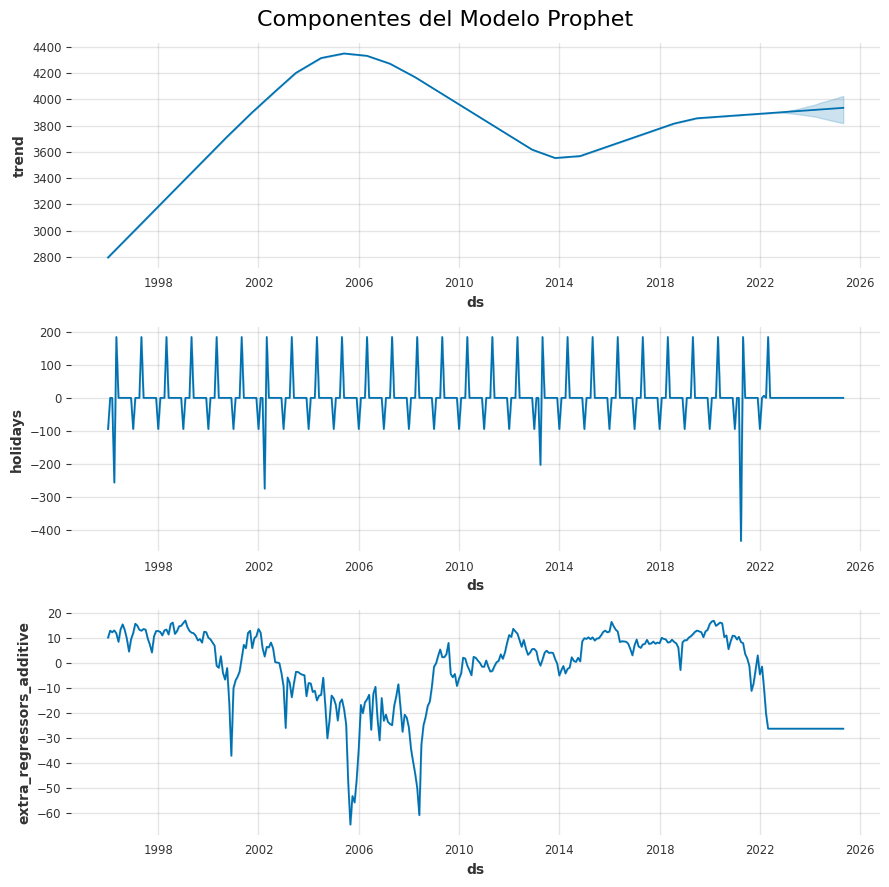


COMPONENTES DEL MODELO PROPHET:
- Tendencia: Dirección general de la serie
- Estacionalidad anual: Patrones que se repiten cada año
- Efectos de feriados: Impacto de días festivos
- Precio: Efecto de la variable exógena 'precio'


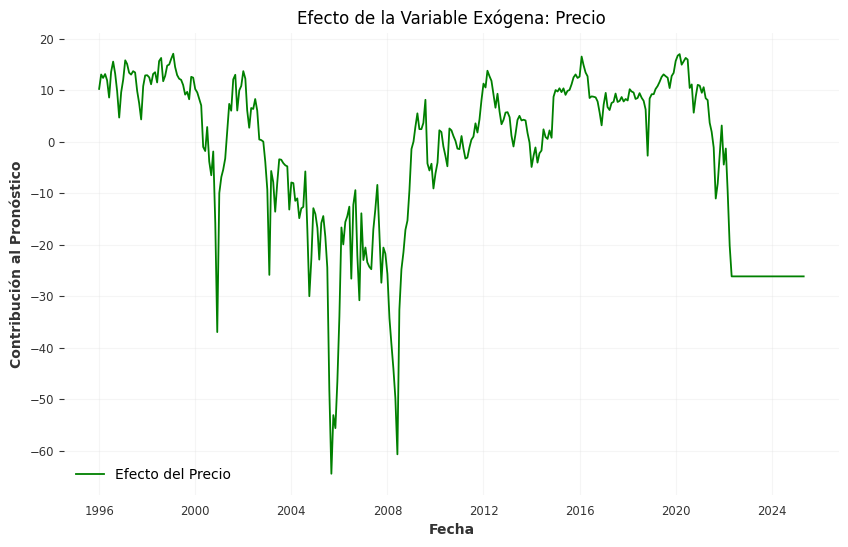


MÉTRICAS FINALES DEL MODELO PROPHET
Modelo: Prophet
Mejores hiperparámetros: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.14522344429817785, 'seasonality_prior_scale': 9.882134453902447, 'holidays_prior_scale': 0.22368845941365145, 'changepoint_range': 0.89322113506256, 'yearly_seasonality': False}
Score CV (MAE): 476.3783

MÉTRICAS DE ENTRENAMIENTO:
AIC Train: 4521.28
BIC Train: 4585.18
RMSE Train: 286.7993

MÉTRICAS DE PRUEBA:
MSE Test: 144205.795421
MAE Test: 303.0531
RMSE Test: 379.7444
MAPE Test: 7.04%


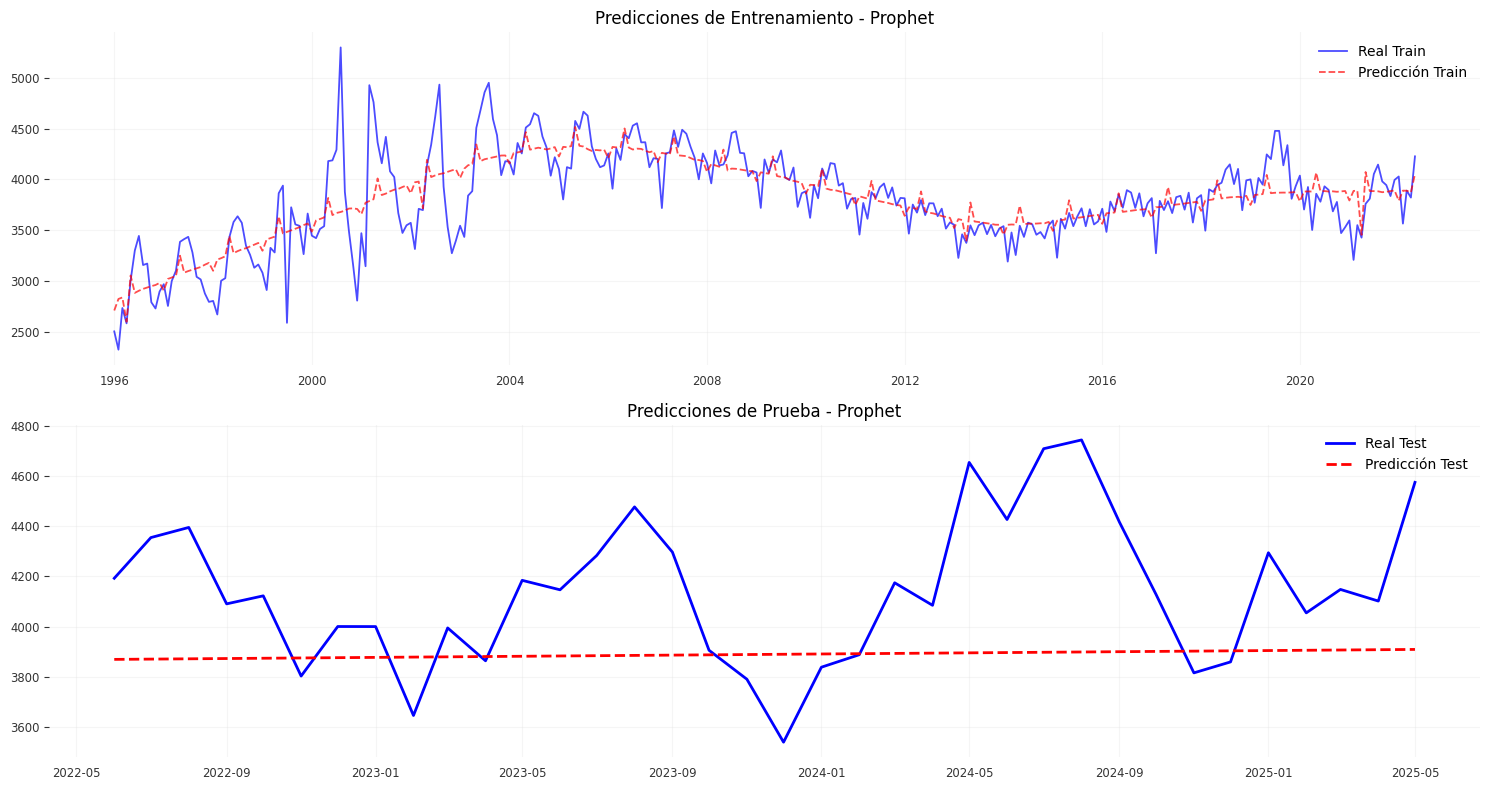


✅ ANÁLISIS PROPHET FINALIZADO
✅ El modelo Prophet ha sido guardado en la variable 'modelo_prophet'


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Librerías para Prophet
from prophet import Prophet
import optuna
from optuna.samplers import TPESampler

# Librerías para métricas y validación
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

# Para feriados de Argentina
import holidays

# Para tests de estacionariedad
from statsmodels.tsa.stattools import adfuller, kpss

# Función para obtener feriados de Argentina
def get_argentina_holidays(start_date, end_date):
    """
    Obtiene feriados de Argentina en el rango de fechas especificado
    """
    argentina_holidays = holidays.Argentina()
    
    holiday_list = []
    for date in pd.date_range(start=start_date, end=end_date):
        if date in argentina_holidays:
            holiday_list.append({
                'ds': date,
                'holiday': argentina_holidays[date],
                'lower_window': 0,
                'upper_window': 0,
            })
    
    return pd.DataFrame(holiday_list) if holiday_list else pd.DataFrame(columns=['ds', 'holiday'])

# Función para test de estacionariedad
def test_stationarity(timeseries, title):
    """
    Realiza tests de estacionariedad ADF y KPSS
    """
    print(f"\n{'='*60}")
    print(f"TEST DE ESTACIONARIEDAD: {title}")
    print(f"{'='*60}")
    
    # Test ADF (Augmented Dickey-Fuller)
    print("Test ADF (Augmented Dickey-Fuller):")
    adf_result = adfuller(timeseries.dropna())
    print(f"Estadístico ADF: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print("Valores críticos:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.3f}")
    
    if adf_result[1] <= 0.05:
        print("✅ Serie ESTACIONARIA según ADF (p-value <= 0.05)")
        adf_estacionaria = True
    else:
        print("❌ Serie NO ESTACIONARIA según ADF (p-value > 0.05)")
        adf_estacionaria = False
    
    # Test KPSS
    print("\nTest KPSS:")
    kpss_result = kpss(timeseries.dropna(), regression='c')
    print(f"Estadístico KPSS: {kpss_result[0]:.6f}")
    print(f"p-value: {kpss_result[1]:.6f}")
    print("Valores críticos:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value:.3f}")
    
    if kpss_result[1] >= 0.05:
        print("✅ Serie ESTACIONARIA según KPSS (p-value >= 0.05)")
        kpss_estacionaria = True
    else:
        print("❌ Serie NO ESTACIONARIA según KPSS (p-value < 0.05)")
        kpss_estacionaria = False
    
    return adf_estacionaria, kpss_estacionaria

# Función para calcular AIC y BIC
def calculate_aic_bic(y_true, y_pred, n_params):
    """
    Calcula AIC y BIC para modelos de pronóstico
    """
    n = len(y_true)
    mse = mean_squared_error(y_true, y_pred)
    log_likelihood = -n/2 * np.log(2 * np.pi * mse) - n/2
    
    aic = 2 * n_params - 2 * log_likelihood
    bic = np.log(n) * n_params - 2 * log_likelihood
    
    return aic, bic

# Función para validación cruzada con Prophet
def time_series_cv_prophet(data, model_params, n_splits=5):
    """
    Validación cruzada para modelos Prophet
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    
    for train_idx, val_idx in tscv.split(data):
        train_data = data.iloc[train_idx].copy()
        val_data = data.iloc[val_idx].copy()
        
        try:
            model = Prophet(**model_params, daily_seasonality=False)
            
            # Agregar la variable exógena
            model.add_regressor('precio')
            
            # Agregar feriados si están disponibles
            if 'holidays_df' in globals() and not holidays_df.empty:
                model.add_country_holidays(country_name='AR')
            
            model.fit(train_data)
            future = model.make_future_dataframe(periods=len(val_data), freq='M')
            # Incluir la variable exógena en el DataFrame future
            future = future.merge(data[['ds', 'precio']], on='ds', how='left')
            # Rellenar valores futuros de precio
            future['precio'] = future['precio'].fillna(method='ffill')
            forecast = model.predict(future)
            y_pred = forecast['yhat'].iloc[-len(val_data):].values
            
            y_true = val_data['y'].values
            mae = mean_absolute_error(y_true, y_pred)
            scores.append(mae)
            
        except Exception as e:
            print(f"Error en CV: {e}")
            scores.append(float('inf'))
    
    return np.mean(scores)

# Función de optimización para Prophet
def objective_prophet(trial):
    """
    Función objetivo para optimización de Prophet con Optuna
    """
    params = {
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10, log=True),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.95),
        'yearly_seasonality': trial.suggest_categorical('yearly_seasonality', [True, False]),
        'weekly_seasonality': False,  # No relevante para datos mensuales
    }
    
    score = time_series_cv_prophet(train_data_prophet, params)
    return score

# Función principal para entrenar y evaluar Prophet
def entrenar_evaluar_prophet(data, n_trials=50):
    """
    Entrena y evalúa modelo Prophet con optimización Optuna
    """
    print(f"\n{'='*60}")
    print("ENTRENANDO: PROPHET")
    print(f"{'='*60}")
    
    # División train/test (90% - 10%)
    test_size = int(np.ceil(len(data) * 0.10))
    train_data = data.iloc[:-test_size].copy()
    test_data = data.iloc[-test_size:].copy()
    
    # Configurar datos globales para la optimización
    global train_data_prophet
    train_data_prophet = train_data.copy()
    
    # Optimización con Optuna
    print(f"Iniciando optimización con Optuna ({n_trials} trials)...")
    
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective_prophet, n_trials=n_trials, show_progress_bar=True)
    
    best_params = study.best_params
    print(f"Mejores hiperparámetros: {best_params}")
    print(f"Mejor Score CV (MAE): {study.best_value:.4f}")
    
    # Entrenar modelo final con mejores parámetros
    print("Entrenando modelo final...")
    
    model = Prophet(**best_params, daily_seasonality=False)
    
    # Agregar la variable exógena
    model.add_regressor('precio')
    
    # Agregar feriados argentinos
    if not holidays_df.empty:
        model.add_country_holidays(country_name='AR')
    
    model.fit(train_data)
    
    # Predicciones
    future_train = model.make_future_dataframe(periods=0, freq='M')
    future_test = model.make_future_dataframe(periods=len(test_data), freq='M')
    
    # Incluir la variable exógena en los DataFrames future
    future_train = future_train.merge(data[['ds', 'precio']], on='ds', how='left')
    future_test = future_test.merge(data[['ds', 'precio']], on='ds', how='left')
    # Rellenar valores futuros de precio
    future_test['precio'] = future_test['precio'].fillna(method='ffill')
    
    forecast_train = model.predict(future_train)
    forecast_test = model.predict(future_test)
    
    y_pred_train = forecast_train['yhat'].values
    y_pred_test = forecast_test['yhat'].iloc[-len(test_data):].values
    
    # Número de parámetros aproximado para Prophet (agregar 1 por el regresor)
    n_params = 10 + len(best_params) + 1
    
    # Calcular métricas
    y_train = train_data['y'].values
    y_test = test_data['y'].values
    
    # Métricas de Train
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    aic_train, bic_train = calculate_aic_bic(y_train, y_pred_train, n_params)
    
    # Métricas de Test
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    
    # Crear diccionario con resultados
    resultado_modelo = {
        'Modelo': 'Prophet',
        'Mejores_Hiperparametros': best_params,
        'Modelo_Entrenado': model,
        'Score_CV': study.best_value,
        
        # Métricas de Train
        'AIC_Train': aic_train,
        'BIC_Train': bic_train,
        'RMSE_Train': rmse_train,
        
        # Métricas de Test
        'MSE_Test': mse_test,
        'MAE_Test': mae_test,
        'RMSE_Test': rmse_test,
        'MAPE_Test': mape_test,
        
        # Datos adicionales
        'Predicciones_Train': y_pred_train,
        'Predicciones_Test': y_pred_test,
        'datos_train': train_data,
        'datos_test': test_data,
        'forecast_train': forecast_train,
        'forecast_test': forecast_test,
    }
    
    # Mostrar resultados
    print(f"Score CV (MAE): {study.best_value:.4f}")
    print("\nMÉTRICAS DE ENTRENAMIENTO:")
    print(f"AIC Train: {aic_train:.2f}")
    print(f"BIC Train: {bic_train:.2f}")
    print(f"RMSE Train: {rmse_train:.4f}")
    print("\nMÉTRICAS DE PRUEBA:")
    print(f"MSE Test: {mse_test:.6f}")
    print(f"MAE Test: {mae_test:.4f}")
    print(f"RMSE Test: {rmse_test:.4f}")
    print(f"MAPE Test: {mape_test:.2f}%")
    
    return resultado_modelo

# Función para interpretabilidad de Prophet
def analizar_interpretabilidad_prophet(modelo_resultado):
    """
    Análisis de interpretabilidad para Prophet
    """
    model = modelo_resultado['Modelo_Entrenado']
    
    print(f"\n{'='*60}")
    print("ANÁLISIS DE INTERPRETABILIDAD: PROPHET")
    print(f"{'='*60}")
    
    # Componentes de Prophet
    fig1 = model.plot_components(modelo_resultado['forecast_test'])
    plt.suptitle('Componentes del Modelo Prophet', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Importancia de componentes
    print("\nCOMPONENTES DEL MODELO PROPHET:")
    print("- Tendencia: Dirección general de la serie")
    print("- Estacionalidad anual: Patrones que se repiten cada año")
    print("- Efectos de feriados: Impacto de días festivos")
    print("- Precio: Efecto de la variable exógena 'precio'")
    
    # Visualizar el efecto del regresor precio
    plt.figure(figsize=(10, 6))
    plt.plot(modelo_resultado['forecast_test']['ds'], modelo_resultado['forecast_test']['precio'], 'g-', label='Efecto del Precio')
    plt.title('Efecto de la Variable Exógena: Precio')
    plt.xlabel('Fecha')
    plt.ylabel('Contribución al Pronóstico')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# EJECUTAR ANÁLISIS PROPHET

# 1. Preparar datos (asumiendo que df_merged existe con columnas 'indice', 'produccion' y 'precio')
print("Preparando datos para Prophet...")

# Convertir datos al formato requerido por Prophet
data_prophet = pd.DataFrame({
    'ds': pd.to_datetime(df_merged['indice']),
    'y': df_merged['produccion'],
    'precio': df_merged['precio']
})

# Asegurar que las fechas estén ordenadas
data_prophet = data_prophet.sort_values('ds').reset_index(drop=True)

print(f"Datos preparados: {len(data_prophet)} observaciones")
print(f"Rango de fechas: {data_prophet['ds'].min()} a {data_prophet['ds'].max()}")
print(f"Columnas incluidas: {list(data_prophet.columns)}")

# 2. Obtener feriados de Argentina
print("Obteniendo feriados de Argentina...")
start_date = data_prophet['ds'].min()
end_date = data_prophet['ds'].max()
holidays_df = get_argentina_holidays(start_date, end_date)
print(f"Feriados encontrados: {len(holidays_df)}")

# 3. Test de estacionariedad
adf_est, kpss_est = test_stationarity(data_prophet['y'], "Serie de Producción")

# 4. Entrenar modelo Prophet
print(f"\n{'='*80}")
print("INICIANDO ENTRENAMIENTO DE PROPHET")
print(f"{'='*80}")

modelo_prophet = entrenar_evaluar_prophet(data_prophet, n_trials=50)

# 5. Análisis de interpretabilidad
analizar_interpretabilidad_prophet(modelo_prophet)

# 6. Mostrar métricas finales
print(f"\n{'='*80}")
print("MÉTRICAS FINALES DEL MODELO PROPHET")
print(f"{'='*80}")
print(f"Modelo: {modelo_prophet['Modelo']}")
print(f"Mejores hiperparámetros: {modelo_prophet['Mejores_Hiperparametros']}")
print(f"Score CV (MAE): {modelo_prophet['Score_CV']:.4f}")
print("\nMÉTRICAS DE ENTRENAMIENTO:")
print(f"AIC Train: {modelo_prophet['AIC_Train']:.2f}")
print(f"BIC Train: {modelo_prophet['BIC_Train']:.2f}")
print(f"RMSE Train: {modelo_prophet['RMSE_Train']:.4f}")
print("\nMÉTRICAS DE PRUEBA:")
print(f"MSE Test: {modelo_prophet['MSE_Test']:.6f}")
print(f"MAE Test: {modelo_prophet['MAE_Test']:.4f}")
print(f"RMSE Test: {modelo_prophet['RMSE_Test']:.4f}")
print(f"MAPE Test: {modelo_prophet['MAPE_Test']:.2f}%")

# 7. Gráfico de predicciones vs valores reales
plt.figure(figsize=(15, 8))

# Plot datos de entrenamiento
plt.subplot(2, 1, 1)
train_dates = modelo_prophet['datos_train']['ds']
plt.plot(train_dates, modelo_prophet['datos_train']['y'], 'b-', label='Real Train', alpha=0.7)
plt.plot(train_dates, modelo_prophet['Predicciones_Train'], 'r--', label='Predicción Train', alpha=0.7)
plt.title('Predicciones de Entrenamiento - Prophet')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot datos de test
plt.subplot(2, 1, 2)
test_dates = modelo_prophet['datos_test']['ds']
plt.plot(test_dates, modelo_prophet['datos_test']['y'], 'b-', label='Real Test', linewidth=2)
plt.plot(test_dates, modelo_prophet['Predicciones_Test'], 'r--', label='Predicción Test', linewidth=2)
plt.title('Predicciones de Prueba - Prophet')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ ANÁLISIS PROPHET FINALIZADO")
print(f"✅ El modelo Prophet ha sido guardado en la variable 'modelo_prophet'")

Nuevamente, agregar la variable exógena aumenta la complejidad pero no la precisión del modelo

> Por lo tanto, se elige el modelo Prophet sin considerar la variable exógena

## 6. Elección del modelo óptimo

#### Resumen de todos los modelos

Creamos una tabla resumen con las principales características de los modelos óptimos de cada grupo

In [42]:
import pandas as pd
from IPython.display import display

modelo_1 = {
    'Modelo': 'Random Forest',
    'RMSE_Train': 91.5634357724829,
    'MSE_Test': 7154.75159875059,
    'MAE_Test': 64.84527299127298,
    'RMSE_Test': 84.58576475241321,
    'MAPE_Test': 1.5653207410464582
}

modelo_4 = {
    'Modelo': 'RNN',
    'RMSE_Train': 214.13642767063635,
    'MSE_Test': 35464.64564146501,
    'MAE_Test': 144.63114670116144,
    'RMSE_Test': 188.3205927174854,
    'MAPE_Test': 3.468917649018984
}

modelo_6 = {
    'Modelo': 'Prophet',
    'RMSE_Train': 286.79925467420884,
    'MSE_Test': 144205.7954207464,
    'MAE_Test': 303.05311860777704,
    'RMSE_Test': 379.74438168424086,
    'MAPE_Test': 7.036523055059201
}

models = [
    ('Random Forest', modelo_1),
    ('RNN', modelo_4),
    ('Prophet', modelo_6)
]

metrics = {
    'RMSE_Train': 'RMSE Train',
    'MSE_Test': 'MSE Test',
    'MAE_Test': 'MAE Test',
    'RMSE_Test': 'RMSE Test',
    'MAPE_Test': 'MAPE Test (%)'
}

comparison_data = {
    'Modelo': [],
    'RMSE Train': [],
    'MSE Test': [],
    'MAE Test': [],
    'RMSE Test': [],
    'MAPE Test (%)': []
}

for model_name, model_result in models:
    comparison_data['Modelo'].append(model_name)
    for metric_key, metric_name in metrics.items():
        value = model_result.get(metric_key, float('nan'))
        if metric_key == 'MAPE_Test':
            comparison_data[metric_name].append(round(value, 2) if not pd.isna(value) else 'N/A')
        else:
            comparison_data[metric_name].append(round(value, 2) if not pd.isna(value) else 'N/A')

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values(by='RMSE Test')

styled_df = comparison_df.style.set_caption('Tabla de Comparación de Métricas de Modelos')\
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('color', '#2E4057')]},
        {'selector': 'th', 'props': [('background-color', '#4B5EAA'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '8px')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#F5F6F5')]},
        {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#FFFFFF')]}
    ])\
    .format({
        'RMSE Train': '{:.2f}',
        'MSE Test': '{:.2f}',
        'MAE Test': '{:.2f}',
        'RMSE Test': '{:.2f}',
        'MAPE Test (%)': '{:.2f}'
    })

print("\nTabla de Comparación de Métricas de Modelos")
print("="*60)
display(styled_df)


Tabla de Comparación de Métricas de Modelos


,Modelo,RMSE Train,MSE Test,MAE Test,RMSE Test,MAPE Test (%)
0,Random Forest,91.56,7154.75,64.85,84.59,1.57
1,RNN,214.14,35464.65,144.63,188.32,3.47
2,Prophet,286.80,144205.80,303.05,379.74,7.04


> El modelo óptimo es Random Forest, ya que presenta los menores valores de RMSE y MAE, lo cual sugiere una mejor precisión y exactitud tanto en la fase de entrenamiento como en la de prueba, y también el menor MAPE, indicando un error porcentual mínimo en relación con los valores reales. Además, siguiendo el criterio de parsimonia, se destaca por su menor complejidad en comparación con las otras alternativas, sin sacrificar precisión.

## 7. Diagnóstico del mejor modelo

#### 7.1 Importancia de variables

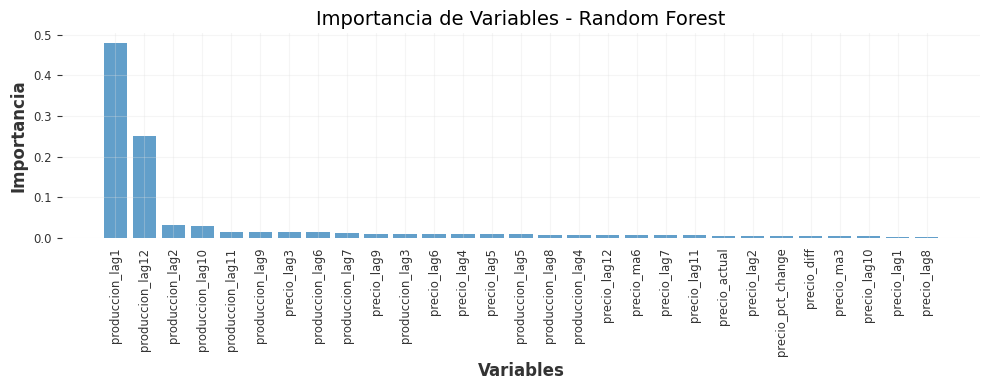

In [50]:
import matplotlib.pyplot as plt
import numpy as np

importancias = modelo_rf['Modelo_Entrenado'].feature_importances_
indices = np.argsort(importancias)[::-1]
features = modelo_rf['X_train'].columns

plt.figure(figsize=(10, 4))
plt.bar(range(len(features)), importancias[indices], color='tab:blue', alpha=0.7)
plt.xticks(range(len(features)), features[indices], rotation=90)
plt.title("Importancia de Variables - Random Forest", fontsize=14)
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Importancia", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### 7.2 Observado vs Predicho: Train y Test

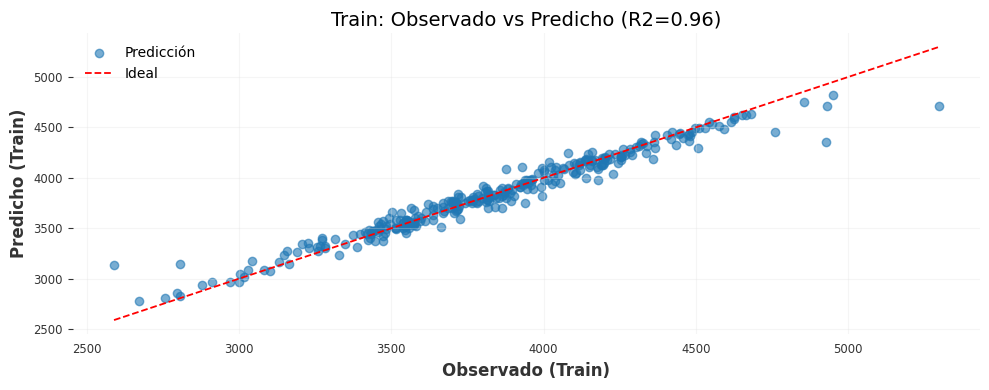

In [51]:
from sklearn.metrics import r2_score

y_train = modelo_rf['y_train']
y_train_pred = modelo_rf['Predicciones_Train']

plt.figure(figsize=(10, 4))
plt.scatter(y_train, y_train_pred, alpha=0.6, color='tab:blue', label='Predicción')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Ideal')
plt.title(f"Train: Observado vs Predicho (R2={r2_score(y_train, y_train_pred):.2f})", fontsize=14)
plt.xlabel("Observado (Train)", fontsize=12)
plt.ylabel("Predicho (Train)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

> - Se observa que los puntos se alinean muy bien a lo largo de la línea roja (línea ideal donde el valor observado es igual al valor predicho), lo que indica que el modelo logra ajustar correctamente los datos de entrenamiento. 
> - El coeficiente de determinación R2 = 0.96 confirma un excelente poder explicativo, evidenciando que el modelo captura la mayor parte de la variabilidad de la serie en el set de entrenamiento.
> - No se aprecian sesgos sistemáticos ni grandes dispersiones, lo que sugiere un ajuste robusto y sin sobreajuste aparente en train.

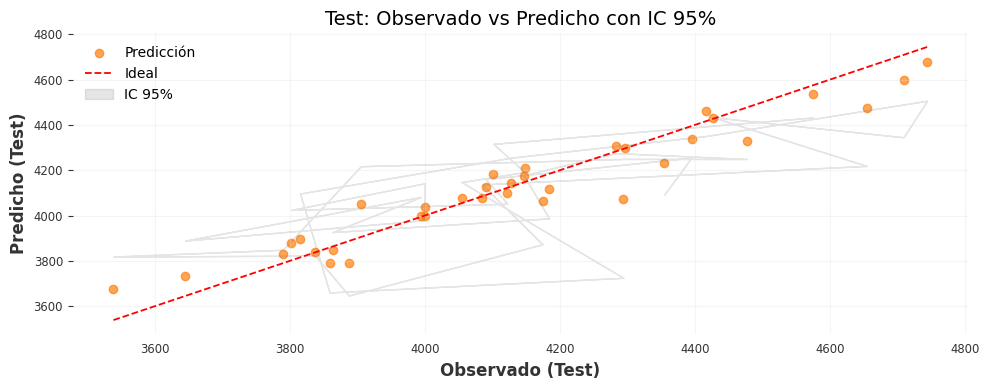

In [52]:
from sklearn.utils import resample

X_test = modelo_rf['X_test']
y_test = modelo_rf['y_test']
y_test_pred = modelo_rf['Predicciones_Test']

# Bootstrap para IC 95%
n_bootstraps = 500  # Menor para acelerar, puedes subirlo si quieres
preds_bootstrap = np.zeros((n_bootstraps, len(y_test)))

for i in range(n_bootstraps):
    X_resampled, y_resampled = resample(X_test, y_test)
    modelo_rf['Modelo_Entrenado'].fit(modelo_rf['X_train'], modelo_rf['y_train'])
    preds_bootstrap[i] = modelo_rf['Modelo_Entrenado'].predict(X_test)

lower = np.percentile(preds_bootstrap, 2.5, axis=0)
upper = np.percentile(preds_bootstrap, 97.5, axis=0)

plt.figure(figsize=(10, 4))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='tab:orange', label="Predicción")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal")
plt.fill_between(y_test, lower, upper, color='gray', alpha=0.2, label="IC 95%")
plt.title("Test: Observado vs Predicho con IC 95%", fontsize=14)
plt.xlabel("Observado (Test)", fontsize=12)
plt.ylabel("Predicho (Test)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

> - Se observa que la mayoría de los puntos se alinean cercanos a la línea roja, lo que indica que el modelo mantiene un buen desempeño predictivo fuera de la muestra de entrenamiento. 
> - La dispersión es moderada y los intervalos de confianza reflejan la incertidumbre inherente a la predicción, pero en general las predicciones se encuentran dentro de los rangos esperados. 
> - Esto sugiere que el modelo generaliza adecuadamente y no presenta un sobreajuste significativo, aunque la precisión es levemente menor que en train, como es esperable.

#### 7.2 Análisis de residuos

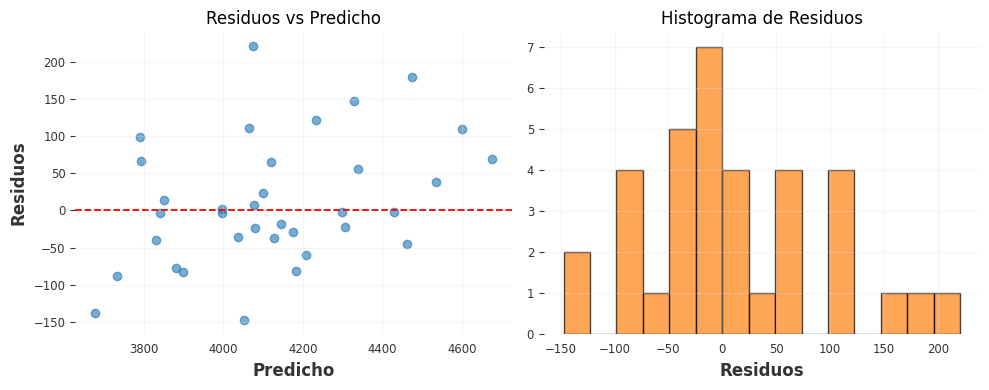

In [53]:
residuos = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(y_test_pred, residuos, alpha=0.6, color='tab:blue')
axes[0].axhline(0, color='r', linestyle='--')
axes[0].set_xlabel("Predicho", fontsize=12)
axes[0].set_ylabel("Residuos", fontsize=12)
axes[0].set_title("Residuos vs Predicho", fontsize=12)
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuos, bins=15, edgecolor='k', color='tab:orange', alpha=0.7)
axes[1].set_xlabel("Residuos", fontsize=12)
axes[1].set_title("Histograma de Residuos", fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

> - Este gráfico de residuos muestra que los errores del modelo se distribuyen de manera aproximadamente simétrica alrededor de cero, sin evidenciar patrones claros ni tendencias sistemáticas en función de los valores predichos. 
> - El histograma indica que la mayoría de los residuos son pequeños y cercanos a cero, aunque existen algunos valores atípicos. 
> - En conjunto, esto respalda la validez de las predicciones realizadas por el modelo.

## 8. Forecast con el mejor modelo

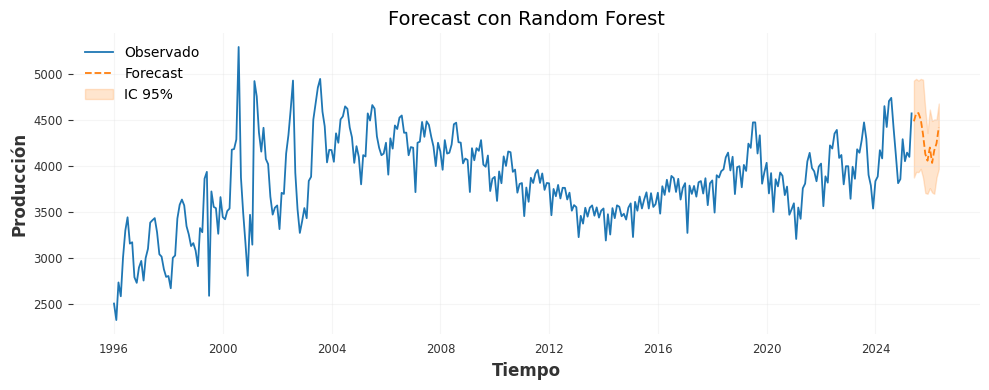

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n_forecast = 12
lags = 12
cols = modelo_rf['X_train'].columns

# Tomar los últimos lags de producción y precio
last_produccion = df_merged['produccion'].values[-lags:].tolist()
last_precio = df_merged['precio'].values[-lags:].tolist()

future_preds = []
lower_ci = []
upper_ci = []

# Obtener los árboles individuales del Random Forest
trees = modelo_rf['Modelo_Entrenado'].estimators_

for i in range(n_forecast):
    # Construir el diccionario de features para el siguiente paso
    features = {}
    for lag in range(1, lags+1):
        features[f'produccion_lag{lag}'] = last_produccion[-lag]
        features[f'precio_lag{lag}'] = last_precio[-lag]
    
    # Asegúrate de que el orden de las columnas sea el mismo que en el entrenamiento
    X_next = pd.DataFrame([features], columns=cols)
    
    # Obtener predicciones de todos los árboles
    tree_preds = np.array([tree.predict(X_next)[0] for tree in trees])
    
    # Predicción promedio (la predicción del Random Forest)
    y_next = np.mean(tree_preds)
    
    # Calcular el intervalo de confianza del 95% (percentiles 2.5 y 97.5)
    ci_lower = np.percentile(tree_preds, 2.5)
    ci_upper = np.percentile(tree_preds, 97.5)
    
    future_preds.append(y_next)
    lower_ci.append(ci_lower)
    upper_ci.append(ci_upper)
    
    # Actualiza los lags para el siguiente paso
    last_produccion.append(y_next)
    last_precio.append(last_precio[-1])  # Asumiendo que no tienes forecast de precio

# Convertir a arrays para graficar
future_preds = np.array(future_preds)
lower_ci = np.array(lower_ci)
upper_ci = np.array(upper_ci)

# Graficar
plt.figure(figsize=(10, 4))
plt.plot(df_merged['indice'], df_merged['produccion'], label="Observado", color='tab:blue')

# Crear un rango de fechas para el forecast
fechas_forecast = pd.date_range(df_merged['indice'].iloc[-1] + pd.offsets.MonthBegin(1), periods=n_forecast, freq='MS')

# Graficar predicciones y el intervalo de confianza
plt.plot(fechas_forecast, future_preds, label="Forecast", linestyle='--', color='tab:orange')
plt.fill_between(fechas_forecast, lower_ci, upper_ci, color='tab:orange', alpha=0.2, label='IC 95%')

plt.xlabel("Tiempo", fontsize=12)
plt.ylabel("Producción", fontsize=12)
plt.title("Forecast con Random Forest", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()